<a href="https://colab.research.google.com/github/TaiwoOlaiya/App-Performance-Analysis-And-Data-Compliance-Awareness/blob/main/Fruit_Garden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl

**Week 3 Started from here**

In [ ]:
import pandas as pd
import os
from pathlib import Path
import re

# Define folder paths
folders = {
    "ReviewVs": r"C:\Users\hp\Desktop\WEEK 3_DSHub\Reviewvs",
    "Stats_Crashes": r"C:\Users\hp\Desktop\WEEK 3_DSHub\Stats_Crashes",
    "Stats_Install": r"C:\Users\hp\Desktop\WEEK 3_DSHub\Stats_Install",
    "Stats_Ratings": r"C:\Users\hp\Desktop\WEEK 3_DSHub\Stats_Ratings",
    "Supported_devices": r"C:\Users\hp\Desktop\WEEK 3_DSHub\Supported_devices"
}

# Dictionary to store merged dataframes
merged_dataframes = {}

# Process each folder
for folder_name, folder_path in folders.items():
    print(f"\n{'='*60}")
    print(f"Processing: {folder_name}")
    print(f"{'='*60}")

    # Check if folder exists
    if not os.path.exists(folder_path):
        print(f"  Folder not found: {folder_path}")
        continue

    # Get all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    if not csv_files:
        print(f"  No CSV files found in {folder_name}")
        continue

    print(f"Found {len(csv_files)} CSV file(s)")

    # Read and clean each CSV file
    dataframes = []
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        try:
            # Try reading with Python engine and error handling
            try:
                df = pd.read_csv(file_path, encoding='utf-8', engine='python', on_bad_lines='skip', quoting=3)
            except:
                try:
                    df = pd.read_csv(file_path, encoding='latin-1', engine='python', on_bad_lines='skip', quoting=3)
                except:
                    # Last resort: read with maximum flexibility
                    df = pd.read_csv(file_path, encoding='utf-8', engine='python', on_bad_lines='skip')

            # Remove completely empty rows
            df = df.dropna(how='all')

            # Clean column names (strip whitespace)
            df.columns = df.columns.str.strip()

            # Handle any comma-separated values in cells
            df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

            if len(df) > 0:
                print(f"  ✓ Loaded: {csv_file} ({len(df)} rows, {len(df.columns)} columns)")
                dataframes.append(df)
            else:
                print(f"  ⚠ Skipped: {csv_file} (empty after cleaning)")

        except Exception as e:
            print(f"  ✗ Error processing {csv_file}: {str(e)}")

    # Merge all dataframes in the folder
    if dataframes:
        if len(dataframes) == 1:
            merged_df = dataframes[0]
        else:
            # Merge on index to combine all rows (concatenate)
            merged_df = pd.concat(dataframes, ignore_index=True, sort=False)

        # Clean the merged dataframe immediately
        merged_df = clean_dataframe(merged_df)

        merged_dataframes[folder_name] = merged_df
        print(f"\n✓ Merged data: {len(merged_df)} total rows, {len(merged_df.columns)} columns")
        print(f"Preview of {folder_name}:")
        print(merged_df.head())
    else:
        print(f"\n✗ No data to merge for {folder_name}")

# Export all merged dataframes to Excel
output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Output.xlsx"

print(f"\n{'='*60}")
print("Exporting to Excel...")
print(f"{'='*60}")

def clean_text(x):
    if isinstance(x, str):
        # Remove byte order marks (BOM) and invisible characters
        x = x.replace("\ufeff", "").replace("ÿþ", "")
        # Remove control and illegal Excel characters
        x = re.sub(r"[\x00-\x1F\x7F-\x9F]", "", x)
        # Remove any remaining non-printable Unicode
        x = ''.join(ch for ch in x if ch.isprintable())
        return x.strip()
    return x

def clean_dataframe(df):
    """Clean dataframe using clean_text function"""
    # Apply clean_text to all column names
    df.columns = [clean_text(col) for col in df.columns]

    # Rename problematic columns
    df.columns = df.columns.str.replace('Package Name', 'Package_Name', regex=False)
    df.columns = df.columns.str.replace('Package name', 'Package_Name', regex=False)

    # Apply clean_text to all object columns
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].apply(clean_text)

    return df

def get_safe_sheet_name(name, index):
    """Create a safe sheet name for Excel"""
    # Excel sheet names cannot exceed 31 characters and cannot contain: \ / ? * [ ] :
    safe_name = name.replace('\\', '').replace('/', '').replace('?', '').replace('*', '').replace('[', '').replace(']', '').replace(':', '')
    safe_name = safe_name.strip()[:31]
    return safe_name if safe_name else f"Sheet_{index}"

try:
    excel_max_rows = 1048576
    output_base = output_path.replace('.xlsx', '')
    file_count = 0

    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        for idx, (folder_name, df) in enumerate(merged_dataframes.items(), 1):
            df = clean_dataframe(df)

            # Check if data exceeds Excel row limit
            if len(df) > excel_max_rows:
                print(f"\n  ⚠ {folder_name} has {len(df)} rows (exceeds Excel limit of {excel_max_rows})")
                print(f"    Splitting into multiple files...")

                # Split into multiple files
                num_chunks = (len(df) // excel_max_rows) + 1
                for chunk_num in range(num_chunks):
                    start_row = chunk_num * excel_max_rows
                    end_row = (chunk_num + 1) * excel_max_rows
                    chunk_df = df.iloc[start_row:end_row]

                    chunk_file = f"{output_base}_{folder_name}_Part{chunk_num + 1}.xlsx"
                    chunk_df.to_excel(chunk_file, sheet_name=f"Data_Pt{chunk_num + 1}", index=False, engine='openpyxl')
                    print(f"    ✓ Part {chunk_num + 1}: '{chunk_file}' ({len(chunk_df)} rows)")
                    file_count += 1
            else:
                # Use safe sheet name function
                sheet_name = get_safe_sheet_name(folder_name, idx)

                df.to_excel(writer, sheet_name=sheet_name, index=False)
                print(f"  ✓ Sheet {idx}: '{sheet_name}' ({len(df)} rows)")
                file_count += 1

    print(f"\n✓ Success! Files exported:")
    print(f"  Main file: {output_path}")
    if file_count > 5:
        print(f"  Plus {file_count - 1} additional split files for large datasets")

except Exception as e:
    print(f"\n✗ Error during export: {str(e)}")
    print("Attempting individual file export...")

    # Fallback: Export each folder to separate file
    try:
        for idx, (folder_name, df) in enumerate(merged_dataframes.items(), 1):
            df = clean_dataframe(df)

            excel_max_rows = 1048576
            if len(df) > excel_max_rows:
                print(f"\n  {folder_name}: {len(df)} rows - splitting...")
                num_chunks = (len(df) // excel_max_rows) + 1
                for chunk_num in range(num_chunks):
                    start_row = chunk_num * excel_max_rows
                    end_row = (chunk_num + 1) * excel_max_rows
                    chunk_df = df.iloc[start_row:end_row]

                    chunk_file = output_path.replace('.xlsx', f'_{folder_name}_Part{chunk_num + 1}.xlsx')
                    chunk_df.to_excel(chunk_file, sheet_name='Data_Pt', index=False, engine='openpyxl')
                    print(f"    ✓ {chunk_file} ({len(chunk_df)} rows)")
            else:
                alt_output = output_path.replace('.xlsx', f'_{folder_name}.xlsx')
                sheet_name = get_safe_sheet_name(folder_name, idx)
                df.to_excel(alt_output, sheet_name=sheet_name, index=False, engine='openpyxl')
                print(f"  ✓ {alt_output} ({len(df)} rows)")

        print(f"\n✓ Alternative export completed!")
    except Exception as e2:
        print(f"\n✗ Export failed: {str(e2)}")
        print("Ensure openpyxl is installed: pip install openpyxl")

# Display summary
print(f"\n{'='*60}")
print("SUMMARY - 5 Merged Dataframes")
print(f"{'='*60}")
for idx, (folder_name, df) in enumerate(merged_dataframes.items(), 1):
    print(f"{idx}. {folder_name}")
    print(f"   Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"   Columns: {', '.join(df.columns[:5])}{'...' if len(df.columns) > 5 else ''}\n")

In [ ]:
import pandas as pd

# === 1️⃣ Read the CSV file ===
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\cleaned_Merged_Output_Stats_Ratings.csv"   # 🔁 change this to your file name
df = pd.read_csv(file_path)

# === 2️⃣ Convert 'Date' column to datetime ===
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows without valid dates
df = df.dropna(subset=['Date'])

# === 3️⃣ Sort data by date (from July 1 → July 31, 2024) ===
df = df.sort_values(by='Date', ascending=True)

# === 4️⃣ Save as a new sorted CSV ===
sorted_file = "July2024_Sorted.csv"
df.to_csv(sorted_file, index=False)

print("✅ Data sorted successfully by date and saved as 'July2024_Sorted.csv'")


✅ Data sorted successfully by date and saved as 'July2024_Sorted.csv'


In [ ]:
!pip install textblob


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/624.3 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/624.3 kB ? eta -:--:--
   ------------------------------- ------ 524.3/624.3 kB 656.5 kB/s eta 0:00:01
   -------------------------------------- 624.3/624.3 kB 584.6 kB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
print(df.columns.tolist())


['Package_Name', 'App Version Code', 'App Version Name', 'Reviewer Language', 'Device', 'Review Submit Date and Time', 'Review Submit Millis Since Epoch', 'Review Last Update Date and Time', 'Review Last Update Millis Since Epoch', 'Star Rating', 'Review Title', 'Review Text', 'Developer Reply Date and Time', 'Developer Reply Millis Since Epoch', 'Developer Reply Text', 'Review Link', 'Edit_Gap_Days']


In [ ]:
df['Rating'] = pd.to_numeric(df['Star Rating'], errors ='coerce')


In [ ]:
df.rename(columns={'Star Rating': 'Rating'}, inplace=True)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df[df['Rating'].between(1, 5)]


In [ ]:
df.rename(columns={'Star Rating': 'Rating'}, inplace=True)


In [ ]:
df.head()

Package_Name  App Version Code  App Version Name  \
0  com.app.grow.greener.plants               4.0               1.3   
1  com.app.grow.greener.plants               NaN               NaN   
2  com.app.grow.greener.plants              13.0               2.2   
3  com.app.grow.greener.plants               4.0               1.3   
4  com.app.grow.greener.plants               NaN               NaN   

  Reviewer Language      Device Review Submit Date and Time  \
0                ru      RE588E   2024-07-02 12:46:52+00:00   
1                ru   RMX1993L1   2024-07-02 14:45:11+00:00   
2                ru  TECNO-LH6n   2024-07-04 05:01:01+00:00   
3                es        a04e   2024-07-05 18:21:35+00:00   
4                pt     mdh15lm   2024-07-08 23:59:48+00:00   

   Review Submit Millis Since Epoch Review Last Update Date and Time  \
0                      1.719924e+12        2024-07-02 12:46:52+00:00   
1                      1.719932e+12        2024-07-02 14:45:11+00:00   
2                      1.720069e+12        2024-07-20 19:32:56+00:00   
3                      1.720204e+12        2024-07-05 18:21:35+00:00   
4                      1.720483e+12        2024-07-08 23:59:48+00:00   

   Review Last Update Millis Since Epoch  Star Rating  Review Title  \
0                           1.719924e+12          1.0           NaN   
1                           1.719932e+12          1.0           NaN   
2                           1.721504e+12          5.0           NaN   
3                           1.720204e+12          5.0           NaN   
4                           1.720483e+12          5.0           NaN   

                                         Review Text  \
0                                                NaN   
1                                        5 @01>B05B.   
2  @8;>65=85 AC?5@ 8=B5@D59A @04C5B 8 70@01>B>: B...   
3                                                NaN   
4                                                NaN   

  Developer Reply Date and Time Developer Reply Millis Since Epoch  \
0                           NaN                                NaN   
1                           NaN                                NaN   
2                           NaN                                NaN   
3                           NaN                                NaN   
4                           NaN                                NaN   

  Developer Reply Text                                        Review Link  \
0                  NaN                                                NaN   
1                  NaN  http://play.google.com/console/developers/5478...   
2                  NaN  http://play.google.com/console/developers/5478...   
3                  NaN                                                NaN   
4                  NaN                                                NaN   

   Edit_Gap_Days  
0              0  
1              0  
2             16  
3              0  
4              0

In [ ]:
import pandas as pd
import os

# Path to your CSV or Excel file
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\cleaned_Merged_Output.csv"

# Read file (auto-detect format)
if file_path.endswith('.csv'):
    df = pd.read_csv(file_path)
else:
    df = pd.read_excel(file_path, engine='openpyxl')

# ✅ STEP 1: Clean column names (remove spaces and normalize for matching)
df.columns = df.columns.str.strip()   # Remove spaces around names

# ✅ STEP 2: Check for 'Rating' or 'Star Rating' column
rating_col = None
for col in df.columns:
    if col.lower() in ['rating', 'star rating', 'star_rating']:
        rating_col = col
        break

if rating_col is None:
    raise KeyError("No column found matching 'Rating' or 'Star Rating'. Please verify your dataset.")

print(f"Using column: {rating_col}")

# ✅ STEP 3: Clean and filter ratings
df[rating_col] = pd.to_numeric(df[rating_col], errors='coerce')  # Convert to numeric
df = df[df[rating_col].between(1, 5)]  # Keep only valid ratings 1–5

# ✅ STEP 4: Fill NaNs for other columns if needed
df = df.fillna('')

# ✅ STEP 5: Export cleaned file
output_path = os.path.splitext(file_path)[0] + "_cleaned.csv"
df.to_csv(output_path, index=False)
print(f"\n✅ Cleaned file saved successfully as: {output_path}")


Using column: Star Rating

✅ Cleaned file saved successfully as: C:\Users\hp\Desktop\WEEK 3_DSHub\cleaned_Merged_Output_cleaned.csv


In [ ]:
#SENTIMENT ANALYSIS

In [ ]:
# ==============================
# STEP 1: Import Dependencies
# ==============================
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

# ==============================
# STEP 2: Load Your CSV File
# ==============================
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\cleaned_Merged_Output_cleaned.csv"  # <-- update path if needed
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nPreview:\n", df.head())

# ==============================
# STEP 3: Rename Columns (Standardize Names)
# ==============================
df.rename(columns={
    'Star Rating': 'Rating',
    'Review Submit Date and Time': 'Submit_Date',
    'Review Last Update Date and Time': 'Last_Update_Date'
}, inplace=True)

# ==============================
# STEP 4: Clean & Convert Date Columns
# ==============================
# Convert messy date strings into proper datetime format
for col in ['Submit_Date', 'Last_Update_Date']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where both dates are missing
df = df.dropna(subset=['Submit_Date', 'Last_Update_Date'], how='all')

# ==============================
# STEP 5: Calculate Time Difference (Editing Gap)
# ==============================
df['Edit_Gap_Days'] = (df['Last_Update_Date'] - df['Submit_Date']).dt.days
df['Edit_Gap_Days'] = df['Edit_Gap_Days'].fillna(0)

# ==============================
# STEP 6: Clean & Normalize Rating Column
# ==============================
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df[df['Rating'].between(1, 5)]  # Keep only valid ratings (1–5)

# ==============================
# STEP 7: Sentiment Analysis (Optional)
# ==============================
if 'Review Text' in df.columns:
    df['Sentiment'] = df['Review Text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
else:
    print("⚠️ 'Review Text' column not found — skipping sentiment analysis.")

# ==============================
# STEP 8: Basic Descriptive Statistics
# ==============================
print("\n===== Rating Summary =====")
print(df)


✅ Data loaded successfully!
Shape: (995, 16)

Columns: ['Package_Name', 'App Version Code', 'App Version Name', 'Reviewer Language', 'Device', 'Review Submit Date and Time', 'Review Submit Millis Since Epoch', 'Review Last Update Date and Time', 'Review Last Update Millis Since Epoch', 'Star Rating', 'Review Title', 'Review Text', 'Developer Reply Date and Time', 'Developer Reply Millis Since Epoch', 'Developer Reply Text', 'Review Link']

Preview:
                   Package_Name  App Version Code  App Version Name  \
0  com.app.grow.greener.plants               4.0               1.3   
1  com.app.grow.greener.plants               NaN               NaN   
2  com.app.grow.greener.plants               4.0               1.3   
3  com.app.grow.greener.plants               NaN               NaN   
4  com.app.grow.greener.plants              13.0               2.2   

  Reviewer Language     Device Review Submit Date and Time  \
0                ru     RE588E        2024-07-02T12:46:52Z   
1

In [ ]:
import pandas as pd

# ==============================
# STEP 1: Load the existing cleaned file
# ==============================
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\cleaned_Merged_Output_cleaned.csv"
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

print("✅ File loaded successfully.")
print("Before cleaning:", df.shape)

# ==============================
# STEP 2: Drop unwanted columns
# ==============================
cols_to_drop = [
    "Review Last Update Millis Since Epoch",
    "Developer Reply Date and Time",
    "Developer Reply Millis Since Epoch",
    "Review Title",
    "Developer Reply Text"
]

# Drop columns if they exist
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# ==============================
# STEP 3: Remove rows with missing key values
# ==============================
required_cols = ["Star Rating", "Review Submit Date and Time", "Review Last Update Date and Time"]

# Drop rows that have NaN in any of these important columns
df = df.dropna(subset=required_cols, how='any')

print("After cleaning:", df.shape)

# ==============================
# STEP 4: Export the cleaned dataset
# ==============================
output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Final_Review_Analysis_Cleaned.csv"
df.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ Cleaning complete! File saved at:\n{output_path}")


✅ File loaded successfully.
Before cleaning: (995, 16)
After cleaning: (995, 11)
✅ Cleaning complete! File saved at:
C:\Users\hp\Desktop\WEEK 3_DSHub\Final_Review_Analysis_Cleaned.csv


In [ ]:
print(df.columns.tolist())


['Package_Name', 'App Version Code', 'App Version Name', 'Reviewer Language', 'Device', 'Review Submit Date and Time', 'Review Submit Millis Since Epoch', 'Review Last Update Date and Time', 'Star Rating', 'Review Text', 'Review Link']


In [ ]:
df.head()

Package_Name  App Version Code  App Version Name  \
0  com.app.grow.greener.plants               4.0               1.3   
1  com.app.grow.greener.plants               NaN               NaN   
2  com.app.grow.greener.plants               4.0               1.3   
3  com.app.grow.greener.plants               NaN               NaN   
4  com.app.grow.greener.plants              13.0               2.2   

  Reviewer Language     Device Review Submit Date and Time  \
0                ru     RE588E        2024-07-02T12:46:52Z   
1                ru  RMX1993L1        2024-07-02T14:45:11Z   
2                es       a04e        2024-07-05T18:21:35Z   
3                pt    mdh15lm        2024-07-08T23:59:48Z   
4                pt        a10        2024-07-15T15:58:01Z   

   Review Submit Millis Since Epoch Review Last Update Date and Time  \
0                      1.719924e+12             2024-07-02T12:46:52Z   
1                      1.719932e+12             2024-07-02T14:45:11Z   
2                      1.720204e+12             2024-07-05T18:21:35Z   
3                      1.720483e+12             2024-07-08T23:59:48Z   
4                      1.721059e+12             2024-07-15T15:58:09Z   

   Star Rating       Review Text  \
0          1.0               NaN   
1          1.0       5 @01>B05B.   
2          5.0               NaN   
3          5.0               NaN   
4          5.0  Ótimo aplicativo   

                                         Review Link  
0                                                NaN  
1  http://play.google.com/console/developers/5478...  
2                                                NaN  
3                                                NaN  
4  http://play.google.com/console/developers/5478...

✅ Data loaded successfully!
Shape: (995, 16)

Columns: ['Package_Name', 'App Version Code', 'App Version Name', 'Reviewer Language', 'Device', 'Review Submit Date and Time', 'Review Submit Millis Since Epoch', 'Review Last Update Date and Time', 'Review Last Update Millis Since Epoch', 'Star Rating', 'Review Title', 'Review Text', 'Developer Reply Date and Time', 'Developer Reply Millis Since Epoch', 'Developer Reply Text', 'Review Link']

Preview:
                   Package_Name  App Version Code  App Version Name  \
0  com.app.grow.greener.plants               4.0               1.3   
1  com.app.grow.greener.plants               NaN               NaN   
2  com.app.grow.greener.plants               4.0               1.3   
3  com.app.grow.greener.plants               NaN               NaN   
4  com.app.grow.greener.plants              13.0               2.2   

  Reviewer Language     Device Review Submit Date and Time  \
0                ru     RE588E        2024-07-02T12:46:52Z   
1

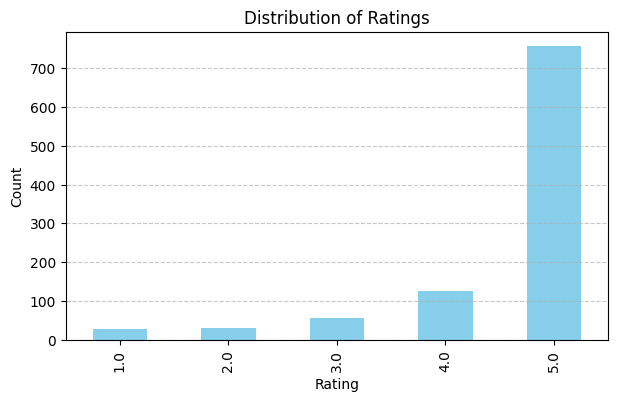

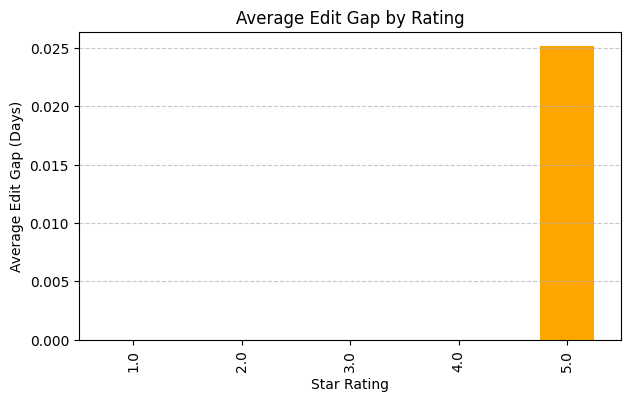


✅ Cleaned and analyzed data saved successfully at:
C:\Users\hp\Desktop\WEEK 3_DSHub\Final_Review_Analysis.csv


In [ ]:
# ==============================
# STEP 1: Import Dependencies
# ==============================
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

# ==============================
# STEP 2: Load Your CSV File
# ==============================
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\cleaned_Merged_Output_cleaned.csv"  # update if needed
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nPreview:\n", df.head())

# ==============================
# STEP 4: Clean & Convert Date Columns
# ==============================
for col in ['Review Submit Date and Time', 'Review Last Update Date and Time']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where both dates are missing
df = df.dropna(subset=['Review Submit Date and Time', 'Review Last Update Date and Time'], how='all')

# ==============================
# STEP 5: Calculate Time Difference (Editing Gap)
# ==============================
df['Edit_Gap_Days'] = (df['Review Last Update Date and Time'] - df['Review Submit Date and Time']).dt.days
df['Edit_Gap_Days'] = df['Edit_Gap_Days'].fillna(0)

# ==============================
# STEP 6: Clean & Normalize Rating Column
# ==============================
df['Star Rating'] = pd.to_numeric(df['Star Rating'], errors='coerce')
df = df[df['Star Rating'].between(1, 5)]


# ==============================
# STEP 8: Basic Descriptive Statistics
# ==============================
print("\n===== Rating Summary =====")
print(df['Star Rating'].describe())

print("\n===== Edit Gap Summary =====")
print(df['Edit_Gap_Days'].describe())

# ==============================
# STEP 9: Visualize Key Insights
# ==============================
# --- Ratings Distribution ---
plt.figure(figsize=(7,4))
df['Star Rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Average Edit Gap by Rating ---
plt.figure(figsize=(7,4))
df.groupby('Star Rating')['Edit_Gap_Days'].mean().plot(kind='bar', color='orange')
plt.title('Average Edit Gap by Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Edit Gap (Days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ==============================
# STEP 10: Export Cleaned Dataset
# ==============================
output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Final_Review_Analysis.csv"
df.to_csv(output_path, index=False, encoding='utf-8')
print(f"\n✅ Cleaned and analyzed data saved successfully at:\n{output_path}")


In [ ]:
df.head()

Package_Name  App Version Code  App Version Name  \
0  com.app.grow.greener.plants               4.0               1.3   
1  com.app.grow.greener.plants               NaN               NaN   
2  com.app.grow.greener.plants               4.0               1.3   
3  com.app.grow.greener.plants               NaN               NaN   
4  com.app.grow.greener.plants              13.0               2.2   

  Reviewer Language     Device Review Submit Date and Time  \
0                ru     RE588E   2024-07-02 12:46:52+00:00   
1                ru  RMX1993L1   2024-07-02 14:45:11+00:00   
2                es       a04e   2024-07-05 18:21:35+00:00   
3                pt    mdh15lm   2024-07-08 23:59:48+00:00   
4                pt        a10   2024-07-15 15:58:01+00:00   

   Review Submit Millis Since Epoch Review Last Update Date and Time  \
0                      1.719924e+12        2024-07-02 12:46:52+00:00   
1                      1.719932e+12        2024-07-02 14:45:11+00:00   
2                      1.720204e+12        2024-07-05 18:21:35+00:00   
3                      1.720483e+12        2024-07-08 23:59:48+00:00   
4                      1.721059e+12        2024-07-15 15:58:09+00:00   

   Review Last Update Millis Since Epoch  Star Rating  Review Title  \
0                           1.719924e+12          1.0           NaN   
1                           1.719932e+12          1.0           NaN   
2                           1.720204e+12          5.0           NaN   
3                           1.720483e+12          5.0           NaN   
4                           1.721059e+12          5.0           NaN   

        Review Text Developer Reply Date and Time  \
0               NaN                           NaN   
1       5 @01>B05B.                           NaN   
2               NaN                           NaN   
3               NaN                           NaN   
4  Ótimo aplicativo                           NaN   

  Developer Reply Millis Since Epoch Developer Reply Text  \
0                                NaN                  NaN   
1                                NaN                  NaN   
2                                NaN                  NaN   
3                                NaN                  NaN   
4                                NaN                  NaN   

                                         Review Link  Edit_Gap_Days  
0                                                NaN              0  
1  http://play.google.com/console/developers/5478...              0  
2                                                NaN              0  
3                                                NaN              0  
4  http://play.google.com/console/developers/5478...              0

**User Retention & Chun**

In [ ]:
#returning VS one-time users
user_activity = df.groupby('Device').size().reset_index(name='Review_Count')
user_activity

Device  Review_Count
0      1807             1
1      1808             1
2      1816             1
3      1820             2
4      1901             1
..      ...           ...
470   vince             2
471    viva             1
472   water             1
473  willow             2
474  zircon             1

[475 rows x 2 columns]

Users with Review_Count > 1 → retained users

Users with Review_Count == 1 → churned users (one-time reviewers)

In [ ]:
#Count and Tabulate Retained vs One-Time User

In [ ]:
import pandas as pd

# Load your cleaned CSV
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Final_Review_Analysis_Cleaned.csv"
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

# Ensure the key column exists
if 'Device' not in df.columns:
    raise ValueError("❌ 'Device' column not found in dataset!")

# Count number of reviews per device (user)
user_activity = df.groupby('Device').size().reset_index(name='Review_Count')

# Classify users
user_activity['User_Type'] = user_activity['Review_Count'].apply(
    lambda x: 'Retained (Reviewed > 1 time)' if x > 1 else 'One-time (Churned)'
)

# Tabulate summary
summary = user_activity['User_Type'].value_counts().reset_index()
summary.columns = ['User_Type', 'User_Count']

# Add retention rate
total_users = summary['User_Count'].sum()
summary['Percentage'] = (summary['User_Count'] / total_users * 100).round(2)

print("===== USER RETENTION & CHURN SUMMARY =====")
print(summary)

# Optional: Export to CSV
output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\User_Retention_Summary.csv"
summary.to_csv(output_path, index=False)
print(f"\n✅ Summary saved to: {output_path}")


===== USER RETENTION & CHURN SUMMARY =====
                      User_Type  User_Count  Percentage
0            One-time (Churned)         263       55.37
1  Retained (Reviewed > 1 time)         212       44.63

✅ Summary saved to: C:\Users\hp\Desktop\WEEK 3_DSHub\User_Retention_Summary.csv


===== USER RETENTION & CHURN SUMMARY =====
                      User_Type  User_Count  Percentage
0            One-time (Churned)         263       55.37
1  Retained (Reviewed > 1 time)         212       44.63


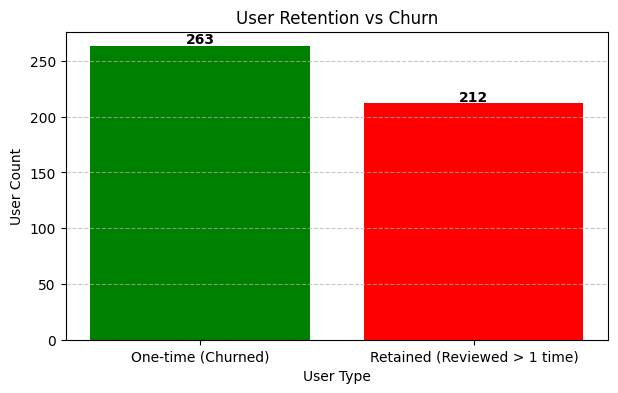

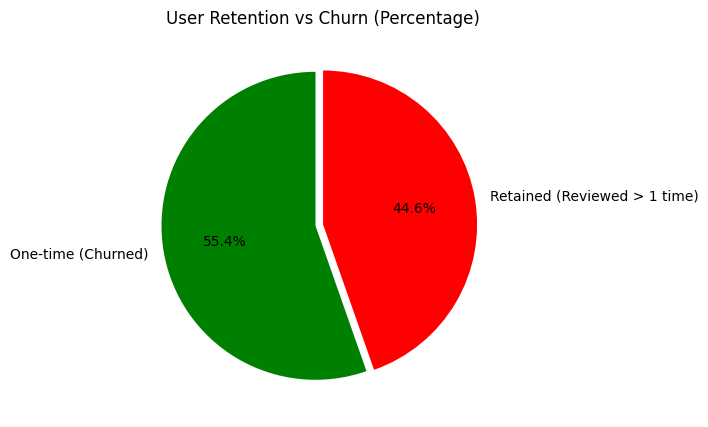


✅ Summary and charts generated successfully! File saved to:
C:\Users\hp\Desktop\WEEK 3_DSHub\User_Retention_Summary.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# STEP 1: Load Your Cleaned CSV
# ==============================
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Final_Review_Analysis_Cleaned.csv"
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

# ==============================
# STEP 2: Check for 'Device' Column
# ==============================
if 'Device' not in df.columns:
    raise ValueError("❌ 'Device' column not found in dataset!")

# ==============================
# STEP 3: Count Reviews per User (Device)
# ==============================
user_activity = df.groupby('Device').size().reset_index(name='Review_Count')

# ==============================
# STEP 4: Classify Users
# ==============================
user_activity['User_Type'] = user_activity['Review_Count'].apply(
    lambda x: 'Retained (Reviewed > 1 time)' if x > 1 else 'One-time (Churned)'
)

# ==============================
# STEP 5: Tabulate Summary
# ==============================
summary = user_activity['User_Type'].value_counts().reset_index()
summary.columns = ['User_Type', 'User_Count']

# Add retention percentage
total_users = summary['User_Count'].sum()
summary['Percentage'] = (summary['User_Count'] / total_users * 100).round(2)

print("===== USER RETENTION & CHURN SUMMARY =====")
print(summary)

# ==============================
# STEP 6: Visualization
# ==============================

# --- Bar Chart ---
plt.figure(figsize=(7,4))
plt.bar(summary['User_Type'], summary['User_Count'], color=['green', 'red'])
plt.title('User Retention vs Churn')
plt.xlabel('User Type')
plt.ylabel('User Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(summary['User_Count']):
    plt.text(i, v + (v * 0.01), str(v), ha='center', fontweight='bold')
plt.show()

# --- Pie Chart ---
plt.figure(figsize=(5,5))
plt.pie(summary['User_Count'], labels=summary['User_Type'], autopct='%1.1f%%',
        colors=['green', 'red'], startangle=90, explode=(0.05, 0))
plt.title('User Retention vs Churn (Percentage)')
plt.show()

# ==============================
# STEP 7: Export Summary
# ==============================
output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\User_Retention_Summary.csv"
summary.to_csv(output_path, index=False)
print(f"\n✅ Summary and charts generated successfully! File saved to:\n{output_path}")


In [ ]:
# Save as PNG
plt.savefig("sample_plot.png", dpi=300, bbox_inches='tight')

# Save as PDF
plt.savefig("sample_plot.pdf", bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [ ]:
#Install & Install Trends

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # prettier plots


In [ ]:
# Replace paths with your actual CSV file locations
csv_files = [
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install\install_july.csv",
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install_Aug.csv",
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install_sept.csv",
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install_oct.csv",
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install_nov.csv",
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install_dec.csv"
]


In [ ]:
cols_to_keep = ['Date', 'Package Name', 'Daily Device Installs', 'Daily Device Uninstalls', 'Daily Device Upgrades', 'Active Device Installs']


In [ ]:
import pandas as pd
import glob

# Folder containing your monthly CSVs (July–December)
path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install"

# Collect all CSVs in that folder
files = glob.glob(path + "/*.csv")

# Target columns to keep
cols_to_keep = [
    "Date", "Package Name", "Daily Device Installs",
    "Daily Device Uninstalls", "Total User Installs"
]

merged_data = []

for file in files:
    try:
        temp = pd.read_csv(file, encoding='utf-8', low_memory=False)
    except UnicodeDecodeError:
        temp = pd.read_csv(file, encoding='latin1', low_memory=False)

    # Normalize column names
    temp.columns = temp.columns.str.strip().str.lower()

    # Map possible column variations
    rename_map = {
        'package name': 'Package Name',
        'package_name': 'Package Name',
        'date': 'Date',
        'daily device installs': 'Daily Device Installs',
        'daily_device_installs': 'Daily Device Installs',
        'daily device uninstalls': 'Daily Device Uninstalls',
        'daily_device_uninstalls': 'Daily Device Uninstalls',
        'total user installs': 'Total User Installs',
        'total_user_installs': 'Total User Installs'
    }
    temp.rename(columns=rename_map, inplace=True)

    # Keep only required columns
    available_cols = [col for col in cols_to_keep if col in temp.columns]
    temp = temp[available_cols]

    # Add a column to track which month file this came from
    temp['Source_File'] = file.split("\\")[-1]

    merged_data.append(temp)

# Merge all months
df = pd.concat(merged_data, ignore_index=True)

# Clean date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Sort by date
df = df.sort_values(by='Date')

print("✅ Data merged successfully!")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMonths included:")
print(df['Source_File'].unique())

# Save cleaned merged file
output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Install_Uninstall_Data.csv"
df.to_csv(output_path, index=False, encoding='utf-8')
print(f"\n✅ Cleaned and merged data saved to:\n{output_path}")


✅ Data merged successfully!
Shape: (8776, 6)

Columns: ['Date', 'Package Name', 'Daily Device Installs', 'Daily Device Uninstalls', 'Total User Installs', 'Source_File']

Months included:
['install_Aug.csv' 'install_july.csv' 'install_sept.csv' 'install_oct.csv'
 'install_nov.csv' 'install_dec.csv']

✅ Cleaned and merged data saved to:
C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Install_Uninstall_Data.csv


In [ ]:
import pandas as pd
import glob

folder_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install.csv"
files = glob.glob(folder_path + "/*.csv")

for file in files:
    df = pd.read_csv(file, encoding='utf-8', low_memory=False)
    print(f"\n📂 {file}")
    print(df.columns.tolist())


In [ ]:
#verify all months are included

# Extract unique months and their record counts
merged_df["Month"] = merged_df["Date"].dt.month_name()
month_summary = merged_df["Month"].value_counts().sort_index()

print("\n===== MONTHLY DATA COVERAGE =====")
print(month_summary)
print("\n📆 Unique months found:", merged_df["Month"].unique())



===== MONTHLY DATA COVERAGE =====
Month
August       124
December     486
July        2482
November      30
October       31
Name: count, dtype: int64

📆 Unique months found: ['August' 'December' 'July' 'November' 'October']


In [ ]:
import os

folder_path =  r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install"  # adjust this
files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

print("All CSV files found:\n", files)


All CSV files found:
 ['install_Aug.csv', 'install_dec.csv', 'install_july.csv', 'install_nov.csv', 'install_oct.csv', 'install_sept.csv']


In [ ]:
pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Monthly_Data_Cleaned.csv", encoding='utf-8', low_memory=False)


Date                 Package name  Carrier  Daily Device Installs  \
0      7/2/2024  com.app.grow.greener.plants      NaN                    6.0   
1      7/2/2024  com.app.grow.greener.plants      NaN                    1.0   
2      7/2/2024  com.app.grow.greener.plants      NaN                    4.0   
3      7/2/2024  com.app.grow.greener.plants      NaN                    2.0   
4      7/2/2024  com.app.grow.greener.plants      NaN                    1.0   
...         ...                          ...      ...                    ...   
2470  7/31/2024  com.app.grow.greener.plants      NaN                    0.0   
2471  7/31/2024  com.app.grow.greener.plants      NaN                    0.0   
2472  7/31/2024  com.app.grow.greener.plants      NaN                    2.0   
2473  7/31/2024  com.app.grow.greener.plants      NaN                    0.0   
2474  7/31/2024  com.app.grow.greener.plants      NaN                    6.0   

      Daily Device Uninstalls  Daily Device Upgrades  Total User Installs  \
0                         0.0                    0.0                  0.0   
1                         0.0                    0.0                  0.0   
2                         0.0                    0.0                  0.0   
3                         0.0                    0.0                  0.0   
4                         0.0                    0.0                  0.0   
...                       ...                    ...                  ...   
2470                      0.0                    0.0                  0.0   
2471                      0.0                    0.0                  0.0   
2472                      0.0                    0.0                  0.0   
2473                      0.0                    0.0                  0.0   
2474                      0.0                    0.0                  0.0   

      Daily User Installs  Daily User Uninstalls  Active Device Installs  ...  \
0                     4.0                    3.0                     3.0  ...   
1                     1.0                    0.0                     1.0  ...   
2                     3.0                    9.0                     2.0  ...   
3                     1.0                    0.0                     1.0  ...   
4                     1.0                    0.0                     1.0  ...   
...                   ...                    ...                     ...  ...   
2470                  0.0                    0.0                     1.0  ...   
2471                  0.0                    0.0                     1.0  ...   
2472                  2.0                    3.0                    27.0  ...   
2473                  0.0                    0.0                     2.0  ...   
2474                  8.0                    5.0                    27.0  ...   

      Uninstall events         Month  Android OS Version Country  \
0                  4.0  Install_july                 NaN      BG   
1                  0.0  Install_july                 NaN      BR   
2                  9.0  Install_july                 NaN      DE   
3                  0.0  Install_july                 NaN      HU   
4                  0.0  Install_july                 NaN      MY   
...                ...           ...                 ...     ...   
2470               0.0  Install_july                 NaN      XK   
2471               0.0  Install_july                 NaN      YE   
2472               4.0  Install_july                 NaN      ZA   
2473               0.0  Install_july                 NaN      ZM   
2474               5.0  Install_july                 NaN      ZZ   

      Package Name Daily Crashes  Daily ANRs  App Version Code  Source_File  \
0              NaN           NaN         NaN               NaN          NaN   
1              NaN           NaN         NaN               NaN          NaN   
2              NaN           NaN         NaN               NaN          NaN   
3              NaN 

In [ ]:
print("===== MONTHLY DATA COVERAGE =====")
print(merged_df['Month'].value_counts())
print("\n📆 Unique months found:", merged_df['Month'].unique())


===== MONTHLY DATA COVERAGE =====
Month
Install_aug     5685
Install_july    2482
Install_dec      486
Install_sept      62
Install_oct       31
Install_nov       30
Name: count, dtype: int64

📆 Unique months found: ['Install_aug' 'Install_dec' 'Install_july' 'Install_nov' 'Install_oct'
 'Install_sept']


In [ ]:
import pandas as pd
import glob

path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install"
files = glob.glob(path + "/*.csv")

merged_data = []

for file in files:
    df = pd.read_csv(file, encoding='latin1', low_memory=False)

    # Optional: Extract month from filename
    month_name = os.path.basename(file).split('.')[0]  # Example: "September"
    df['Month'] = month_name.capitalize()

    merged_data.append(df)

# Combine all
merged_df = pd.concat(merged_data, ignore_index=True)


In [ ]:
for file in files:
    df = pd.read_csv(file, encoding='latin1', low_memory=False)
    print(os.path.basename(file), "→", len(df), "rows")


install_Aug.csv → 5685 rows
install_dec.csv → 486 rows
install_july.csv → 2482 rows
install_nov.csv → 30 rows
install_oct.csv → 31 rows
install_sept.csv → 62 rows


In [ ]:
print("Total merged rows:", len(merged_df))


Total merged rows: 17552


In [ ]:
import os
import pandas as pd
import glob

# 🔹 Set your folder path
path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\install" # change this to your actual folder

# 🔹 Find all CSV files in the folder
files = glob.glob(os.path.join(path, "*.csv"))

# 🔹 Print all detected files with row counts
print("===== FILES INCLUDED IN MERGE =====")
for file in files:
    try:
        temp = pd.read_csv(file, encoding='latin1', low_memory=False)
        print(f"{os.path.basename(file):<30} | Rows: {len(temp)}")
    except Exception as e:
        print(f"{os.path.basename(file):<30} | ⚠️ Error reading file: {e}")

# 🔹 Check the unique months in the final merged dataframe (if you already merged)
print("\n===== MONTHS PRESENT IN MERGED DATA =====")
print(merged_df['Month'].value_counts())
print("\n📆 Unique months found:", merged_df['Month'].unique())


===== FILES INCLUDED IN MERGE =====
install_Aug.csv                | Rows: 5685
install_dec.csv                | Rows: 486
install_july.csv               | Rows: 2482
install_nov.csv                | Rows: 30
install_oct.csv                | Rows: 31
install_sept.csv               | Rows: 62

===== MONTHS PRESENT IN MERGED DATA =====
Month
Install_aug     5685
Install_july    2482
Install_dec      486
Install_sept      62
Install_oct       31
Install_nov       30
Name: count, dtype: int64

📆 Unique months found: ['Install_aug' 'Install_dec' 'Install_july' 'Install_nov' 'Install_oct'
 'Install_sept']


In [ ]:
# 🔹 Set your output path (update to your folder)
output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Monthly_Data.csv"

# 🔹 Save the merged dataframe
merged_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ Merged CSV saved successfully at:\n{output_path}")


✅ Merged CSV saved successfully at:
C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Monthly_Data.csv


**Monthly Trend Analysis of Install& Uninstall**



===== Daily Summary =====
                      Date  Daily Device Installs  Daily Device Uninstalls
count                   30              30.000000                     30.0
mean   2024-07-16 12:00:00            1450.833333                      0.0
min    2024-07-02 00:00:00              14.000000                      0.0
25%    2024-07-09 06:00:00              25.500000                      0.0
50%    2024-07-16 12:00:00            1173.000000                      0.0
75%    2024-07-23 18:00:00            2644.750000                      0.0
max    2024-07-31 00:00:00            4308.000000                      0.0
std                    NaN            1522.512920                      0.0


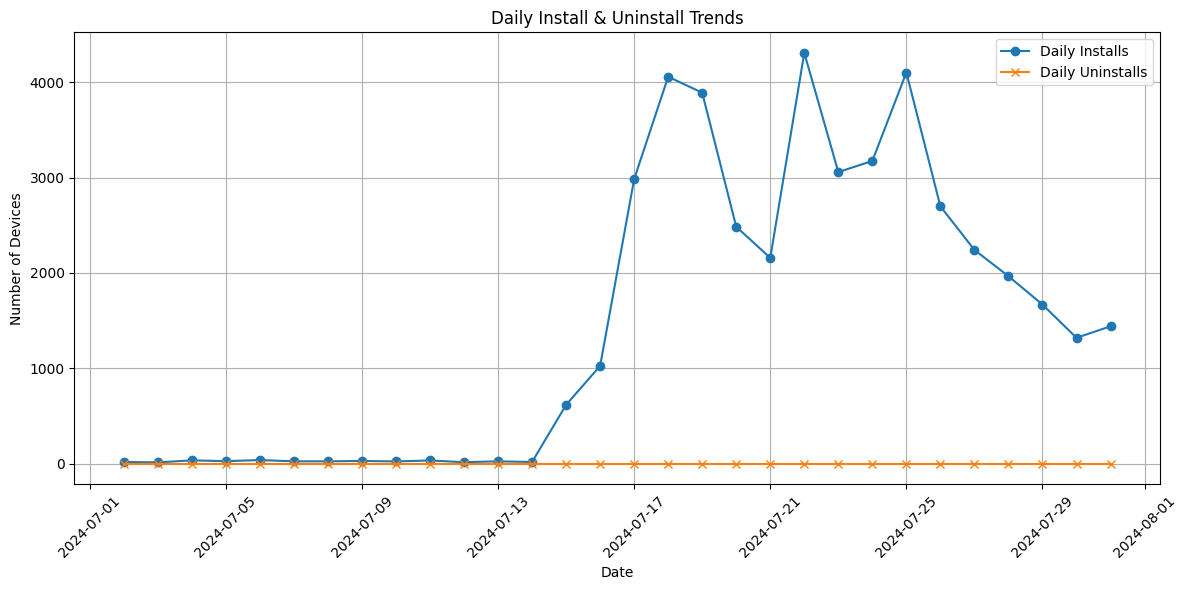

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# Step 1: Load & Clean Data
# ==============================
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Monthly_Data_Cleaned.csv"
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Keep only relevant columns
df = df[['Date', 'Daily Device Installs', 'Daily Device Uninstalls']]

# Remove NaN and duplicates
df.dropna(subset=['Date', 'Daily Device Installs', 'Daily Device Uninstalls'], inplace=True)
df.drop_duplicates(inplace=True)

# ==============================
# Step 2: Daily Trend Analysis
# ==============================
daily_summary = df.groupby('Date')[['Daily Device Installs', 'Daily Device Uninstalls']].sum().reset_index()
print("\n===== Daily Summary =====")
print(daily_summary.describe())

# Plot daily trends
plt.figure(figsize=(12,6))
plt.plot(daily_summary['Date'], daily_summary['Daily Device Installs'], label='Daily Installs', marker='o')
plt.plot(daily_summary['Date'], daily_summary['Daily Device Uninstalls'], label='Daily Uninstalls', marker='x')
plt.title('Daily Install & Uninstall Trends')
plt.xlabel('Date')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


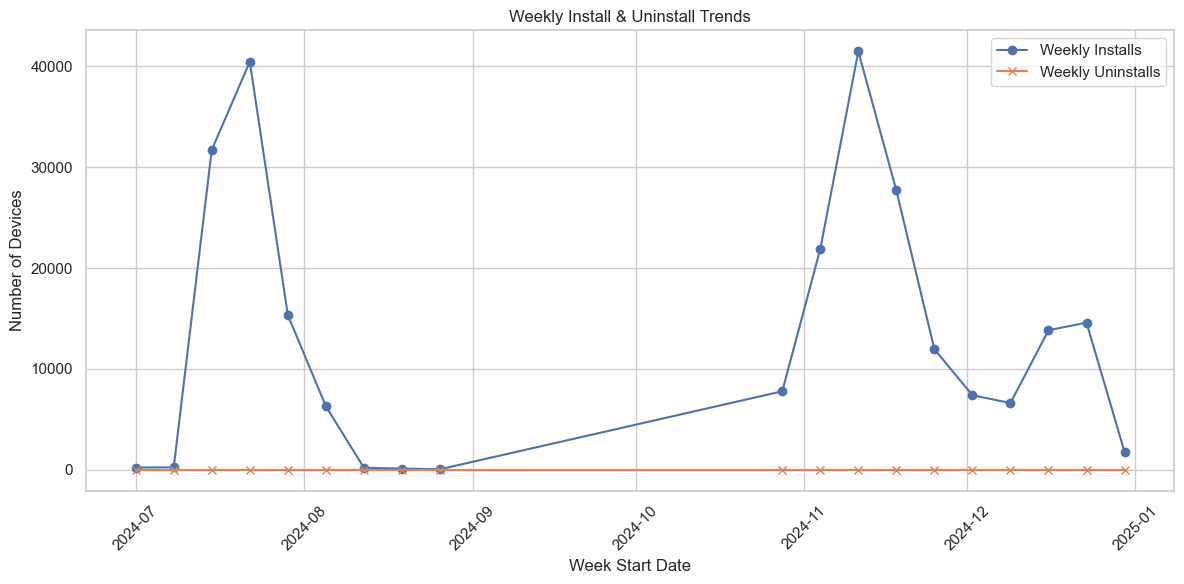

In [ ]:
# Step 3: Weekly Trend Analysis
# ==============================
df['Year_Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_summary = df.groupby('Year_Week')[['Daily Device Installs', 'Daily Device Uninstalls']].sum().reset_index()

# Plot weekly trends
plt.figure(figsize=(12,6))
plt.plot(weekly_summary['Year_Week'], weekly_summary['Daily Device Installs'], label='Weekly Installs', marker='o')
plt.plot(weekly_summary['Year_Week'], weekly_summary['Daily Device Uninstalls'], label='Weekly Uninstalls', marker='x')
plt.title('Weekly Install & Uninstall Trends')
plt.xlabel('Week Start Date')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

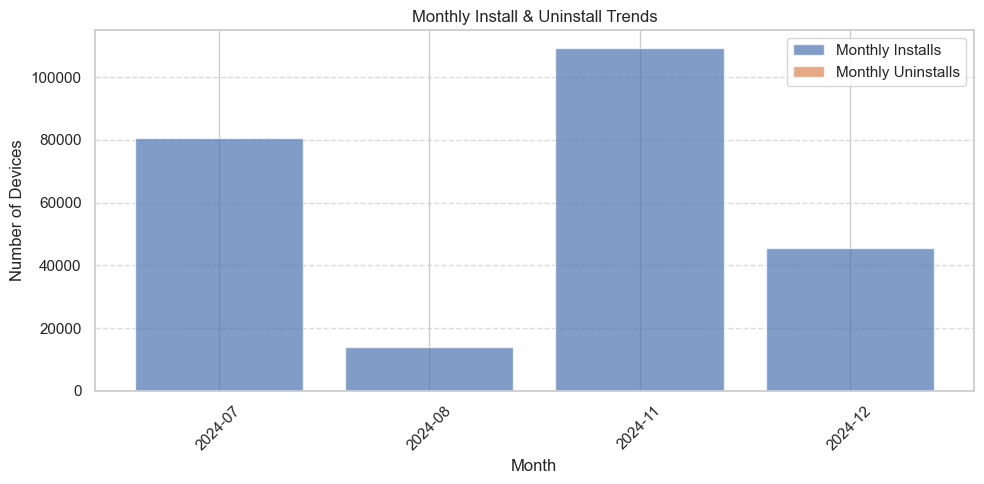

In [ ]:
# ==============================
# Step 4: Monthly Trend Analysis (Calendar Month)
# ==============================
df['Year_Month'] = df['Date'].dt.to_period('M').astype(str)
monthly_summary = df.groupby('Year_Month')[['Daily Device Installs', 'Daily Device Uninstalls']].sum().reset_index()

# Plot monthly trends
plt.figure(figsize=(10,5))
plt.bar(monthly_summary['Year_Month'], monthly_summary['Daily Device Installs'], label='Monthly Installs', alpha=0.7)
plt.bar(monthly_summary['Year_Month'], monthly_summary['Daily Device Uninstalls'], label='Monthly Uninstalls', alpha=0.7)
plt.title('Monthly Install & Uninstall Trends')
plt.xlabel('Month')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ==============================
# Step 5: Statistical Summary
# ==============================
print("\n===== Statistical Summary =====")
print("Daily Installs & Uninstalls:")
print(daily_summary[['Daily Device Installs', 'Daily Device Uninstalls']].describe())
print("\nWeekly Installs & Uninstalls:")
print(weekly_summary[['Daily Device Installs', 'Daily Device Uninstalls']].describe())
print("\nMonthly Installs & Uninstalls:")
print(monthly_summary[['Daily Device Installs', 'Daily Device Uninstalls']].describe())


===== Statistical Summary =====
Daily Installs & Uninstalls:
       Daily Device Installs  Daily Device Uninstalls
count             122.000000                    122.0
mean             2047.639344                      0.0
std              2176.634012                      0.0
min                 6.000000                      0.0
25%                40.000000                      0.0
50%              1451.000000                      0.0
75%              2899.000000                      0.0
max              8301.000000                      0.0

Weekly Installs & Uninstalls:
       Daily Device Installs  Daily Device Uninstalls
count              19.000000                     19.0
mean            13148.000000                      0.0
std             13572.012771                      0.0
min                55.000000                      0.0
25%              1011.000000                      0.0
50%              7789.000000                      0.0
75%             18626.000000               

**Country/region-based usage distribution**

*Prepare a mapping of country codes to full names*

In [ ]:
pip install pycountry


In [ ]:
import pandas as pd
import pycountry

# ==============================
# STEP 1: Load your merged CSV
# ==============================
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Monthly_Data.csv"
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

# ==============================
# STEP 2: Remove rows with empty Country
# ==============================
df = df[df['Country'].notna() & (df['Country'].str.strip() != '')]

# ==============================
# STEP 3: Map country codes to full names
# ==============================
def code_to_country(code):
    try:
        return pycountry.countries.get(alpha_2=code.upper()).name
    except:
        return code  # fallback if code not found

df['Country_Full'] = df['Country'].apply(code_to_country)

# ==============================
# STEP 4: Save updated CSV
# ==============================
output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Monthly_Data_Cleaned.csv"
df.to_csv(output_path, index=False, encoding='utf-8')
print(f"✅ Updated CSV saved at:\n{output_path}")

# Optional preview
print(df[['Country', 'Country_Full']].head())


✅ Updated CSV saved at:
C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Monthly_Data_Cleaned.csv
     Country Country_Full
6171      BG     Bulgaria
6172      BR       Brazil
6173      DE      Germany
6174      HU      Hungary
6175      MY     Malaysia


In [ ]:
df.head()

Date                 Package name Carrier  Daily Device Installs  \
6171  7/2/2024  com.app.grow.greener.plants     NaN                    6.0   
6172  7/2/2024  com.app.grow.greener.plants     NaN                    1.0   
6173  7/2/2024  com.app.grow.greener.plants     NaN                    4.0   
6174  7/2/2024  com.app.grow.greener.plants     NaN                    2.0   
6175  7/2/2024  com.app.grow.greener.plants     NaN                    1.0   

      Daily Device Uninstalls  Daily Device Upgrades  Total User Installs  \
6171                      0.0                    0.0                  0.0   
6172                      0.0                    0.0                  0.0   
6173                      0.0                    0.0                  0.0   
6174                      0.0                    0.0                  0.0   
6175                      0.0                    0.0                  0.0   

      Daily User Installs  Daily User Uninstalls  Active Device Installs  ...  \
6171                  4.0                    3.0                     3.0  ...   
6172                  1.0                    0.0                     1.0  ...   
6173                  3.0                    9.0                     2.0  ...   
6174                  1.0                    0.0                     1.0  ...   
6175                  1.0                    0.0                     1.0  ...   

      Uninstall events         Month  Android OS Version Country  \
6171               4.0  Install_july                 NaN      BG   
6172               0.0  Install_july                 NaN      BR   
6173               9.0  Install_july                 NaN      DE   
6174               0.0  Install_july                 NaN      HU   
6175               0.0  Install_july                 NaN      MY   

      Package Name Daily Crashes Daily ANRs  App Version Code  Source_File  \
6171           NaN           NaN        NaN               NaN          NaN   
6172           NaN           NaN        NaN               NaN          NaN   
6173           NaN           NaN        NaN               NaN          NaN   
6174           NaN           NaN        NaN               NaN          NaN   
6175           NaN           NaN        NaN               NaN          NaN   

      Country_Full  
6171      Bulgaria  
6172        Brazil  
6173       Germany  
6174       Hungary  
6175      Malaysia  

[5 rows x 22 columns]

**region-based usage distribution based on installation events**

In [ ]:
import pandas as pd

# Assuming your output DataFrame is named 'df'
# (replace 'df' with your actual DataFrame name)

output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Monthly_Data_Cleaned.csv"  # 👈 change this to your preferred location

# Save the DataFrame to CSV
df.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ CSV file successfully saved to:\n{output_path}")


✅ CSV file successfully saved to:
C:\Users\hp\Desktop\WEEK 3_DSHub\Merged_Monthly_Data_Cleaned.csv


In [ ]:
df.head()

country country_full  install_events Year_Month         Region
0      BG     Bulgaria             7.0    2024-02          Other
1      BR       Brazil             1.0    2024-02  South America
2      DE      Germany            11.0    2024-02         Europe
3      HU      Hungary             2.0    2024-02          Other
4      MY     Malaysia             1.0    2024-02          Other

✅ File loaded. Shape: (2475, 22)

📋 Columns available:
['date', 'package_name', 'carrier', 'daily_device_installs', 'daily_device_uninstalls', 'daily_device_upgrades', 'total_user_installs', 'daily_user_installs', 'daily_user_uninstalls', 'active_device_installs', 'install_events', 'update_events', 'uninstall_events', 'month', 'android_os_version', 'country', 'package_name', 'daily_crashes', 'daily_anrs', 'app_version_code', 'source_file', 'country_full']

🔍 Possible date columns: ['date', 'update_events']

Sample date values:
0    7/2/2024
1    7/2/2024
2    7/2/2024
3    7/2/2024
4    7/2/2024
5    7/2/2024
6    7/2/2024
7    7/3/2024
8    7/3/2024
9    7/3/2024
Name: date, dtype: object

✅ Dates cleaned. Total valid rows: 293

📆 Unique months found after cleaning:
['2024-02' '2024-03' '2024-04' '2024-05' '2024-06' '2024-07' '2024-08'
 '2024-09' '2024-10' '2024-11' '2024-12']

🗓️ Months appearing in grouped data:
['2024-02' '2024-03' '2024-04' '2024-05' '2024-06' '2024-07' '2024-08'


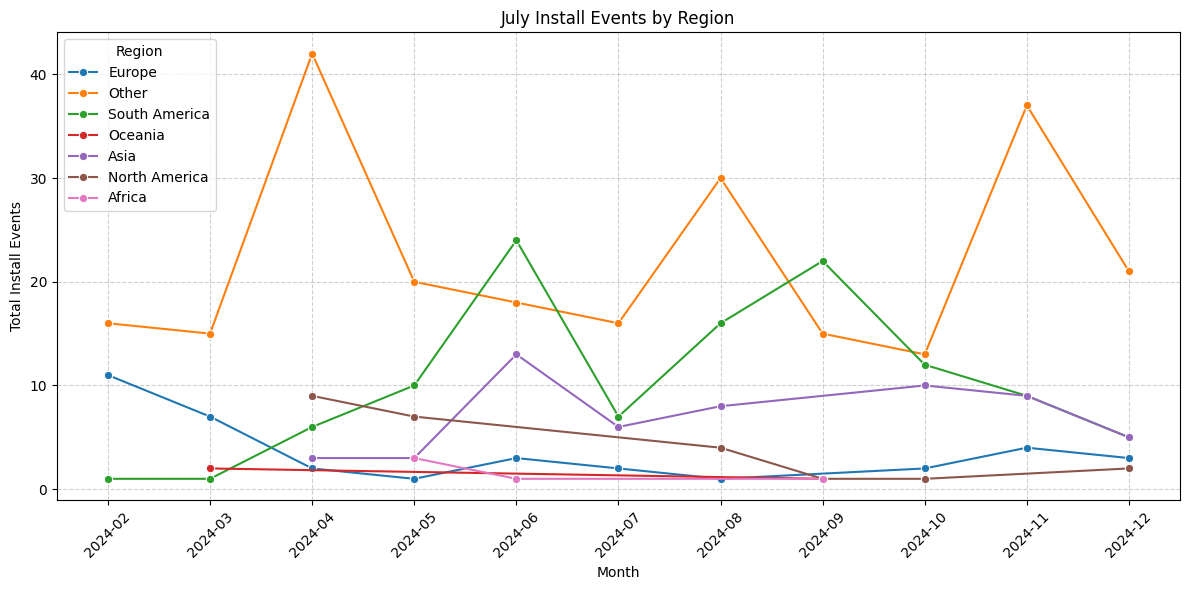


✅ Cleaned data with proper dates saved to:
C:\Users\hp\Desktop\WEEK 3_DSHub\Cleaned_Region_Trend_Analysis.csv


In [ ]:
# ===========================================
# STEP 1: Import Libraries
# ===========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================================
# STEP 2: Load Dataset
# ===========================================
file_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\July_data.csv"
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
print("✅ File loaded. Shape:", df.shape)

# ===========================================
# STEP 3: Normalize Column Names
# ===========================================
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Check available columns
print("\n📋 Columns available:")
print(df.columns.tolist())

# ===========================================
# STEP 4: Diagnose the Date Column
# ===========================================
# Try to find the column that holds date information
possible_dates = [col for col in df.columns if 'date' in col]
print("\n🔍 Possible date columns:", possible_dates)

# If there's a 'date' column, inspect unique formats
date_col = possible_dates[0] if possible_dates else None
if not date_col:
    raise ValueError("No 'date' column found. Please verify your dataset.")

print("\nSample date values:")
print(df[date_col].head(10))

# ===========================================
# STEP 5: Clean and Convert Date
# ===========================================
# Try to convert; if fails, coerce to NaT
df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True)

# If some are still NaT, try parsing as Excel serial or text
if df[date_col].isna().sum() > 0:
    try:
        df[date_col] = pd.to_datetime(df[date_col].astype(float), origin='1899-12-30', unit='D')
    except:
        pass

# Drop rows without valid dates
df = df.dropna(subset=[date_col])
print(f"\n✅ Dates cleaned. Total valid rows: {len(df)}")

# ===========================================
# STEP 6: Extract Month and Year
# ===========================================
df['Year_Month'] = df[date_col].dt.to_period('M').astype(str)

print("\n📆 Unique months found after cleaning:")
print(df['Year_Month'].unique())

# ===========================================
# STEP 7: Clean and Prepare for Analysis
# ===========================================
# Keep only relevant columns
columns_needed = ['country', 'country_full', 'install_events', 'Year_Month']
available_cols = [col for col in columns_needed if col in df.columns]
df = df[available_cols]

# Convert installs to numeric
df['install_events'] = pd.to_numeric(df['install_events'], errors='coerce')
df = df.dropna(subset=['install_events'])
df = df[df['install_events'] > 0]

# ===========================================
# STEP 8: Region Mapping
# ===========================================
region_mapping = {
    "Nigeria": "Africa", "Kenya": "Africa", "Ghana": "Africa", "South Africa": "Africa", "Egypt": "Africa",
    "Germany": "Europe", "France": "Europe", "United Kingdom": "Europe", "Spain": "Europe", "Italy": "Europe",
    "India": "Asia", "China": "Asia", "Japan": "Asia", "Indonesia": "Asia", "Philippines": "Asia", "Singapore": "Asia",
    "United States": "North America", "Canada": "North America", "Mexico": "North America",
    "Brazil": "South America", "Argentina": "South America", "Chile": "South America",
    "Australia": "Oceania", "New Zealand": "Oceania"
}
df['Region'] = df['country_full'].map(region_mapping).fillna('Other')

# ===========================================
# STEP 9: Group by Month & Region
# ===========================================
monthly_region = df.groupby(['Year_Month', 'Region'])['install_events'].sum().reset_index()

# ===========================================
# STEP 10: Validate Month Coverage
# ===========================================
print("\n🗓️ Months appearing in grouped data:")
print(monthly_region['Year_Month'].unique())

# ===========================================
# STEP 11: Visualization
# ===========================================
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_region, x='Year_Month', y='install_events', hue='Region', marker='o')
plt.title("July Install Events by Region")
plt.xlabel("Month")
plt.ylabel("Total Install Events")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ===========================================
# STEP 12: Save Cleaned File
# ===========================================
output_path = r"C:\Users\hp\Desktop\WEEK 3_DSHub\Cleaned_Region_Trend_Analysis.csv"
df.to_csv(output_path, index=False)
print(f"\n✅ Cleaned data with proper dates saved to:\n{output_path}")


**App Performance Analysis**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSV files ===
df_2024 = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2024.csv")
df_2025 = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2025.csv")

# === Ensure Date column is datetime ===
df_2024['Date'] = pd.to_datetime(df_2024['Date'], errors='coerce')
df_2025['Date'] = pd.to_datetime(df_2025['Date'], errors='coerce')

# === Add Year & Month columns ===
df_2024['Year'] = df_2024['Date'].dt.year
df_2024['Month'] = df_2024['Date'].dt.month_name()

df_2025['Year'] = df_2025['Date'].dt.year
df_2025['Month'] = df_2025['Date'].dt.month_name()

# Confirm structure
print(df_2024.head())
print(df_2025.head())


        Date                 Package Name  Android OS Version  Daily Crashes  \
0 2024-07-05  com.app.grow.greener.plants                 NaN            0.0   
1 2024-07-08  com.app.grow.greener.plants                 NaN            0.0   
2 2024-07-10  com.app.grow.greener.plants                 NaN            1.0   
3 2024-07-11  com.app.grow.greener.plants                 NaN            1.0   
4 2024-07-15  com.app.grow.greener.plants                 NaN            0.0   

   Daily ANRs Month                                      Device  Year  
0         1.0  July        TECNO TECNO-KI7 (TECNO SPARK 10 Pro)  2024  
1         1.0  July                    samsung a13 (Galaxy A13)  2024  
2         0.0  July                    HONOR HNVNE-M (HONOR X6)  2024  
3         0.0  July  Lenovo X306X (Lenovo Tab M10 HD (2nd Gen))  2024  
4         1.0  July           TECNO TECNO-KG6P (TECNO SPARK 8T)  2024  
        Date                 Package Name Android OS Version  Daily Crashes  \
0 2025-0

In [ ]:
import pandas as pd
import re

# Load your CSV file
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2024.csv")

# Define a function to clean and extract device names
def clean_device_name(device):
    if pd.isna(device):
        return ""  # avoid NaN output
    # Try to extract text within parentheses
    match = re.search(r"\((.*?)\)", device)
    if match:
        cleaned = match.group(1).strip()
    else:
        # If no parentheses, use the part before or entire text
        cleaned = device.strip()
    # Remove extra spaces and ensure distinct clean format
    cleaned = re.sub(r"\s+", " ", cleaned)
    return cleaned

# Apply the function to the Device column
df["Cleaned_Device"] = df["Device"].apply(clean_device_name)

# Drop duplicates and reset index (optional, for analysis)
df = df.drop_duplicates(subset=["Cleaned_Device"]).reset_index(drop=True)

# Replace any remaining NaN values with blank strings
df["Cleaned_Device"] = df["Cleaned_Device"].fillna("")

# Save cleaned data to a new file
df.to_csv("Cleaned_Device_Data.csv", index=False)

print("✅ Cleaning complete! File saved as 'Cleaned_Device_Data.csv'")
print(df[["Device", "Cleaned_Device"]].head())


✅ Cleaning complete! File saved as 'Cleaned_Device_Data.csv'
                                       Device              Cleaned_Device
0        TECNO TECNO-KI7 (TECNO SPARK 10 Pro)          TECNO SPARK 10 Pro
1                    samsung a13 (Galaxy A13)                  Galaxy A13
2                    HONOR HNVNE-M (HONOR X6)                    HONOR X6
3  Lenovo X306X (Lenovo Tab M10 HD (2nd Gen))  Lenovo Tab M10 HD (2nd Gen
4           TECNO TECNO-KG6P (TECNO SPARK 8T)              TECNO SPARK 8T


In [ ]:
import pandas as pd
import re

# Load your CSV file
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2025.csv")

# Define a function to clean and extract device names
def clean_device_name(device):
    if pd.isna(device):
        return ""  # avoid NaN output
    # Try to extract text within parentheses
    match = re.search(r"\((.*?)\)", device)
    if match:
        cleaned = match.group(1).strip()
    else:
        # If no parentheses, use the part before or entire text
        cleaned = device.strip()
    # Remove extra spaces and ensure distinct clean format
    cleaned = re.sub(r"\s+", " ", cleaned)
    return cleaned

# Apply the function to the Device column
df["Cleaned_Device"] = df["Device"].apply(clean_device_name)

# Drop duplicates and reset index (optional, for analysis)
df = df.drop_duplicates(subset=["Cleaned_Device"]).reset_index(drop=True)

# Replace any remaining NaN values with blank strings
df["Cleaned_Device"] = df["Cleaned_Device"].fillna("")

# Save cleaned data to a new file
df.to_csv("Cleaned_Device_Data.csv", index=False)

print("✅ Cleaning complete! File saved as 'Cleaned_Device_Data.csv'")
print(df[["Device", "Cleaned_Device"]].head())


✅ Cleaning complete! File saved as 'Cleaned_Device_Data.csv'
          Device Cleaned_Device
0            NaN               
1           1902           1902
2        HWDUB-Q        HWDUB-Q
3  Infinix-X6516  Infinix-X6516
4  Infinix-X665C  Infinix-X665C


**Retention/Chun**

In [ ]:
def retention_churn_analysis(df, year):
    df = df.copy()
    df = df.sort_values(by='Date')

    # Group all devices by month
    month_device = df.groupby('Month')['Device'].apply(set).reset_index()

    summary = []
    prev_devices = set()

    for i, row in month_device.iterrows():
        month = row['Month']
        current_devices = row['Device']

        new_users = len(current_devices - prev_devices)
        retained_users = len(current_devices & prev_devices)
        churned_users = len(prev_devices - current_devices)
        total_active = len(current_devices)

        retention_rate = (retained_users / (retained_users + new_users) * 100) if (retained_users + new_users) > 0 else 0
        churn_rate = (churned_users / (len(prev_devices) + 1e-9) * 100) if len(prev_devices) > 0 else 0

        summary.append({
            'Year': year,
            'Month': month,
            'Total Active Devices': total_active,
            'New Devices': new_users,
            'Retained Devices': retained_users,
            'Churned Devices': churned_users,
            'Retention Rate (%)': round(retention_rate, 2),
            'Churn Rate (%)': round(churn_rate, 2)
        })

        prev_devices = current_devices

    return pd.DataFrame(summary)


In [ ]:
retention_2024 = retention_churn_analysis(df_2024, 2024)
retention_2025 = retention_churn_analysis(df_2025, 2025)

# Combine summaries
combined_retention = pd.concat([retention_2024, retention_2025])
combined_retention.reset_index(drop=True, inplace=True)
combined_retention


Year     Month  Total Active Devices  New Devices  Retained Devices  \
0  2024      July                   782          782                 0   
1  2025  February                     1            1                 0   
2  2025       May                   156          156                 0   

   Churned Devices  Retention Rate (%)  Churn Rate (%)  
0                0                 0.0             0.0  
1                0                 0.0             0.0  
2                1                 0.0           100.0

In [ ]:
df_2024 = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2024.csv", encoding='utf-8', parse_dates=['Date'], dayfirst=True)
df_2025 = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2025.csv", encoding='utf-8', parse_dates=['Date'], dayfirst=True)


In [ ]:
print(df_2024['Date'].head(10))


0    2024-07-05
1    2024-07-08
2    2024-07-10
3    2024-07-11
4    2024-07-15
5    2024-07-15
6    2024-07-15
7    2024-07-15
8    2024-07-15
9    2024-07-15
Name: Date, dtype: object


**monthly-level (July) retention/churn analysis based on Device activity**

In [ ]:
import pandas as pd

df_2024 = pd.read_csv(
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2024.csv",
    encoding='utf-8'
)

# Show the first 10 unique date entries and column names
print("📋 Columns:", df_2024.columns.tolist())
print("\n🔍 Sample date values:")
print(df_2024['Date'].head(10))


📋 Columns: ['Date', 'Package Name', 'Android OS Version', 'Daily Crashes', 'Daily ANRs', 'Month', 'Device', 'Year']

🔍 Sample date values:
0    2024-07-05
1    2024-07-08
2    2024-07-10
3    2024-07-11
4    2024-07-15
5    2024-07-15
6    2024-07-15
7    2024-07-15
8    2024-07-15
9    2024-07-15
Name: Date, dtype: object



 Daily Retention & Churn (July 2024):
                                Date  Active_Devices  Retention_Rate_%  \
count                             21       21.000000         21.000000   
mean   2024-07-20 05:42:51.428571392      133.476190         56.532700   
min              2024-07-05 00:00:00        1.000000        -11.173184   
25%              2024-07-16 00:00:00       31.000000         -7.291667   
50%              2024-07-21 00:00:00      178.000000          0.000000   
75%              2024-07-26 00:00:00      195.000000         19.018405   
max              2024-07-31 00:00:00      238.000000        500.000000   
std                              NaN       87.277499        141.029997   

       Churn_Rate_%  
count     21.000000  
mean       2.763988  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        7.291667  
max       11.173184  
std        4.323564  


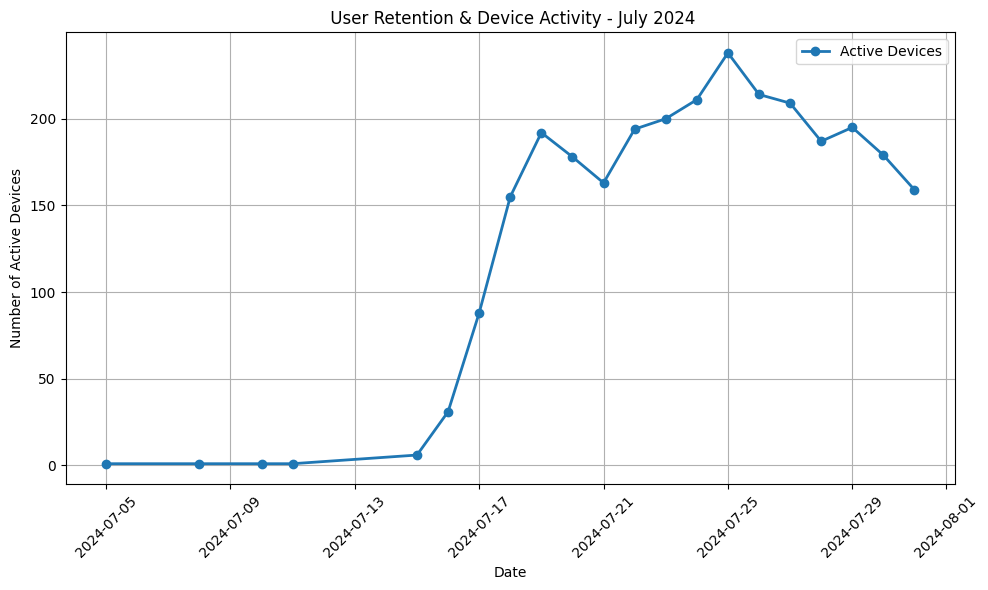

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df_2024 = pd.read_csv(
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2024.csv",
    encoding='utf-8'
)

# Convert Date column to datetime
df_2024['Date'] = pd.to_datetime(df_2024['Date'], errors='coerce')

#  Filter only July 2024 data
df_july_2024 = df_2024[(df_2024['Date'].dt.month == 7) & (df_2024['Date'].dt.year == 2024)]

# Drop missing or invalid device entries
df_july_2024 = df_july_2024.dropna(subset=['Device'])

# Calculate active devices per day
daily_devices = df_july_2024.groupby('Date')['Device'].nunique().reset_index(name='Active_Devices')

# Calculate Retention Rate (% change from previous day)
daily_devices['Retention_Rate_%'] = daily_devices['Active_Devices'].pct_change().fillna(0) * 100

# Calculate simple churn (negative of retention if drop)
daily_devices['Churn_Rate_%'] = daily_devices['Retention_Rate_%'].apply(lambda x: abs(x) if x < 0 else 0)

# Display summary
print("\n Daily Retention & Churn (July 2024):")
print(daily_devices.describe())

# Plot
plt.figure(figsize=(10,6))
plt.plot(daily_devices['Date'], daily_devices['Active_Devices'], marker='o', label='Active Devices', linewidth=2)
plt.title(" User Retention & Device Activity - July 2024")
plt.xlabel("Date")
plt.ylabel("Number of Active Devices")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Unique Year-Months in 2025 data: <PeriodArray>
['2025-05']
Length: 1, dtype: period[M]

 Daily Retention & Churn Statistics (2025):
                      Date  Active_Devices  Retention_Rate_%  Churn_Rate_%
count                   11       11.000000         11.000000     11.000000
mean   2025-05-06 00:00:00       25.454545         15.118602      6.090092
min    2025-05-01 00:00:00       10.000000        -41.176471      0.000000
25%    2025-05-03 12:00:00       17.500000         -7.644110      0.000000
50%    2025-05-06 00:00:00       19.000000          1.923077      0.000000
75%    2025-05-08 12:00:00       27.500000         34.803922      7.644110
max    2025-05-11 00:00:00       53.000000         80.000000     41.176471
std                    NaN       14.514569         37.347213     12.376602


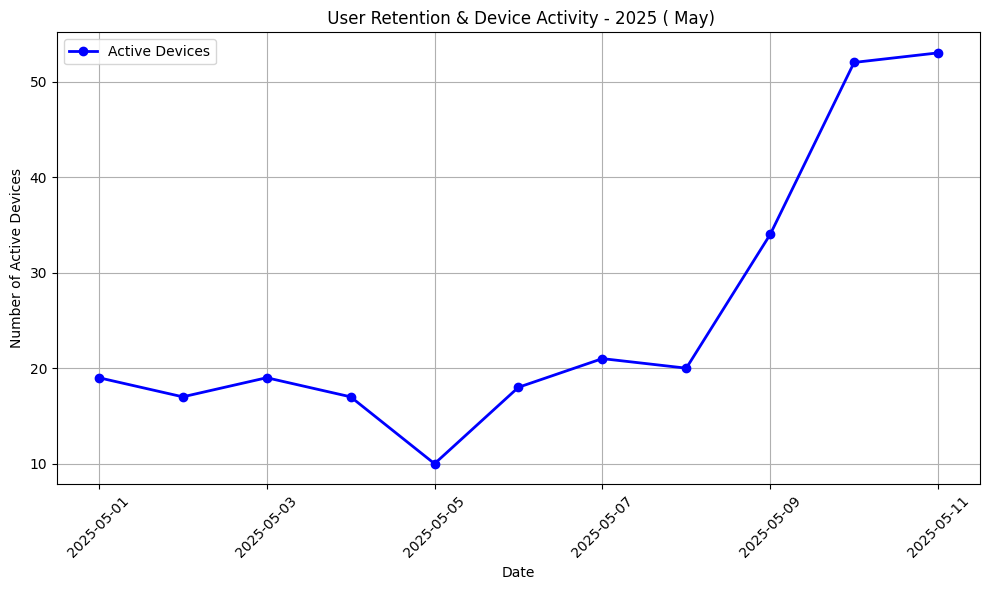

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load 2025 dataset
df_2025 = pd.read_csv(
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2025.csv",
    encoding='utf-8'
)

# Convert 'Date' to datetime (format: Month-Day-Year)
df_2025['Date'] = pd.to_datetime(df_2025['Date'], errors='coerce')

# Drop invalid dates and devices
df_2025 = df_2025.dropna(subset=['Date', 'Device'])

# Add Month-Year column
df_2025['YearMonth'] = df_2025['Date'].dt.to_period('M')

print(" Unique Year-Months in 2025 data:", df_2025['YearMonth'].unique())

# Group by Date to count active devices per day
daily_devices_2025 = df_2025.groupby('Date')['Device'].nunique().reset_index(name='Active_Devices')

# Compute Retention and Churn rates
daily_devices_2025['Retention_Rate_%'] = daily_devices_2025['Active_Devices'].pct_change().fillna(0) * 100
daily_devices_2025['Churn_Rate_%'] = daily_devices_2025['Retention_Rate_%'].apply(lambda x: abs(x) if x < 0 else 0)

# --- Statistics Summary ---
print("\n Daily Retention & Churn Statistics (2025):")
print(daily_devices_2025.describe())

# --- Visualization ---
plt.figure(figsize=(10,6))
plt.plot(daily_devices_2025['Date'], daily_devices_2025['Active_Devices'], marker='o', label='Active Devices', linewidth=2, color='blue')
plt.title(" User Retention & Device Activity - 2025 ( May)")
plt.xlabel("Date")
plt.ylabel("Number of Active Devices")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**APP PERFORMANCE ANALYSIS**


📊 App Performance Metrics (July 2024):
                                Date  Daily ANRs  Daily Crashes      Device  \
count                             21   21.000000      21.000000   21.000000   
mean   2024-07-20 05:42:51.428571392  113.047619     162.904762  133.476190   
min              2024-07-05 00:00:00    0.000000       0.000000    1.000000   
25%              2024-07-16 00:00:00   27.000000      32.000000   31.000000   
50%              2024-07-21 00:00:00  141.000000     199.000000  178.000000   
75%              2024-07-26 00:00:00  177.000000     254.000000  195.000000   
max              2024-07-31 00:00:00  224.000000     386.000000  238.000000   
std                              NaN   76.494756     116.267753   87.277499   

       Crash_Rate_%  ANR_Rate_%  
count     21.000000   21.000000  
mean     101.192355   78.437533  
min        0.000000    0.000000  
25%      100.000000   79.354839  
50%      110.695187   85.937500  
75%      126.380368   88.995215  
max      1

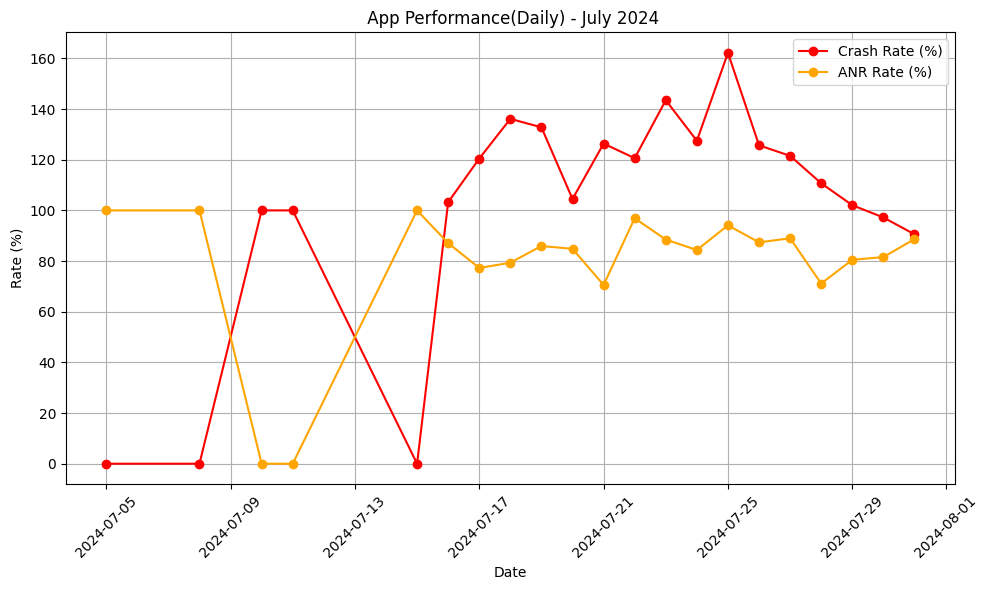

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df_2024 = pd.read_csv(
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2024.csv",
    encoding='utf-8'
)

# Convert Date column to datetime
df_2024['Date'] = pd.to_datetime(df_2024['Date'], errors='coerce')

# Filter July 2024
df_july_2024 = df_2024[(df_2024['Date'].dt.month == 7) & (df_2024['Date'].dt.year == 2024)]

# Group by Date and summarize performance
stability_stats = df_july_2024.groupby('Date').agg({
    'Daily ANRs': 'sum',
    'Daily Crashes': 'sum',
    'Device': 'nunique'
}).reset_index()

stability_stats['Crash_Rate_%'] = (stability_stats['Daily Crashes'] / stability_stats['Device']) * 100
stability_stats['ANR_Rate_%'] = (stability_stats['Daily ANRs'] / stability_stats['Device']) * 100

# Display summary statistics
print("\n📊 App Performance Metrics (July 2024):")
print(stability_stats.describe())

# Plot trends
plt.figure(figsize=(10,6))
plt.plot(stability_stats['Date'], stability_stats['Crash_Rate_%'], marker='o', label='Crash Rate (%)', color='red')
plt.plot(stability_stats['Date'], stability_stats['ANR_Rate_%'], marker='o', label='ANR Rate (%)', color='orange')
plt.title(" App Performance(Daily) - July 2024")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



 App Performance Statistics (2025):
                      Date  Daily ANRs  Daily Crashes     Device  \
count                   11   11.000000      11.000000  11.000000   
mean   2025-05-06 00:00:00   20.454545      27.818182  25.454545   
min    2025-05-01 00:00:00   11.000000       3.000000  10.000000   
25%    2025-05-03 12:00:00   15.500000      10.000000  17.500000   
50%    2025-05-06 00:00:00   18.000000      12.000000  19.000000   
75%    2025-05-08 12:00:00   25.500000      36.000000  27.500000   
max    2025-05-11 00:00:00   34.000000      86.000000  53.000000   
std                    NaN    8.430464      31.250018  14.514569   

       Crash_Rate_%  ANR_Rate_%  
count     11.000000   11.000000  
mean      84.849635   95.987084  
min       30.000000   28.846154  
25%       52.661064   65.408805  
50%       61.111111   85.714286  
75%      116.832175  110.882353  
max      167.647059  188.235294  
std       51.398566   48.984473  


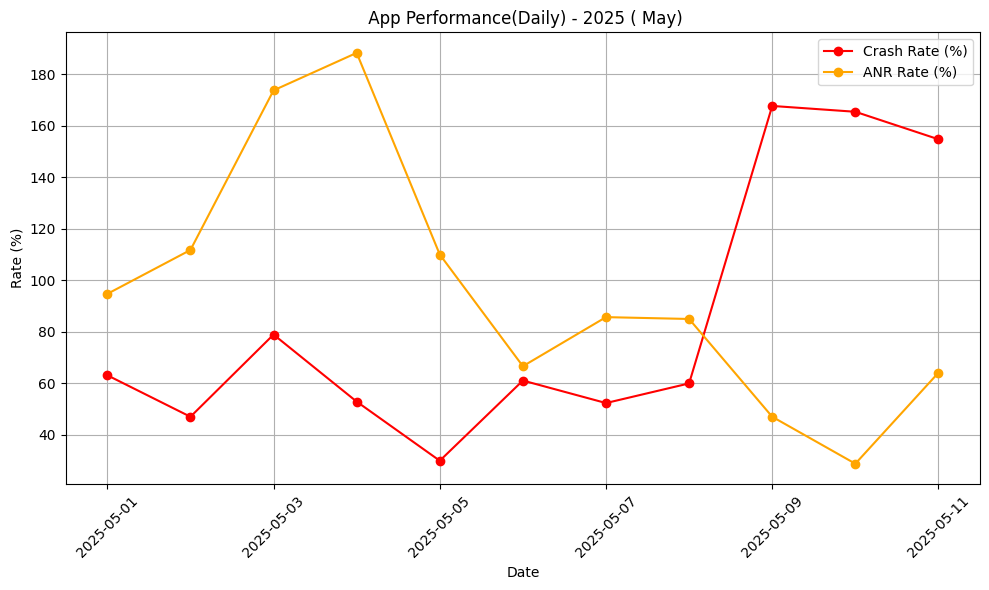

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset again for clarity
df_2025 = pd.read_csv(
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2025.csv",
    encoding='utf-8'
)

# Convert Date column
df_2025['Date'] = pd.to_datetime(df_2025['Date'], errors='coerce')

# Filter only valid data
df_2025 = df_2025.dropna(subset=['Date', 'Device'])

# --- Group by Date and compute metrics ---
stability_stats_2025 = df_2025.groupby('Date').agg({
    'Daily ANRs': 'sum',
    'Daily Crashes': 'sum',
    'Device': 'nunique'
}).reset_index()

# Compute performance rates
stability_stats_2025['Crash_Rate_%'] = (stability_stats_2025['Daily Crashes'] / stability_stats_2025['Device']) * 100
stability_stats_2025['ANR_Rate_%'] = (stability_stats_2025['Daily ANRs'] / stability_stats_2025['Device']) * 100

# --- Statistics Summary ---
print("\n App Performance Statistics (2025):")
print(stability_stats_2025.describe())

# --- Visualization ---
plt.figure(figsize=(10,6))
plt.plot(stability_stats_2025['Date'], stability_stats_2025['Crash_Rate_%'], marker='o', label='Crash Rate (%)', color='red')
plt.plot(stability_stats_2025['Date'], stability_stats_2025['ANR_Rate_%'], marker='o', label='ANR Rate (%)', color='orange')
plt.title(" App Performance(Daily) - 2025 ( May)")
plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**DASHBOARDS**

In [ ]:
#Retention & Churn Dashboard( July 2024)

 Data cleaned successfully!
Columns: ['Device', 'Submit_Date', 'Update_Date', 'Star_Rating']

Sample:
      Device Submit_Date Update_Date  Star_Rating
0     RE588E  2024-07-02  2024-07-02          1.0
1  RMX1993L1  2024-07-02  2024-07-02          1.0
2       a04e  2024-07-05  2024-07-05          5.0
3    mdh15lm  2024-07-08  2024-07-08          5.0
4        a10  2024-07-15  2024-07-15          5.0

 Daily Retention & Churn Data:
         Date  Active_Users  Previous_Active  Churn  Retention_Rate  \
0  2024-07-02             2              0.0    0.0          100.00   
1  2024-07-05             1              2.0    1.0           50.00   
2  2024-07-08             1              1.0    0.0          100.00   
3  2024-07-15            14              1.0    0.0         1400.00   
4  2024-07-16            50             14.0    0.0          357.14   

   Inactive_Users  
0             473  
1             474  
2             474  
3             461  
4             425  


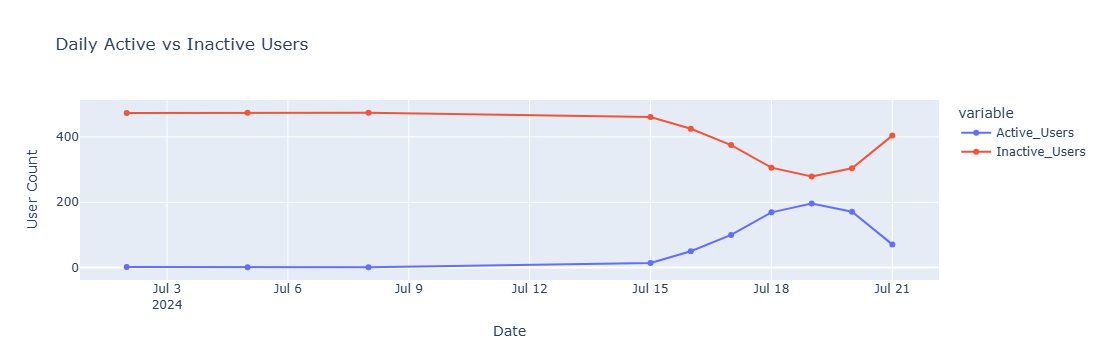

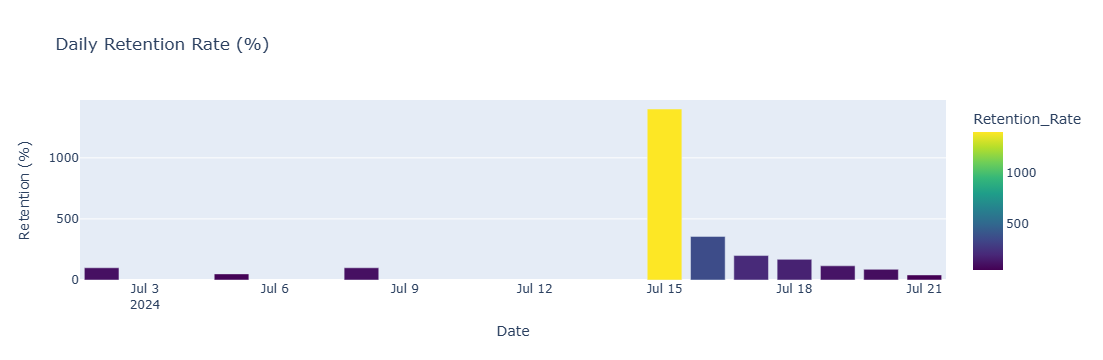

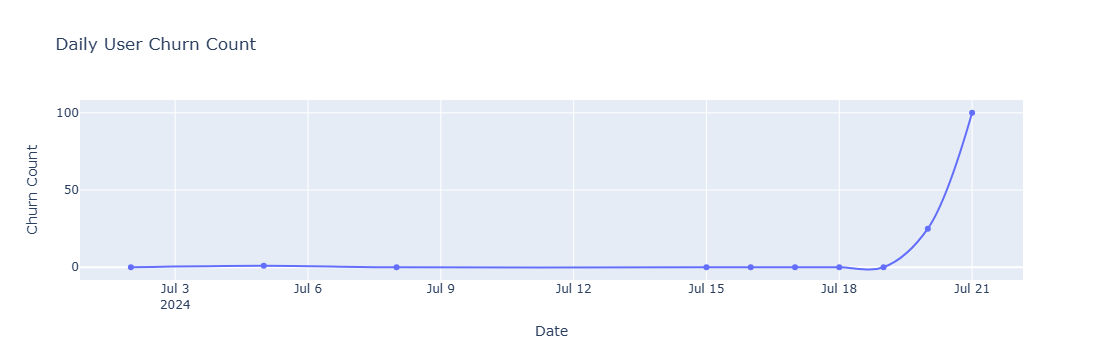


 Statistical Summary:
       Active_Users  Inactive_Users       Churn  Retention_Rate
count     10.000000       10.000000   10.000000        10.00000
mean      77.500000      397.500000   12.600000       262.08800
std       77.386835       77.386835   31.690167       410.21605
min        1.000000      279.000000    0.000000        41.52000
25%        5.000000      323.250000    0.000000        90.43000
50%       60.500000      414.500000    0.000000       107.99000
75%      151.750000      470.000000    0.750000       192.25000
max      196.000000      474.000000  100.000000      1400.00000

Total Unique Devices: 475


In [ ]:
# ======================================
#  USER RETENTION VS CHURN ANALYSIS
# Dataset: Final_review_analysis_cleaned.csv
# ======================================

import pandas as pd
import numpy as np
import plotly.express as px

# -------------------------------
#  LOAD AND CLEAN DATA
# -------------------------------
# Load CSV
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\Final_Review_Analysis_Cleaned.csv")

# Keep only relevant columns
df = df[['Device', 'Review Submit Date and Time', 'Review Last Update Date and Time', 'Star Rating']]

# Rename columns for simplicity
df.columns = ['Device', 'Submit_Date', 'Update_Date', 'Star_Rating']

# Clean & convert date columns to datetime
df['Submit_Date'] = pd.to_datetime(df['Submit_Date'], errors='coerce')
df['Update_Date'] = pd.to_datetime(df['Update_Date'], errors='coerce')

# Drop rows with invalid or missing dates
df = df.dropna(subset=['Submit_Date', 'Update_Date'])

# Extract only the date part (no time)
df['Submit_Date'] = df['Submit_Date'].dt.date
df['Update_Date'] = df['Update_Date'].dt.date

print(" Data cleaned successfully!")
print("Columns:", df.columns.tolist())
print("\nSample:")
print(df.head())

# -------------------------------
#  DEFINE ACTIVE vs INACTIVE USERS
# -------------------------------
# Rule:
# If a device has a review update on a given day → Active
# If a device has no update activity for 7+ days → Inactive

# Create daily activity summary
daily_activity = df.groupby('Update_Date')['Device'].nunique().reset_index()
daily_activity.columns = ['Date', 'Active_Users']

# Sort by date
daily_activity = daily_activity.sort_values('Date')

# Compute churn (drop in active users)
daily_activity['Previous_Active'] = daily_activity['Active_Users'].shift(1)
daily_activity['Churn'] = daily_activity['Previous_Active'] - daily_activity['Active_Users']

# Any negative churn (growth) should be 0
daily_activity['Churn'] = daily_activity['Churn'].apply(lambda x: x if x > 0 else 0)

# Calculate retention rate (percentage of users retained)
daily_activity['Retention_Rate'] = (
    daily_activity['Active_Users'] / daily_activity['Previous_Active'] * 100
).round(2)

# Fill first day NA values
daily_activity.fillna({'Previous_Active': 0, 'Churn': 0, 'Retention_Rate': 100}, inplace=True)

# -------------------------------
#  ADD ACTIVE/INACTIVE USER STATUS
# -------------------------------
# Approximation: inactive users = total devices - active on that day
total_devices = df['Device'].nunique()
daily_activity['Inactive_Users'] = total_devices - daily_activity['Active_Users']

print("\n Daily Retention & Churn Data:")
print(daily_activity.head())

# -------------------------------
#  VISUALIZE WITH DASHBOARD-LIKE PLOTS
# -------------------------------
# Plot 1: Active vs Inactive Users
fig_activity = px.line(
    daily_activity,
    x='Date',
    y=['Active_Users', 'Inactive_Users'],
    title=' Daily Active vs Inactive Users',
    markers=True
)
fig_activity.update_layout(xaxis_title='Date', yaxis_title='User Count')
fig_activity.show()

# Plot 2: Retention and Churn Trends
fig_retention = px.bar(
    daily_activity,
    x='Date',
    y='Retention_Rate',
    title=' Daily Retention Rate (%)',
    color='Retention_Rate',
    color_continuous_scale='Viridis'
)
fig_retention.update_layout(xaxis_title='Date', yaxis_title='Retention (%)')
fig_retention.show()

fig_churn = px.line(
    daily_activity,
    x='Date',
    y='Churn',
    title=' Daily User Churn Count',
    markers=True,
    line_shape='spline'
)
fig_churn.update_layout(xaxis_title='Date', yaxis_title='Churn Count')
fig_churn.show()

# -------------------------------
#  STATISTICAL SUMMARY
# -------------------------------
print("\n Statistical Summary:")
print(daily_activity[['Active_Users', 'Inactive_Users', 'Churn', 'Retention_Rate']].describe())
print(f"\nTotal Unique Devices: {total_devices}")


**FRUT GARDEN INSIGHT OVERVIEW DASHBOARD**

In [ ]:
pip install dash plotly pandas


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import plotly.express as px
from dash import Dash, html, dcc

# =============================
# Load and prepare 2024 dataset
# =============================
df_2024 = pd.read_csv(
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2024.csv",
    encoding='utf-8'
)
df_2024['Date'] = pd.to_datetime(df_2024['Date'], errors='coerce')
df_2024 = df_2024.dropna(subset=['Date', 'Device'])

# --- July 2024 Retention ---
df_july_2024 = df_2024[(df_2024['Date'].dt.month == 7) & (df_2024['Date'].dt.year == 2024)]
daily_devices_2024 = df_july_2024.groupby('Date')['Device'].nunique().reset_index(name='Active_Devices')
daily_devices_2024['Retention_Rate_%'] = daily_devices_2024['Active_Devices'].pct_change().fillna(0) * 100
daily_devices_2024['Churn_Rate_%'] = daily_devices_2024['Retention_Rate_%'].apply(lambda x: abs(x) if x < 0 else 0)

# --- July 2024 Stability ---
stability_stats = df_july_2024.groupby('Date').agg({
    'Daily ANRs': 'sum',
    'Daily Crashes': 'sum',
    'Device': 'nunique'
}).reset_index()
stability_stats['Crash_Rate_%'] = (stability_stats['Daily Crashes'] / stability_stats['Device']) * 100
stability_stats['ANR_Rate_%'] = (stability_stats['Daily ANRs'] / stability_stats['Device']) * 100

# =============================
# Load and prepare 2025 dataset
# =============================
df_2025 = pd.read_csv(
    r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\App_Performance_2025.csv",
    encoding='utf-8'
)
df_2025['Date'] = pd.to_datetime(df_2025['Date'], errors='coerce')
df_2025 = df_2025.dropna(subset=['Date', 'Device'])
daily_devices_2025 = df_2025.groupby('Date')['Device'].nunique().reset_index(name='Active_Devices')
daily_devices_2025['Retention_Rate_%'] = daily_devices_2025['Active_Devices'].pct_change().fillna(0) * 100
daily_devices_2025['Churn_Rate_%'] = daily_devices_2025['Retention_Rate_%'].apply(lambda x: abs(x) if x < 0 else 0)

# =============================
# Create Visualizations
# =============================
fig1 = px.line(
    daily_devices_2024,
    x='Date', y='Active_Devices',
    title=" Active Devices - July 2024",
    markers=True,
    line_shape='linear',
    color_discrete_sequence=['#1f77b4']
)
fig1.update_traces(line=dict(width=4))

fig2 = px.line(
    stability_stats,
    x='Date', y=['Crash_Rate_%', 'ANR_Rate_%'],
    title="⚙️ App Stability Metrics - July 2024",
    markers=True,
    color_discrete_sequence=['#d62728', '#ff7f0e']
)
fig2.update_traces(line=dict(width=4))

fig3 = px.line(
    daily_devices_2025,
    x='Date', y='Active_Devices',
    title="📈 Active Devices - 2025 (All Months)",
    markers=True,
    color_discrete_sequence=['#2ca02c']
)
fig3.update_traces(line=dict(width=4))

# =============================
# Build Dashboard Layout
# =============================
app = Dash(__name__)
app.title = "App Performance Dashboard"

app.layout = html.Div([
    html.H1(" App Performance Dashboard", style={'textAlign': 'center', 'color': '#003366'}),

    html.Div([
        html.H3("User Retention & Activity (2024 July)", style={'color': '#1f77b4'}),
        dcc.Graph(figure=fig1)
    ], style={'margin': '20px'}),

    html.Div([
        html.H3("App Stability (Crash & ANR Rates)", style={'color': '#d62728'}),
        dcc.Graph(figure=fig2)
    ], style={'margin': '20px'}),

    html.Div([
        html.H3("User Retention & Activity (2025)", style={'color': '#2ca02c'}),
        dcc.Graph(figure=fig3)
    ], style={'margin': '20px'})
])

# =============================
# Run the Dashboard
# =============================
if __name__ == "__main__":
    app.run(debug=True)




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

print("="*70)
print("BATCH 1: DATA LOADING & TIME SERIES ANALYSIS")
print("="*70)

# Load the data
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\Combined_App_Performance.csv")

# Check available columns
print("\nAvailable columns in dataset:")
print(df.columns.tolist())

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Identify the columns we need
required_base = ['Daily ANRs', 'Android OS Version', 'Daily Crashes']
date_col = None
device_col = None

# Find date column
for col in df.columns:
    if 'date' in col.lower():
        date_col = col
        break

# Find device column
for col in df.columns:
    if 'device' in col.lower():
        device_col = col
        break

print(f"\nIdentified columns:")
print(f"  Date column: {date_col}")
print(f"  Device column: {device_col}")
print(f"  Required columns: {required_base}")

# Select only needed columns
columns_to_keep = required_base.copy()
if date_col:
    columns_to_keep.insert(0, date_col)
if device_col:
    columns_to_keep.append(device_col)

# Keep only required columns and drop the rest
df = df[columns_to_keep].copy()

print(f"\nColumns retained for analysis: {df.columns.tolist()}")
print(f"Original dataset size: {len(df):,} records")

# Data preprocessing
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df = df.rename(columns={date_col: 'Date'})

df['Daily Crashes'] = pd.to_numeric(df['Daily Crashes'], errors='coerce')
df['Daily ANRs'] = pd.to_numeric(df['Daily ANRs'], errors='coerce')
df = df.dropna(subset=['Daily Crashes', 'Daily ANRs'])

if device_col:
    df = df.rename(columns={device_col: 'Device'})

print(f"Cleaned dataset size: {len(df):,} records")
print(f"\nData date range: {df['Date'].min()} to {df['Date'].max()}")

# Display sample of cleaned data
print("\nSample of cleaned data (first 5 rows):")
print(df.head())

print("\nBasic statistics:")
print(df[['Daily Crashes', 'Daily ANRs']].describe())

# ===========================================================================
# A. HIGH-LEVEL STABILITY METRICS
# ===========================================================================

print("\n" + "="*70)
print("A. HIGH-LEVEL STABILITY METRICS")
print("="*70)

# 1. TIME SERIES ANALYSIS: Daily Crashes and ANRs aggregated by date
print("\n1. TIME SERIES ANALYSIS - Daily Crashes and ANRs")
print("-" * 70)

daily_agg = df.groupby('Date').agg({
    'Daily Crashes': 'sum',
    'Daily ANRs': 'sum'
}).reset_index().sort_values('Date')

print(f"\nTime Period: {daily_agg['Date'].min().strftime('%Y-%m-%d')} to {daily_agg['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total Days: {len(daily_agg)}")
print(f"\nTotal Crashes (entire period): {daily_agg['Daily Crashes'].sum():,.0f}")
print(f"Total ANRs (entire period): {daily_agg['Daily ANRs'].sum():,.0f}")
print(f"Average Daily Crashes: {daily_agg['Daily Crashes'].mean():.2f}")
print(f"Average Daily ANRs: {daily_agg['Daily ANRs'].mean():.2f}")
print(f"Max Daily Crashes: {daily_agg['Daily Crashes'].max():.0f} on {daily_agg.loc[daily_agg['Daily Crashes'].idxmax(), 'Date'].strftime('%Y-%m-%d')}")
print(f"Max Daily ANRs: {daily_agg['Daily ANRs'].max():.0f} on {daily_agg.loc[daily_agg['Daily ANRs'].idxmax(), 'Date'].strftime('%Y-%m-%d')}")

# Create time series visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 9))

# Crashes over time
axes[0].plot(daily_agg['Date'], daily_agg['Daily Crashes'],
             marker='o', linewidth=2.5, markersize=5, color='#e74c3c',
             markerfacecolor='white', markeredgewidth=2)
axes[0].fill_between(daily_agg['Date'], daily_agg['Daily Crashes'],
                      alpha=0.3, color='#e74c3c')
axes[0].set_title('Daily Crashes Over Time (2024-2025)',
                  fontsize=15, fontweight='bold', pad=15)
axes[0].set_ylabel('Total Daily Crashes', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.4, linestyle='--')
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# Add mean line
mean_crashes = daily_agg['Daily Crashes'].mean()
axes[0].axhline(y=mean_crashes, color='red', linestyle='--',
                linewidth=2, alpha=0.7, label=f'Mean: {mean_crashes:.1f}')
axes[0].legend(loc='upper right', fontsize=10)

# ANRs over time
axes[1].plot(daily_agg['Date'], daily_agg['Daily ANRs'],
             marker='s', linewidth=2.5, markersize=5, color='#f39c12',
             markerfacecolor='white', markeredgewidth=2)
axes[1].fill_between(daily_agg['Date'], daily_agg['Daily ANRs'],
                      alpha=0.3, color='#f39c12')
axes[1].set_title('Daily ANRs Over Time (2024-2025)',
                  fontsize=15, fontweight='bold', pad=15)
axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Daily ANRs', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.4, linestyle='--')
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

# Add mean line
mean_anrs = daily_agg['Daily ANRs'].mean()
axes[1].axhline(y=mean_anrs, color='orange', linestyle='--',
                linewidth=2, alpha=0.7, label=f'Mean: {mean_anrs:.1f}')
axes[1].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('batch1_time_series_crashes_anrs.png', dpi=300, bbox_inches='tight')
print("\n✓ Time series chart saved: batch1_time_series_crashes_anrs.png")
plt.close()

# Monthly breakdown
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['YearMonth'] = df['Date'].dt.to_period('M')

monthly_summary = df.groupby('YearMonth').agg({
    'Daily Crashes': 'sum',
    'Daily ANRs': 'sum'
}).reset_index()

monthly_summary['YearMonth'] = monthly_summary['YearMonth'].astype(str)

print("\n\nMonthly Summary:")
print(monthly_summary.to_string(index=False))

print("\n" + "="*70)
print("BATCH 1 COMPLETE - Time Series Analysis Done")
print("="*70)

BATCH 1: DATA LOADING & TIME SERIES ANALYSIS

Available columns in dataset:
['Date', 'Package Name', 'Android OS Version', 'Daily Crashes', 'Daily ANRs', 'Month', 'Device']

Identified columns:
  Date column: Date
  Device column: Device
  Required columns: ['Daily ANRs', 'Android OS Version', 'Daily Crashes']

Columns retained for analysis: ['Date', 'Daily ANRs', 'Android OS Version', 'Daily Crashes', 'Device']
Original dataset size: 3,392 records
Cleaned dataset size: 3,391 records

Data date range: 2024-07-05 00:00:00 to 2025-05-11 00:00:00

Sample of cleaned data (first 5 rows):
        Date  Daily ANRs Android OS Version  Daily Crashes  \
0 2025-02-01         8.0        Android 6.0            0.0   
1 2025-02-01         6.0        Android 7.1           15.0   
2 2025-02-01         1.0        Android 8.0            2.0   
3 2025-02-01         6.0        Android 8.1            1.0   
4 2025-02-01         8.0          Android 9           13.0   

                                     

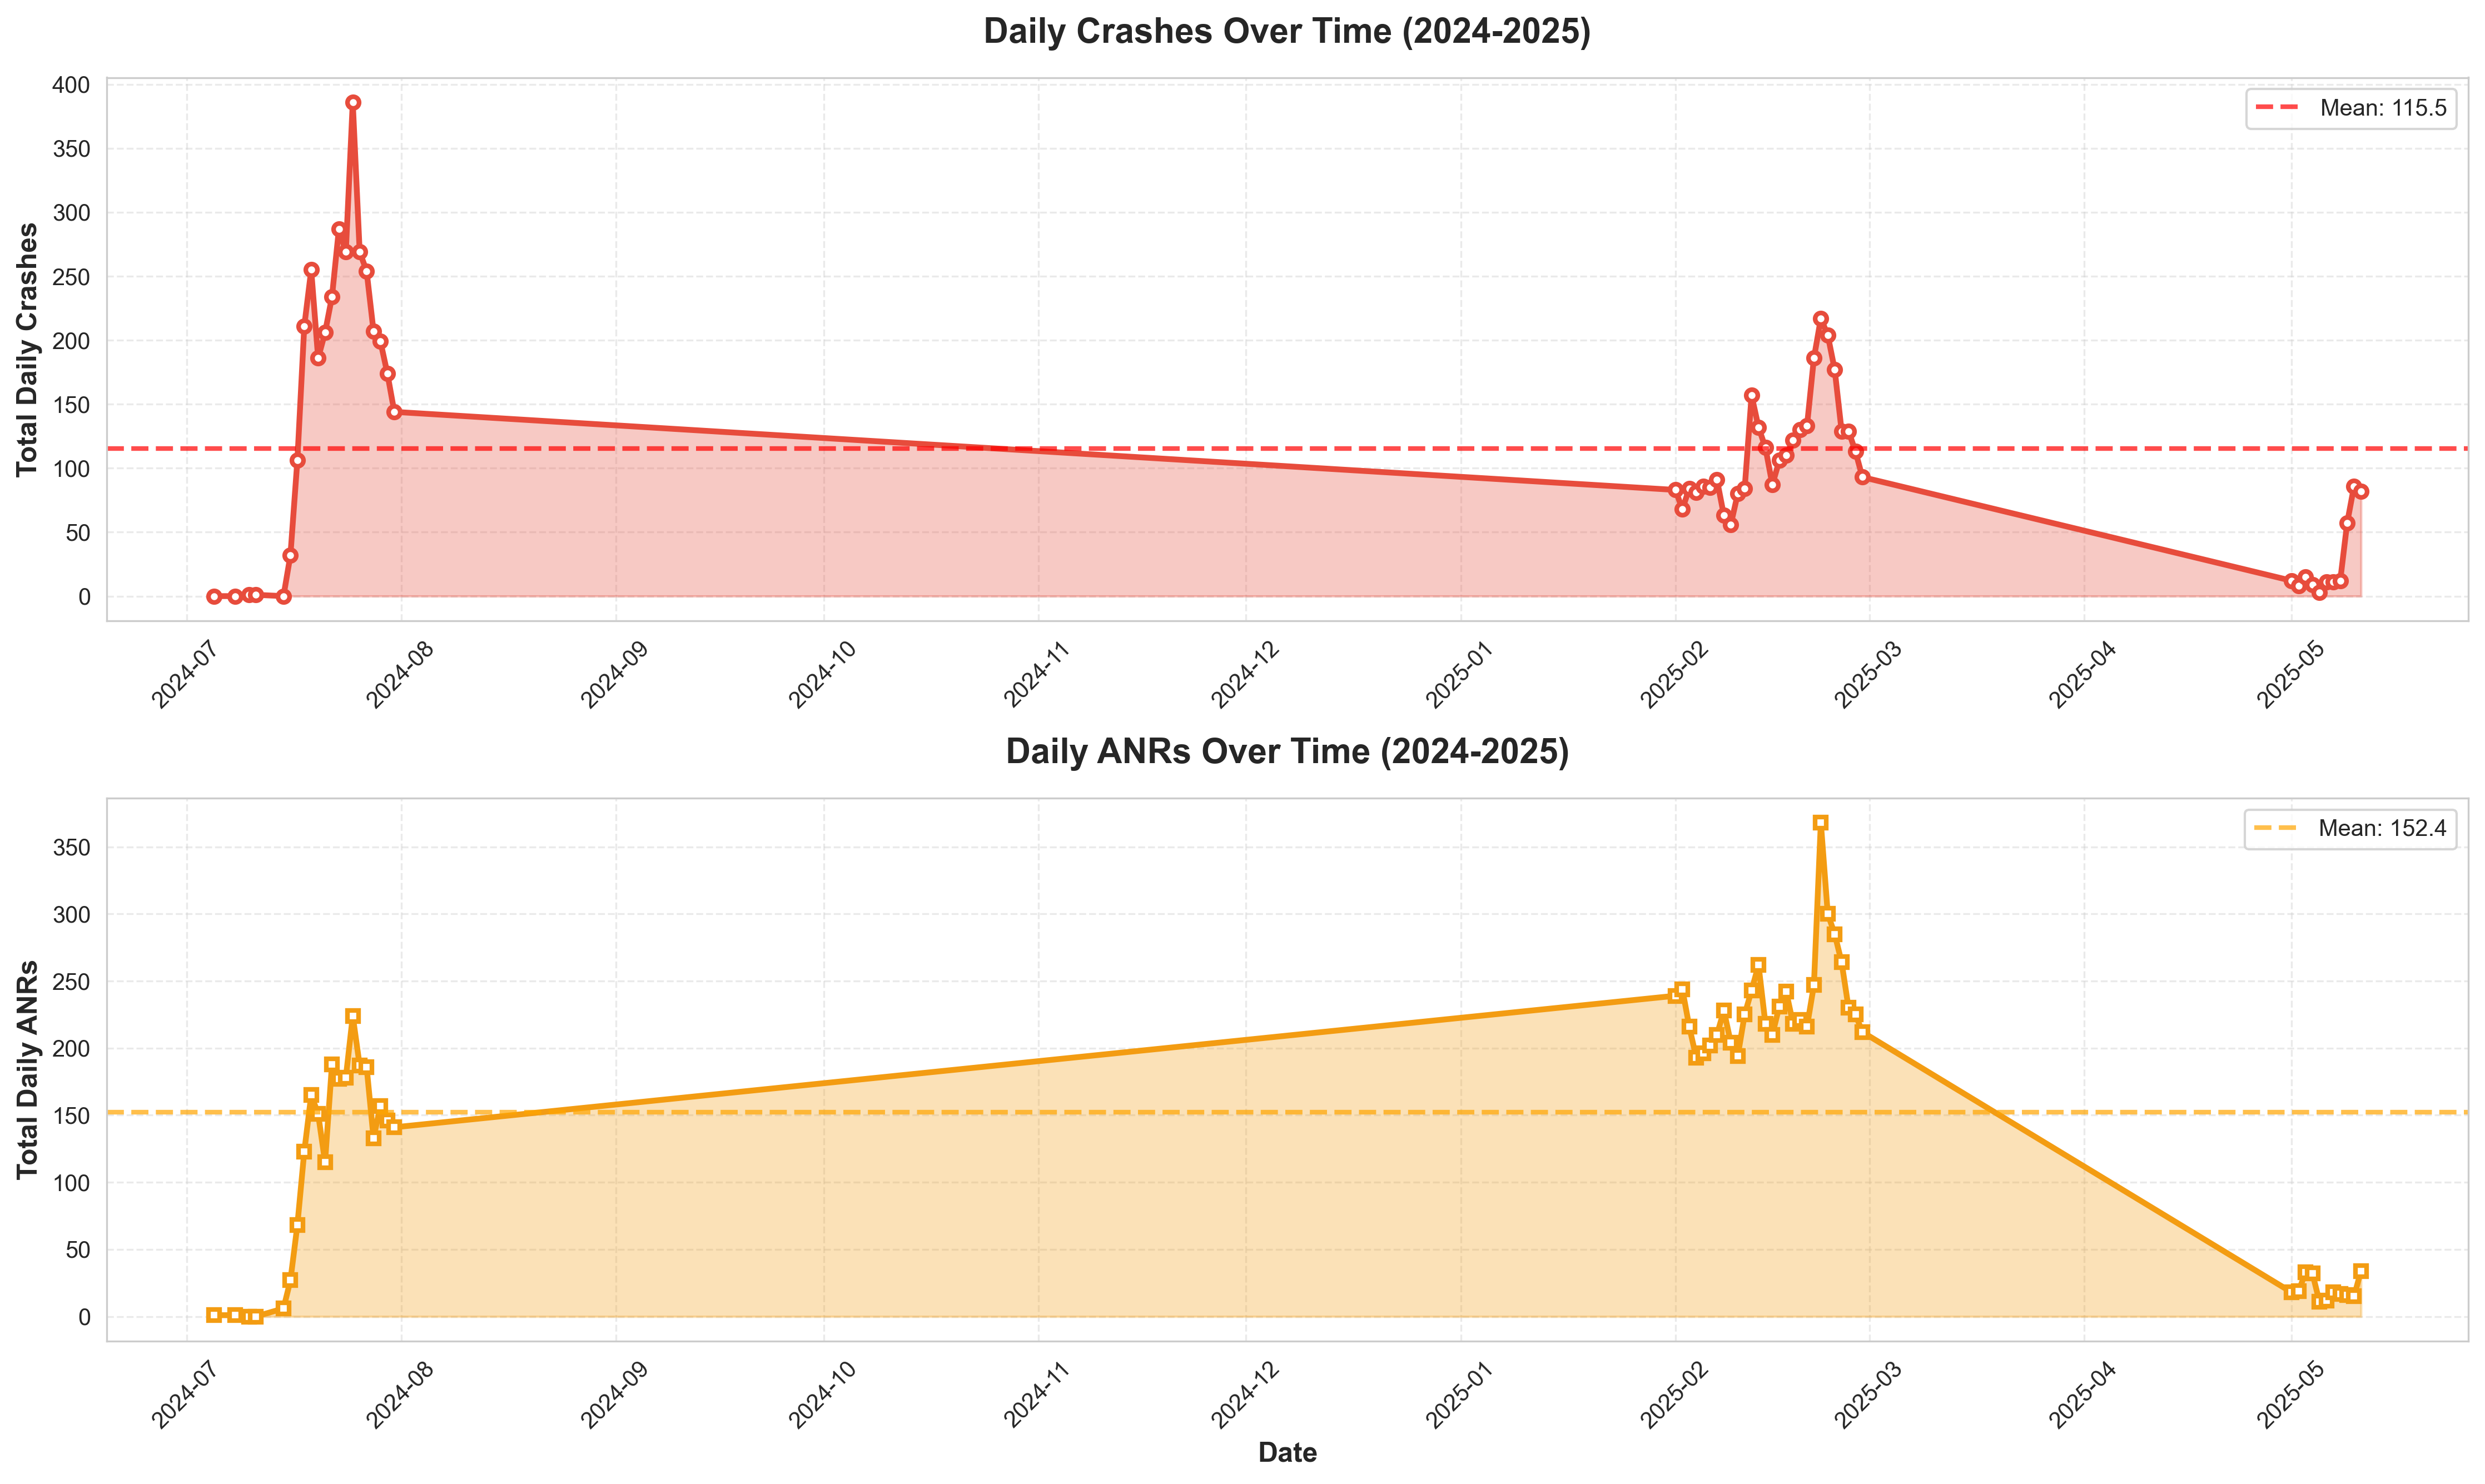

✓ Chart saved: batch1_time_series_crashes_anrs.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Load and prepare data
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\Combined_App_Performance.csv")
df.columns = df.columns.str.strip()

# Find date column
date_col = [col for col in df.columns if 'date' in col.lower()][0]

# Keep required columns
df = df[['Daily ANRs', 'Android OS Version', 'Daily Crashes', date_col]].copy()

# Clean data
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.rename(columns={date_col: 'Date'})
df['Daily Crashes'] = pd.to_numeric(df['Daily Crashes'], errors='coerce')
df['Daily ANRs'] = pd.to_numeric(df['Daily ANRs'], errors='coerce')
df = df.dropna(subset=['Date', 'Daily Crashes', 'Daily ANRs'])

# Aggregate by date
daily_agg = df.groupby('Date').agg({
    'Daily Crashes': 'sum',
    'Daily ANRs': 'sum'
}).reset_index().sort_values('Date')

# PLOT: Time Series Chart
fig, axes = plt.subplots(2, 1, figsize=(15, 9))

# Crashes over time
axes[0].plot(daily_agg['Date'], daily_agg['Daily Crashes'],
             marker='o', linewidth=2.5, markersize=5, color='#e74c3c',
             markerfacecolor='white', markeredgewidth=2)
axes[0].fill_between(daily_agg['Date'], daily_agg['Daily Crashes'],
                      alpha=0.3, color='#e74c3c')
axes[0].set_title('Daily Crashes Over Time (2024-2025)',
                  fontsize=15, fontweight='bold', pad=15)
axes[0].set_ylabel('Total Daily Crashes', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.4, linestyle='--')
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# Add mean line
mean_crashes = daily_agg['Daily Crashes'].mean()
axes[0].axhline(y=mean_crashes, color='red', linestyle='--',
                linewidth=2, alpha=0.7, label=f'Mean: {mean_crashes:.1f}')
axes[0].legend(loc='upper right', fontsize=10)

# ANRs over time
axes[1].plot(daily_agg['Date'], daily_agg['Daily ANRs'],
             marker='s', linewidth=2.5, markersize=5, color='#f39c12',
             markerfacecolor='white', markeredgewidth=2)
axes[1].fill_between(daily_agg['Date'], daily_agg['Daily ANRs'],
                      alpha=0.3, color='#f39c12')
axes[1].set_title('Daily ANRs Over Time (2024-2025)',
                  fontsize=15, fontweight='bold', pad=15)
axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Daily ANRs', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.4, linestyle='--')
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

# Add mean line
mean_anrs = daily_agg['Daily ANRs'].mean()
axes[1].axhline(y=mean_anrs, color='orange', linestyle='--',
                linewidth=2, alpha=0.7, label=f'Mean: {mean_anrs:.1f}')
axes[1].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('batch1_time_series_crashes_anrs.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: batch1_time_series_crashes_anrs.png")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

print("="*70)
print("BATCH 2: CRASH RATE ANALYSIS BY OS VERSION & DEVICE")
print("="*70)

# Load the data
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\Combined_App_Performance.csv")
df.columns = df.columns.str.strip()

# Find columns
date_col = [col for col in df.columns if 'date' in col.lower()][0]
device_col = [col for col in df.columns if 'device' in col.lower()][0] if any('device' in col.lower() for col in df.columns) else None

# Keep only required columns
columns_to_keep = ['Daily ANRs', 'Android OS Version', 'Daily Crashes', date_col]
if device_col:
    columns_to_keep.append(device_col)

df = df[columns_to_keep].copy()

# Clean data
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.rename(columns={date_col: 'Date'})
df['Daily Crashes'] = pd.to_numeric(df['Daily Crashes'], errors='coerce')
df['Daily ANRs'] = pd.to_numeric(df['Daily ANRs'], errors='coerce')
df = df.dropna(subset=['Date', 'Daily Crashes', 'Daily ANRs'])

if device_col:
    df = df.rename(columns={device_col: 'Device'})

print(f"Dataset loaded: {len(df):,} records")

# ===========================================================================
# 2. CRASH RATE BY ANDROID OS VERSION
# ===========================================================================

print("\n2. CRASH RATE BY ANDROID OS VERSION")
print("-" * 70)

os_metrics = df.groupby('Android OS Version').agg({
    'Daily Crashes': ['sum', 'mean', 'count'],
    'Daily ANRs': ['sum', 'mean']
}).reset_index()

os_metrics.columns = ['OS_Version', 'Total_Crashes', 'Avg_Crashes', 'Record_Count',
                      'Total_ANRs', 'Avg_ANRs']

# Calculate crash rate (crashes per record)
os_metrics['Crash_Rate'] = (os_metrics['Total_Crashes'] / os_metrics['Record_Count']) * 100
os_metrics['ANR_Rate'] = (os_metrics['Total_ANRs'] / os_metrics['Record_Count']) * 100

# Sort by crash rate
os_metrics = os_metrics.sort_values('Crash_Rate', ascending=False)

print("\nAndroid OS Version Performance Metrics:")
print(os_metrics.to_string(index=False))

# Visualization - OS Version Crash Rate
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Crash Rate
bars1 = axes[0].barh(range(len(os_metrics)), os_metrics['Crash_Rate'],
                     color='#3498db', alpha=0.8, edgecolor='black')
# Highlight top 3 worst
for i in range(min(3, len(bars1))):
    bars1[i].set_color('#e74c3c')
    bars1[i].set_alpha(1.0)

axes[0].set_yticks(range(len(os_metrics)))
axes[0].set_yticklabels(os_metrics['OS_Version'], fontsize=10)
axes[0].set_xlabel('Crash Rate (% of records)', fontsize=12, fontweight='bold')
axes[0].set_title('Crash Rate by Android OS Version', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Add value labels
for i, v in enumerate(os_metrics['Crash_Rate']):
    axes[0].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

# ANR Rate
bars2 = axes[1].barh(range(len(os_metrics)), os_metrics['ANR_Rate'],
                     color='#9b59b6', alpha=0.8, edgecolor='black')
# Highlight top 3 worst
for i in range(min(3, len(bars2))):
    bars2[i].set_color('#f39c12')
    bars2[i].set_alpha(1.0)

axes[1].set_yticks(range(len(os_metrics)))
axes[1].set_yticklabels(os_metrics['OS_Version'], fontsize=10)
axes[1].set_xlabel('ANR Rate (% of records)', fontsize=12, fontweight='bold')
axes[1].set_title('ANR Rate by Android OS Version', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

# Add value labels
for i, v in enumerate(os_metrics['ANR_Rate']):
    axes[1].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('batch2_crash_rate_by_os.png', dpi=300, bbox_inches='tight')
print("\n✓ Chart saved: batch2_crash_rate_by_os.png")
plt.close()

# ===========================================================================
# 3. CRASH RATE BY DEVICE (if Device column exists)
# ===========================================================================

if 'Device' in df.columns:
    print("\n\n3. CRASH RATE BY DEVICE")
    print("-" * 70)

    device_metrics = df.groupby('Device').agg({
        'Daily Crashes': ['sum', 'mean', 'count'],
        'Daily ANRs': ['sum', 'mean']
    }).reset_index()

    device_metrics.columns = ['Device', 'Total_Crashes', 'Avg_Crashes', 'Record_Count',
                              'Total_ANRs', 'Avg_ANRs']

    device_metrics['Crash_Rate'] = (device_metrics['Total_Crashes'] / device_metrics['Record_Count']) * 100
    device_metrics['ANR_Rate'] = (device_metrics['Total_ANRs'] / device_metrics['Record_Count']) * 100

    device_metrics = device_metrics.sort_values('Crash_Rate', ascending=False)

    print("\nDevice Performance Metrics:")
    print(device_metrics.to_string(index=False))

    # Visualization - Device Crash Rate (Top 15)
    top_devices = device_metrics.head(15)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Crash Rate
    bars1 = axes[0].barh(range(len(top_devices)), top_devices['Crash_Rate'],
                         color='#3498db', alpha=0.8, edgecolor='black')
    for i in range(min(5, len(bars1))):
        bars1[i].set_color('#e74c3c')
        bars1[i].set_alpha(1.0)

    axes[0].set_yticks(range(len(top_devices)))
    axes[0].set_yticklabels(top_devices['Device'], fontsize=9)
    axes[0].set_xlabel('Crash Rate (% of records)', fontsize=12, fontweight='bold')
    axes[0].set_title('Top 15 Devices by Crash Rate', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].invert_yaxis()

    # ANR Rate
    bars2 = axes[1].barh(range(len(top_devices)), top_devices['ANR_Rate'],
                         color='#9b59b6', alpha=0.8, edgecolor='black')
    for i in range(min(5, len(bars2))):
        bars2[i].set_color('#f39c12')
        bars2[i].set_alpha(1.0)

    axes[1].set_yticks(range(len(top_devices)))
    axes[1].set_yticklabels(top_devices['Device'], fontsize=9)
    axes[1].set_xlabel('ANR Rate (% of records)', fontsize=12, fontweight='bold')
    axes[1].set_title('Top 15 Devices by ANR Rate', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.savefig('batch2_crash_rate_by_device.png', dpi=300, bbox_inches='tight')
    print("\n✓ Chart saved: batch2_crash_rate_by_device.png")
    plt.close()

else:
    print("\n\n3. DEVICE ANALYSIS SKIPPED")
    print("-" * 70)
    print("No Device column found in dataset.")

print("\n" + "="*70)
print("BATCH 2 COMPLETE - Crash Rate Analysis Done")
print("="*70)

BATCH 2: CRASH RATE ANALYSIS BY OS VERSION & DEVICE
Dataset loaded: 3,391 records

2. CRASH RATE BY ANDROID OS VERSION
----------------------------------------------------------------------

Android OS Version Performance Metrics:
 OS_Version  Total_Crashes  Avg_Crashes  Record_Count  Total_ANRs   Avg_ANRs  Crash_Rate     ANR_Rate
 Android 14         1076.0    38.428571            28      4176.0 149.142857 3842.857143 14914.285714
  Android 9          679.0    24.250000            28       182.0   6.500000 2425.000000   650.000000
 Android 13          381.0    13.607143            28       325.0  11.607143 1360.714286  1160.714286
 Android 12          290.0    10.357143            28       562.0  20.071429 1035.714286  2007.142857
 Android 11          238.0     8.500000            28       375.0  13.392857  850.000000  1339.285714
 Android 10          195.0     6.964286            28       330.0  11.785714  696.428571  1178.571429
Android 8.1          135.0     4.821429            28  

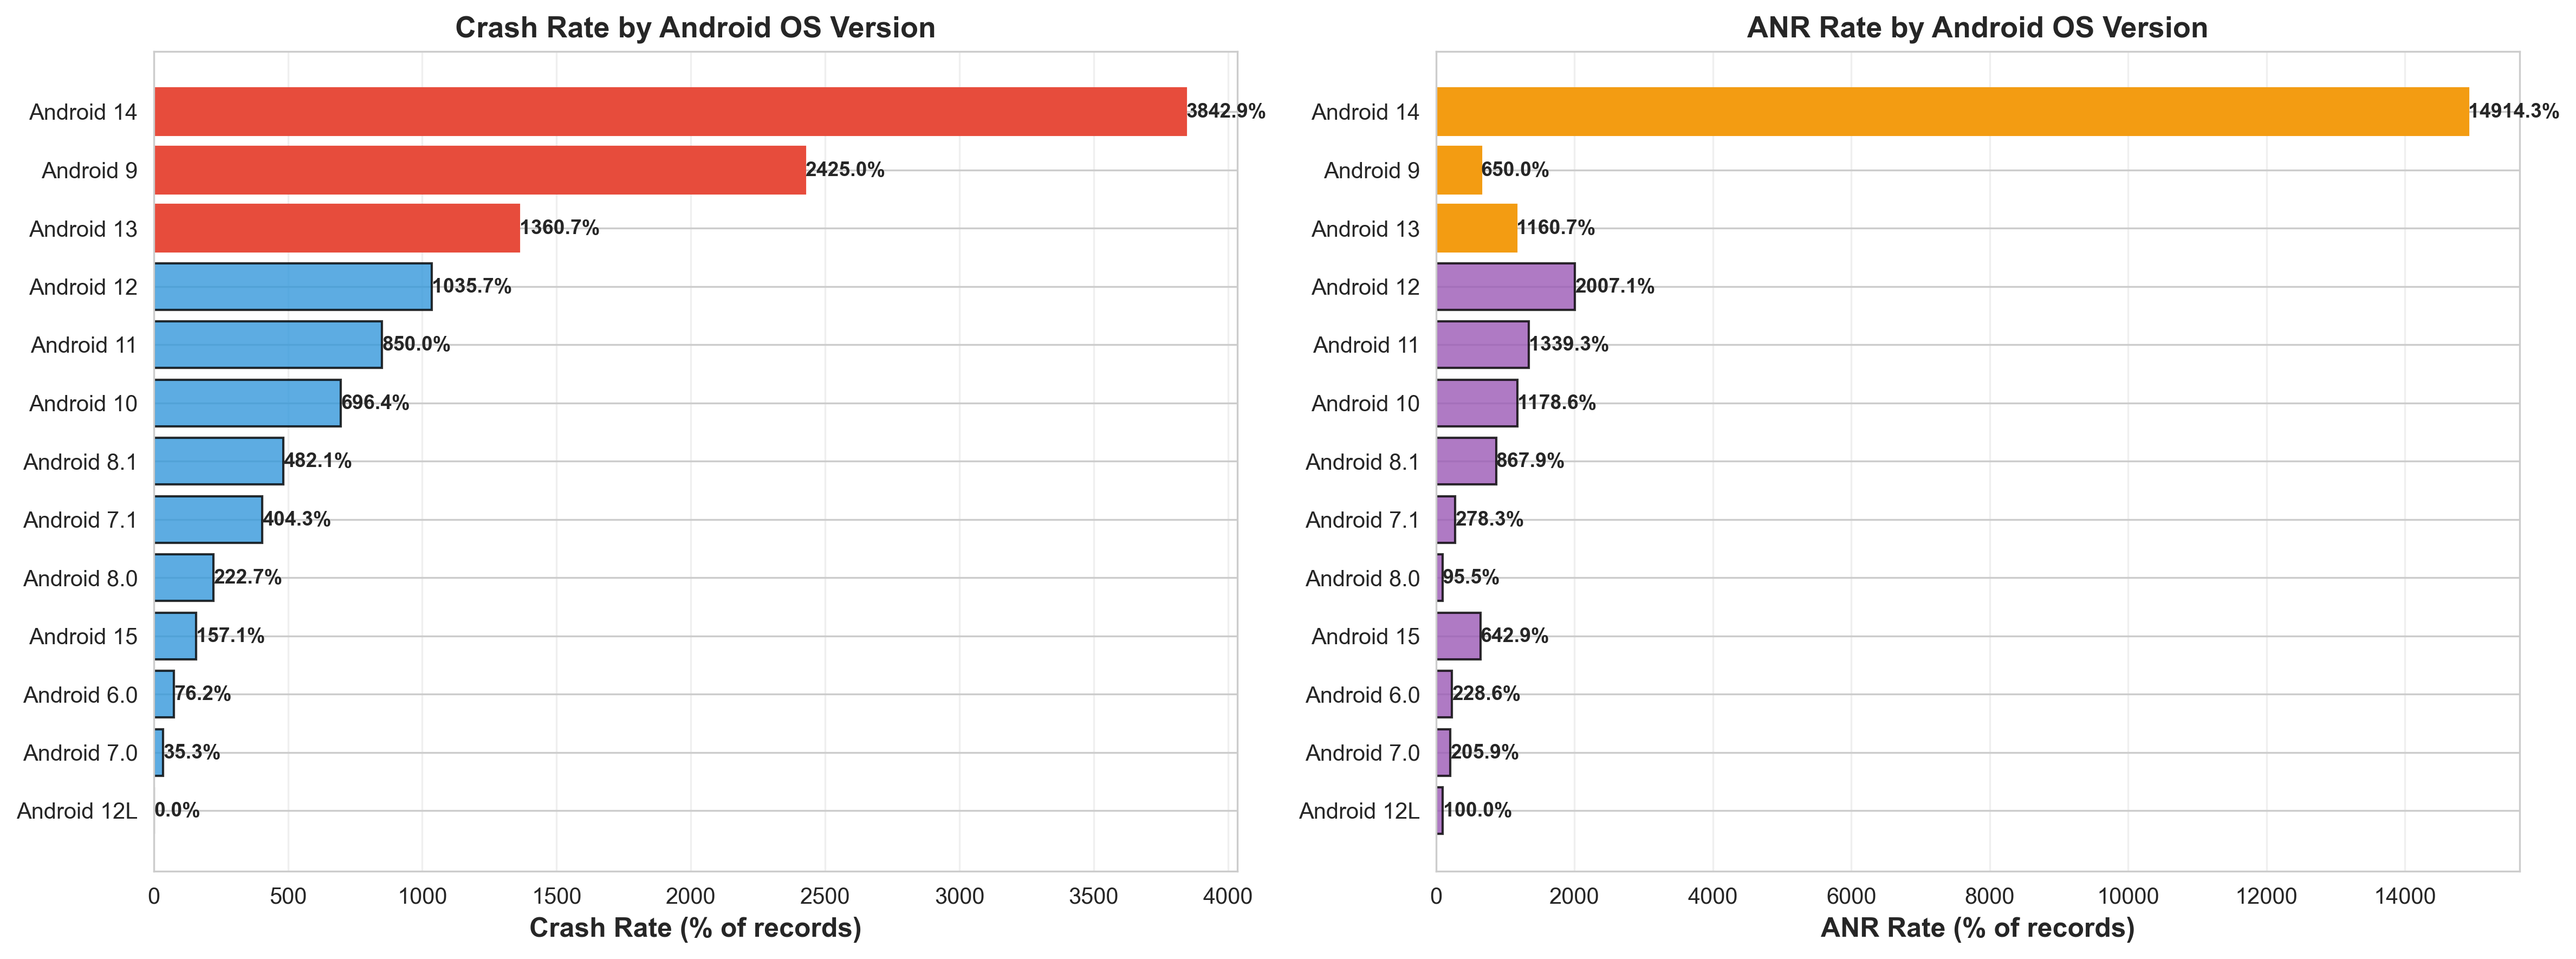

✓ Chart saved: batch2_crash_rate_by_os.png


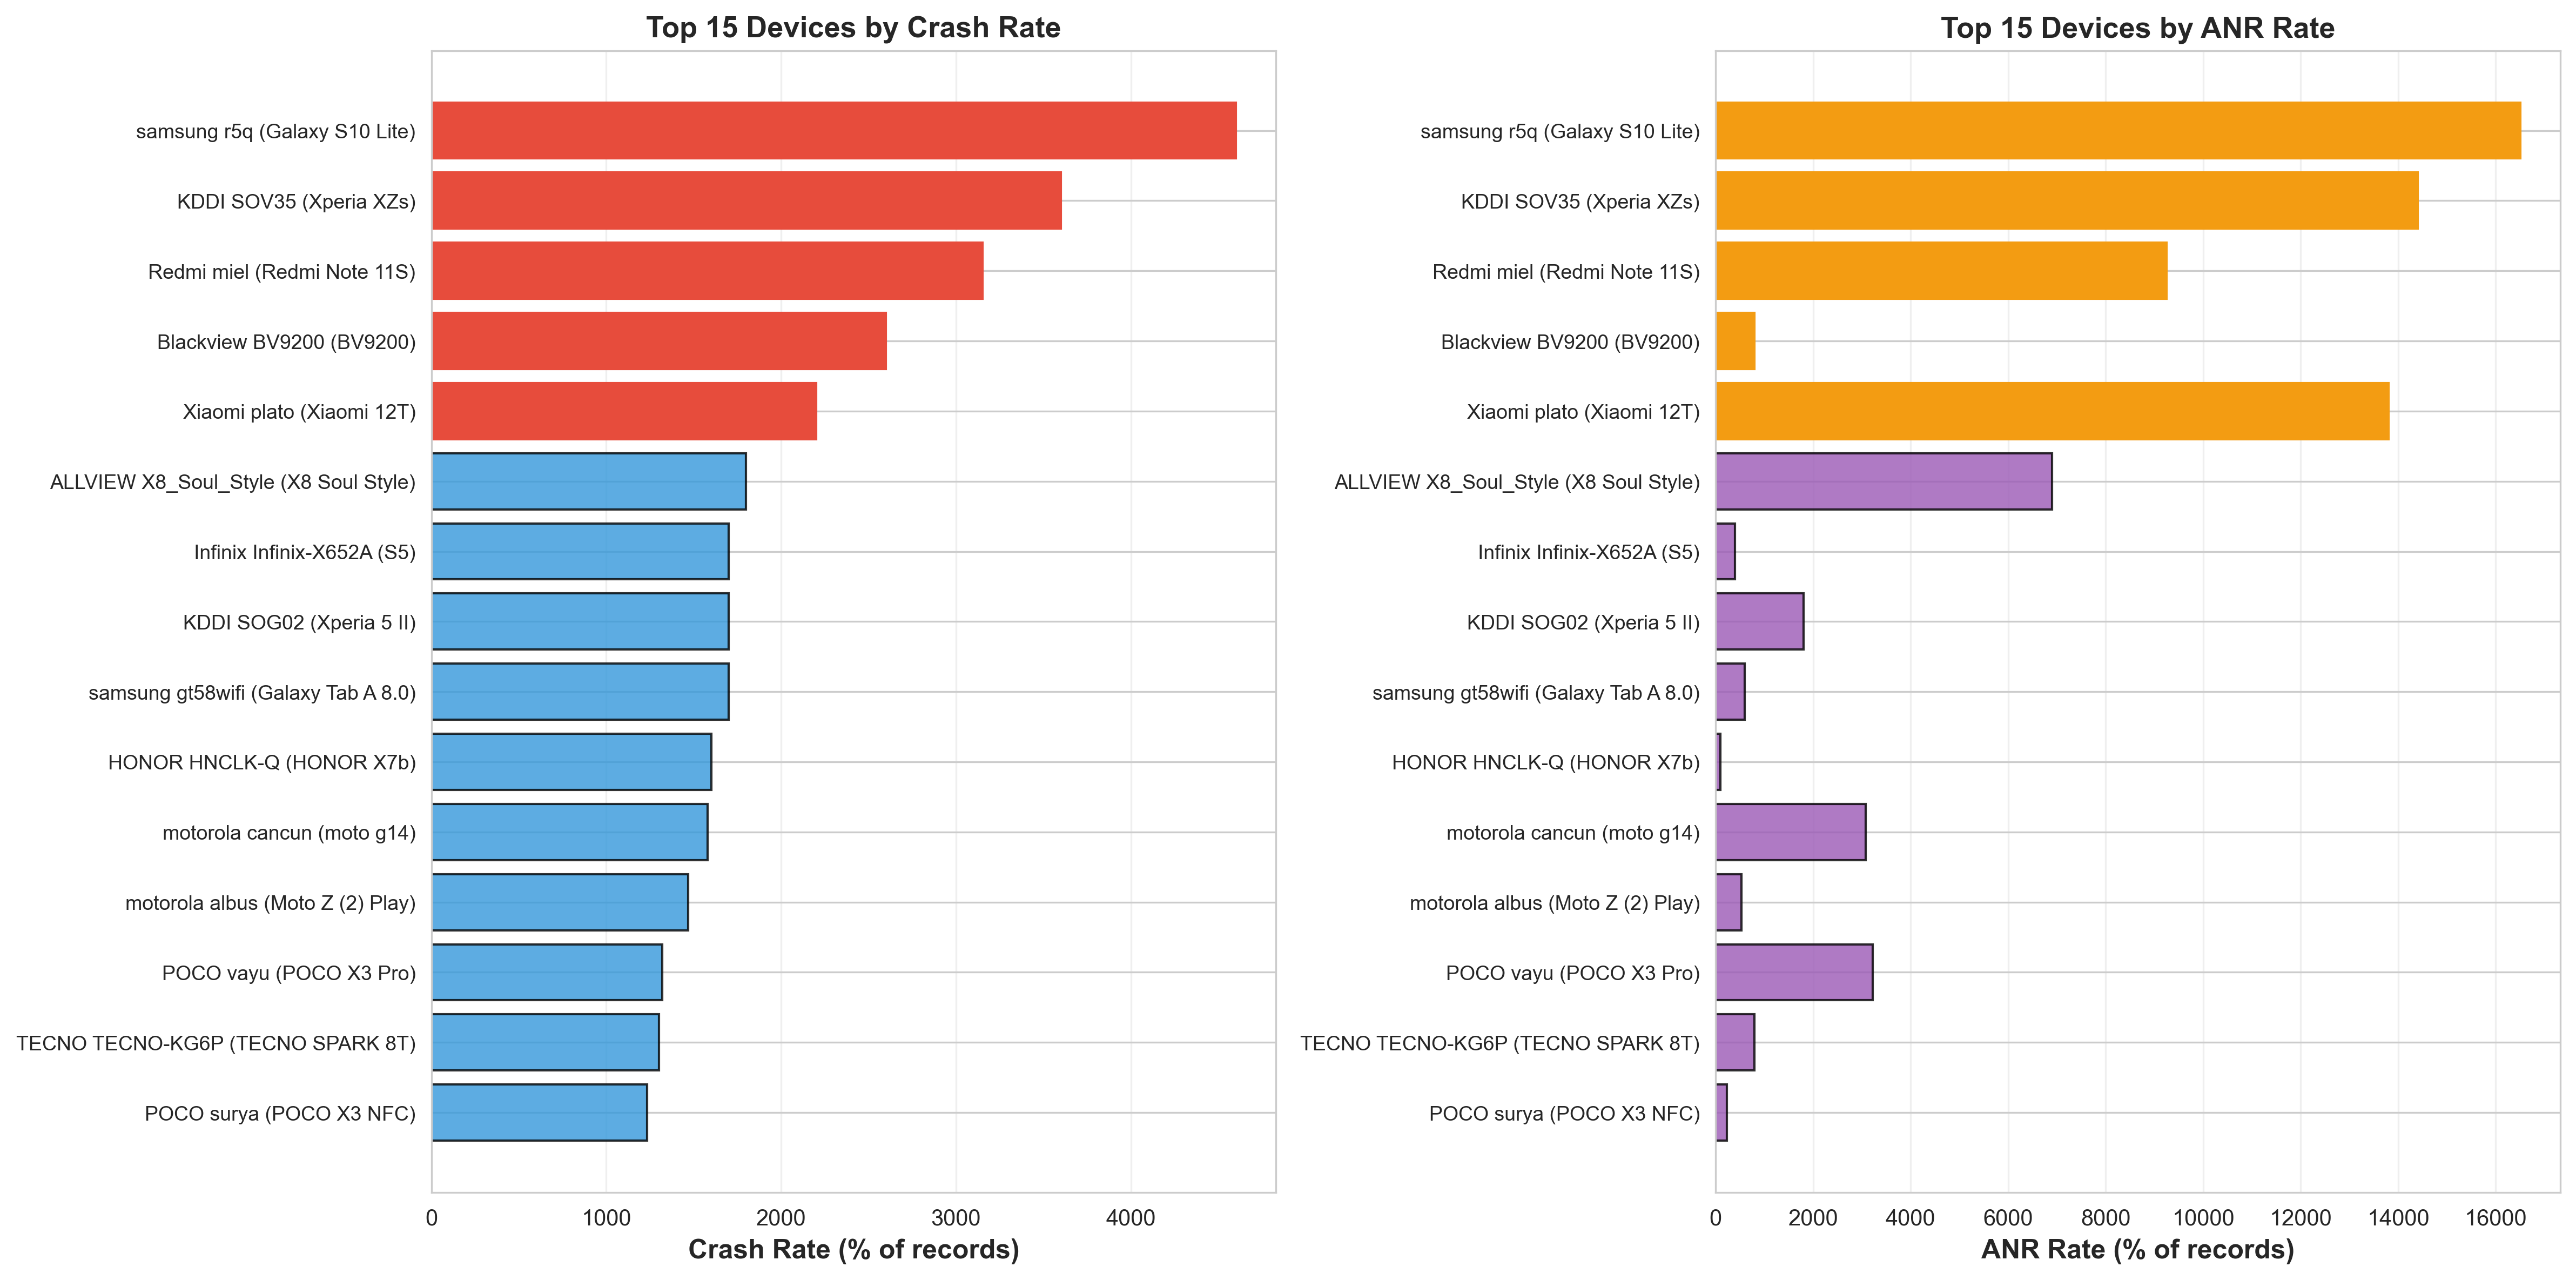

✓ Chart saved: batch2_crash_rate_by_device.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Load and prepare data
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\Combined_App_Performance.csv")
df.columns = df.columns.str.strip()

# Find columns
date_col = [col for col in df.columns if 'date' in col.lower()][0]
device_col = [col for col in df.columns if 'device' in col.lower()][0] if any('device' in col.lower() for col in df.columns) else None

# Keep required columns
columns_to_keep = ['Daily ANRs', 'Android OS Version', 'Daily Crashes', date_col]
if device_col:
    columns_to_keep.append(device_col)
df = df[columns_to_keep].copy()

# Clean data
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.rename(columns={date_col: 'Date'})
df['Daily Crashes'] = pd.to_numeric(df['Daily Crashes'], errors='coerce')
df['Daily ANRs'] = pd.to_numeric(df['Daily ANRs'], errors='coerce')
df = df.dropna(subset=['Date', 'Daily Crashes', 'Daily ANRs'])
if device_col:
    df = df.rename(columns={device_col: 'Device'})

# Calculate OS metrics
os_metrics = df.groupby('Android OS Version').agg({
    'Daily Crashes': ['sum', 'mean', 'count'],
    'Daily ANRs': ['sum', 'mean']
}).reset_index()
os_metrics.columns = ['OS_Version', 'Total_Crashes', 'Avg_Crashes', 'Record_Count',
                      'Total_ANRs', 'Avg_ANRs']
os_metrics['Crash_Rate'] = (os_metrics['Total_Crashes'] / os_metrics['Record_Count']) * 100
os_metrics['ANR_Rate'] = (os_metrics['Total_ANRs'] / os_metrics['Record_Count']) * 100
os_metrics = os_metrics.sort_values('Crash_Rate', ascending=False)

# PLOT 1: Crash Rate by OS Version
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Crash Rate
bars1 = axes[0].barh(range(len(os_metrics)), os_metrics['Crash_Rate'],
                     color='#3498db', alpha=0.8, edgecolor='black')
for i in range(min(3, len(bars1))):
    bars1[i].set_color('#e74c3c')
    bars1[i].set_alpha(1.0)

axes[0].set_yticks(range(len(os_metrics)))
axes[0].set_yticklabels(os_metrics['OS_Version'], fontsize=10)
axes[0].set_xlabel('Crash Rate (% of records)', fontsize=12, fontweight='bold')
axes[0].set_title('Crash Rate by Android OS Version', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

for i, v in enumerate(os_metrics['Crash_Rate']):
    axes[0].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

# ANR Rate
bars2 = axes[1].barh(range(len(os_metrics)), os_metrics['ANR_Rate'],
                     color='#9b59b6', alpha=0.8, edgecolor='black')
for i in range(min(3, len(bars2))):
    bars2[i].set_color('#f39c12')
    bars2[i].set_alpha(1.0)

axes[1].set_yticks(range(len(os_metrics)))
axes[1].set_yticklabels(os_metrics['OS_Version'], fontsize=10)
axes[1].set_xlabel('ANR Rate (% of records)', fontsize=12, fontweight='bold')
axes[1].set_title('ANR Rate by Android OS Version', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

for i, v in enumerate(os_metrics['ANR_Rate']):
    axes[1].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('batch2_crash_rate_by_os.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: batch2_crash_rate_by_os.png")

# PLOT 2: Crash Rate by Device (if available)
if 'Device' in df.columns:
    device_metrics = df.groupby('Device').agg({
        'Daily Crashes': ['sum', 'mean', 'count'],
        'Daily ANRs': ['sum', 'mean']
    }).reset_index()
    device_metrics.columns = ['Device', 'Total_Crashes', 'Avg_Crashes', 'Record_Count',
                              'Total_ANRs', 'Avg_ANRs']
    device_metrics['Crash_Rate'] = (device_metrics['Total_Crashes'] / device_metrics['Record_Count']) * 100
    device_metrics['ANR_Rate'] = (device_metrics['Total_ANRs'] / device_metrics['Record_Count']) * 100
    device_metrics = device_metrics.sort_values('Crash_Rate', ascending=False)

    top_devices = device_metrics.head(15)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Crash Rate
    bars1 = axes[0].barh(range(len(top_devices)), top_devices['Crash_Rate'],
                         color='#3498db', alpha=0.8, edgecolor='black')
    for i in range(min(5, len(bars1))):
        bars1[i].set_color('#e74c3c')
        bars1[i].set_alpha(1.0)

    axes[0].set_yticks(range(len(top_devices)))
    axes[0].set_yticklabels(top_devices['Device'], fontsize=9)
    axes[0].set_xlabel('Crash Rate (% of records)', fontsize=12, fontweight='bold')
    axes[0].set_title('Top 15 Devices by Crash Rate', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].invert_yaxis()

    # ANR Rate
    bars2 = axes[1].barh(range(len(top_devices)), top_devices['ANR_Rate'],
                         color='#9b59b6', alpha=0.8, edgecolor='black')
    for i in range(min(5, len(bars2))):
        bars2[i].set_color('#f39c12')
        bars2[i].set_alpha(1.0)

    axes[1].set_yticks(range(len(top_devices)))
    axes[1].set_yticklabels(top_devices['Device'], fontsize=9)
    axes[1].set_xlabel('ANR Rate (% of records)', fontsize=12, fontweight='bold')
    axes[1].set_title('Top 15 Devices by ANR Rate', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.savefig('batch2_crash_rate_by_device.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Chart saved: batch2_crash_rate_by_device.png")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

print("="*70)
print("BATCH 3: TOP OFFENDING OS VERSIONS & DEVICES")
print("="*70)

# Load the data
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\Combined_App_Performance.csv")
df.columns = df.columns.str.strip()

# Find columns
date_col = [col for col in df.columns if 'date' in col.lower()][0]
device_col = [col for col in df.columns if 'device' in col.lower()][0] if any('device' in col.lower() for col in df.columns) else None

# Keep only required columns
columns_to_keep = ['Daily ANRs', 'Android OS Version', 'Daily Crashes', date_col]
if device_col:
    columns_to_keep.append(device_col)

df = df[columns_to_keep].copy()

# Clean data
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.rename(columns={date_col: 'Date'})
df['Daily Crashes'] = pd.to_numeric(df['Daily Crashes'], errors='coerce')
df['Daily ANRs'] = pd.to_numeric(df['Daily ANRs'], errors='coerce')
df = df.dropna(subset=['Date', 'Daily Crashes', 'Daily ANRs'])

if device_col:
    df = df.rename(columns={device_col: 'Device'})

print(f"Dataset loaded: {len(df):,} records")

# ===========================================================================
# 4. TOP OFFENDING ANDROID OS VERSIONS
# ===========================================================================

print("\n4. TOP OFFENDING ANDROID OS VERSIONS")
print("-" * 70)

os_detailed = df.groupby('Android OS Version').agg({
    'Daily Crashes': ['sum', 'mean', 'count'],
    'Daily ANRs': ['sum', 'mean']
}).reset_index()

os_detailed.columns = ['OS_Version', 'Total_Crashes', 'Avg_Crashes', 'Record_Count',
                       'Total_ANRs', 'Avg_ANRs']

os_detailed['Crash_Rate'] = (os_detailed['Total_Crashes'] / os_detailed['Record_Count']) * 100

# A. Top by ABSOLUTE crash count
top_absolute_os = os_detailed.nlargest(10, 'Total_Crashes')

print("\n TOP 10 OS VERSIONS BY ABSOLUTE CRASH COUNT:")
print(top_absolute_os[['OS_Version', 'Total_Crashes', 'Total_ANRs', 'Record_Count', 'Crash_Rate']].to_string(index=False))

# B. Top by RELATIVE crash rate (minimum 10 records)
top_relative_os = os_detailed[os_detailed['Record_Count'] >= 10].nlargest(10, 'Crash_Rate')

print("\n\n TOP 10 OS VERSIONS BY RELATIVE CRASH RATE (min 10 records):")
print(top_relative_os[['OS_Version', 'Crash_Rate', 'Total_Crashes', 'Record_Count']].to_string(index=False))

# Visualization - Top Offending OS Versions
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Absolute crashes
colors_abs = ['#e74c3c' if i < 3 else '#3498db' for i in range(len(top_absolute_os))]
bars1 = axes[0].barh(range(len(top_absolute_os)), top_absolute_os['Total_Crashes'],
                     color=colors_abs, alpha=0.8, edgecolor='black')
axes[0].set_yticks(range(len(top_absolute_os)))
axes[0].set_yticklabels(top_absolute_os['OS_Version'], fontsize=10)
axes[0].set_xlabel('Total Crashes', fontsize=12, fontweight='bold')
axes[0].set_title('Top 10 OS: Highest Absolute Crashes', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_absolute_os['Total_Crashes']):
    axes[0].text(v + (v*0.02), i, f'{v:,.0f}', va='center', fontsize=9, fontweight='bold')

# Relative crash rate
colors_rel = ['#e74c3c' if i < 3 else '#f39c12' for i in range(len(top_relative_os))]
bars2 = axes[1].barh(range(len(top_relative_os)), top_relative_os['Crash_Rate'],
                     color=colors_rel, alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(top_relative_os)))
axes[1].set_yticklabels(top_relative_os['OS_Version'], fontsize=10)
axes[1].set_xlabel('Crash Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Top 10 OS: Highest Relative Crash Rate', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(top_relative_os['Crash_Rate']):
    axes[1].text(v + (v*0.02), i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('batch3_top_offending_os.png', dpi=300, bbox_inches='tight')
print("\n✓ Chart saved: batch3_top_offending_os.png")
plt.close()

# ===========================================================================
# 5. TOP OFFENDING DEVICES (if Device column exists)
# ===========================================================================

if 'Device' in df.columns:
    print("\n\n5. TOP OFFENDING DEVICES")
    print("-" * 70)

    device_detailed = df.groupby('Device').agg({
        'Daily Crashes': ['sum', 'mean', 'count'],
        'Daily ANRs': ['sum', 'mean']
    }).reset_index()

    device_detailed.columns = ['Device', 'Total_Crashes', 'Avg_Crashes', 'Record_Count',
                               'Total_ANRs', 'Avg_ANRs']

    device_detailed['Crash_Rate'] = (device_detailed['Total_Crashes'] / device_detailed['Record_Count']) * 100

    # A. Top by ABSOLUTE crash count
    top_absolute_device = device_detailed.nlargest(15, 'Total_Crashes')

    print("\n📊 TOP 15 DEVICES BY ABSOLUTE CRASH COUNT:")
    print(top_absolute_device[['Device', 'Total_Crashes', 'Total_ANRs', 'Record_Count', 'Crash_Rate']].to_string(index=False))

    # B. Top by RELATIVE crash rate (minimum 10 records)
    top_relative_device = device_detailed[device_detailed['Record_Count'] >= 10].nlargest(15, 'Crash_Rate')

    print("\n\n📊 TOP 15 DEVICES BY RELATIVE CRASH RATE (min 10 records):")
    print(top_relative_device[['Device', 'Crash_Rate', 'Total_Crashes', 'Record_Count']].to_string(index=False))

    # Visualization - Top Offending Devices
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))

    # Absolute crashes
    colors_abs = ['#e74c3c' if i < 5 else '#3498db' for i in range(len(top_absolute_device))]
    bars1 = axes[0].barh(range(len(top_absolute_device)), top_absolute_device['Total_Crashes'],
                         color=colors_abs, alpha=0.8, edgecolor='black')
    axes[0].set_yticks(range(len(top_absolute_device)))
    axes[0].set_yticklabels(top_absolute_device['Device'], fontsize=9)
    axes[0].set_xlabel('Total Crashes', fontsize=12, fontweight='bold')
    axes[0].set_title('Top 15 Devices: Highest Absolute Crashes', fontsize=13, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(top_absolute_device['Total_Crashes']):
        axes[0].text(v + (v*0.02), i, f'{v:,.0f}', va='center', fontsize=8, fontweight='bold')

    # Relative crash rate
    colors_rel = ['#e74c3c' if i < 5 else '#f39c12' for i in range(len(top_relative_device))]
    bars2 = axes[1].barh(range(len(top_relative_device)), top_relative_device['Crash_Rate'],
                         color=colors_rel, alpha=0.8, edgecolor='black')
    axes[1].set_yticks(range(len(top_relative_device)))
    axes[1].set_yticklabels(top_relative_device['Device'], fontsize=9)
    axes[1].set_xlabel('Crash Rate (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Top 15 Devices: Highest Relative Crash Rate', fontsize=13, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(top_relative_device['Crash_Rate']):
        axes[1].text(v + (v*0.02), i, f'{v:.1f}%', va='center', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.savefig('batch3_top_offending_devices.png', dpi=300, bbox_inches='tight')
    print("\n✓ Chart saved: batch3_top_offending_devices.png")
    plt.close()

else:
    print("\n\n5. DEVICE ANALYSIS SKIPPED")
    print("-" * 70)
    print("No Device column found in dataset.")

# Summary of top offenders
print("\n\n" + "="*70)
print("SUMMARY: KEY OFFENDERS IDENTIFIED")
print("="*70)

print(f"\n WORST OS VERSION (Absolute): {top_absolute_os.iloc[0]['OS_Version']}")
print(f"   Total Crashes: {top_absolute_os.iloc[0]['Total_Crashes']:,.0f}")
print(f"   Crash Rate: {top_absolute_os.iloc[0]['Crash_Rate']:.2f}%")

print(f"\n WORST OS VERSION (Relative): {top_relative_os.iloc[0]['OS_Version']}")
print(f"   Crash Rate: {top_relative_os.iloc[0]['Crash_Rate']:.2f}%")
print(f"   Total Crashes: {top_relative_os.iloc[0]['Total_Crashes']:,.0f}")

if 'Device' in df.columns:
    print(f"\n WORST DEVICE (Absolute): {top_absolute_device.iloc[0]['Device']}")
    print(f"   Total Crashes: {top_absolute_device.iloc[0]['Total_Crashes']:,.0f}")

BATCH 3: TOP OFFENDING OS VERSIONS & DEVICES
Dataset loaded: 3,391 records

4. TOP OFFENDING ANDROID OS VERSIONS
----------------------------------------------------------------------

 TOP 10 OS VERSIONS BY ABSOLUTE CRASH COUNT:
 OS_Version  Total_Crashes  Total_ANRs  Record_Count  Crash_Rate
 Android 14         1076.0      4176.0            28 3842.857143
  Android 9          679.0       182.0            28 2425.000000
 Android 13          381.0       325.0            28 1360.714286
 Android 12          290.0       562.0            28 1035.714286
 Android 11          238.0       375.0            28  850.000000
 Android 10          195.0       330.0            28  696.428571
Android 8.1          135.0       243.0            28  482.142857
Android 7.1           93.0        64.0            23  404.347826
Android 8.0           49.0        21.0            22  222.727273
 Android 15           44.0       180.0            28  157.142857


 TOP 10 OS VERSIONS BY RELATIVE CRASH RATE (min 10 re

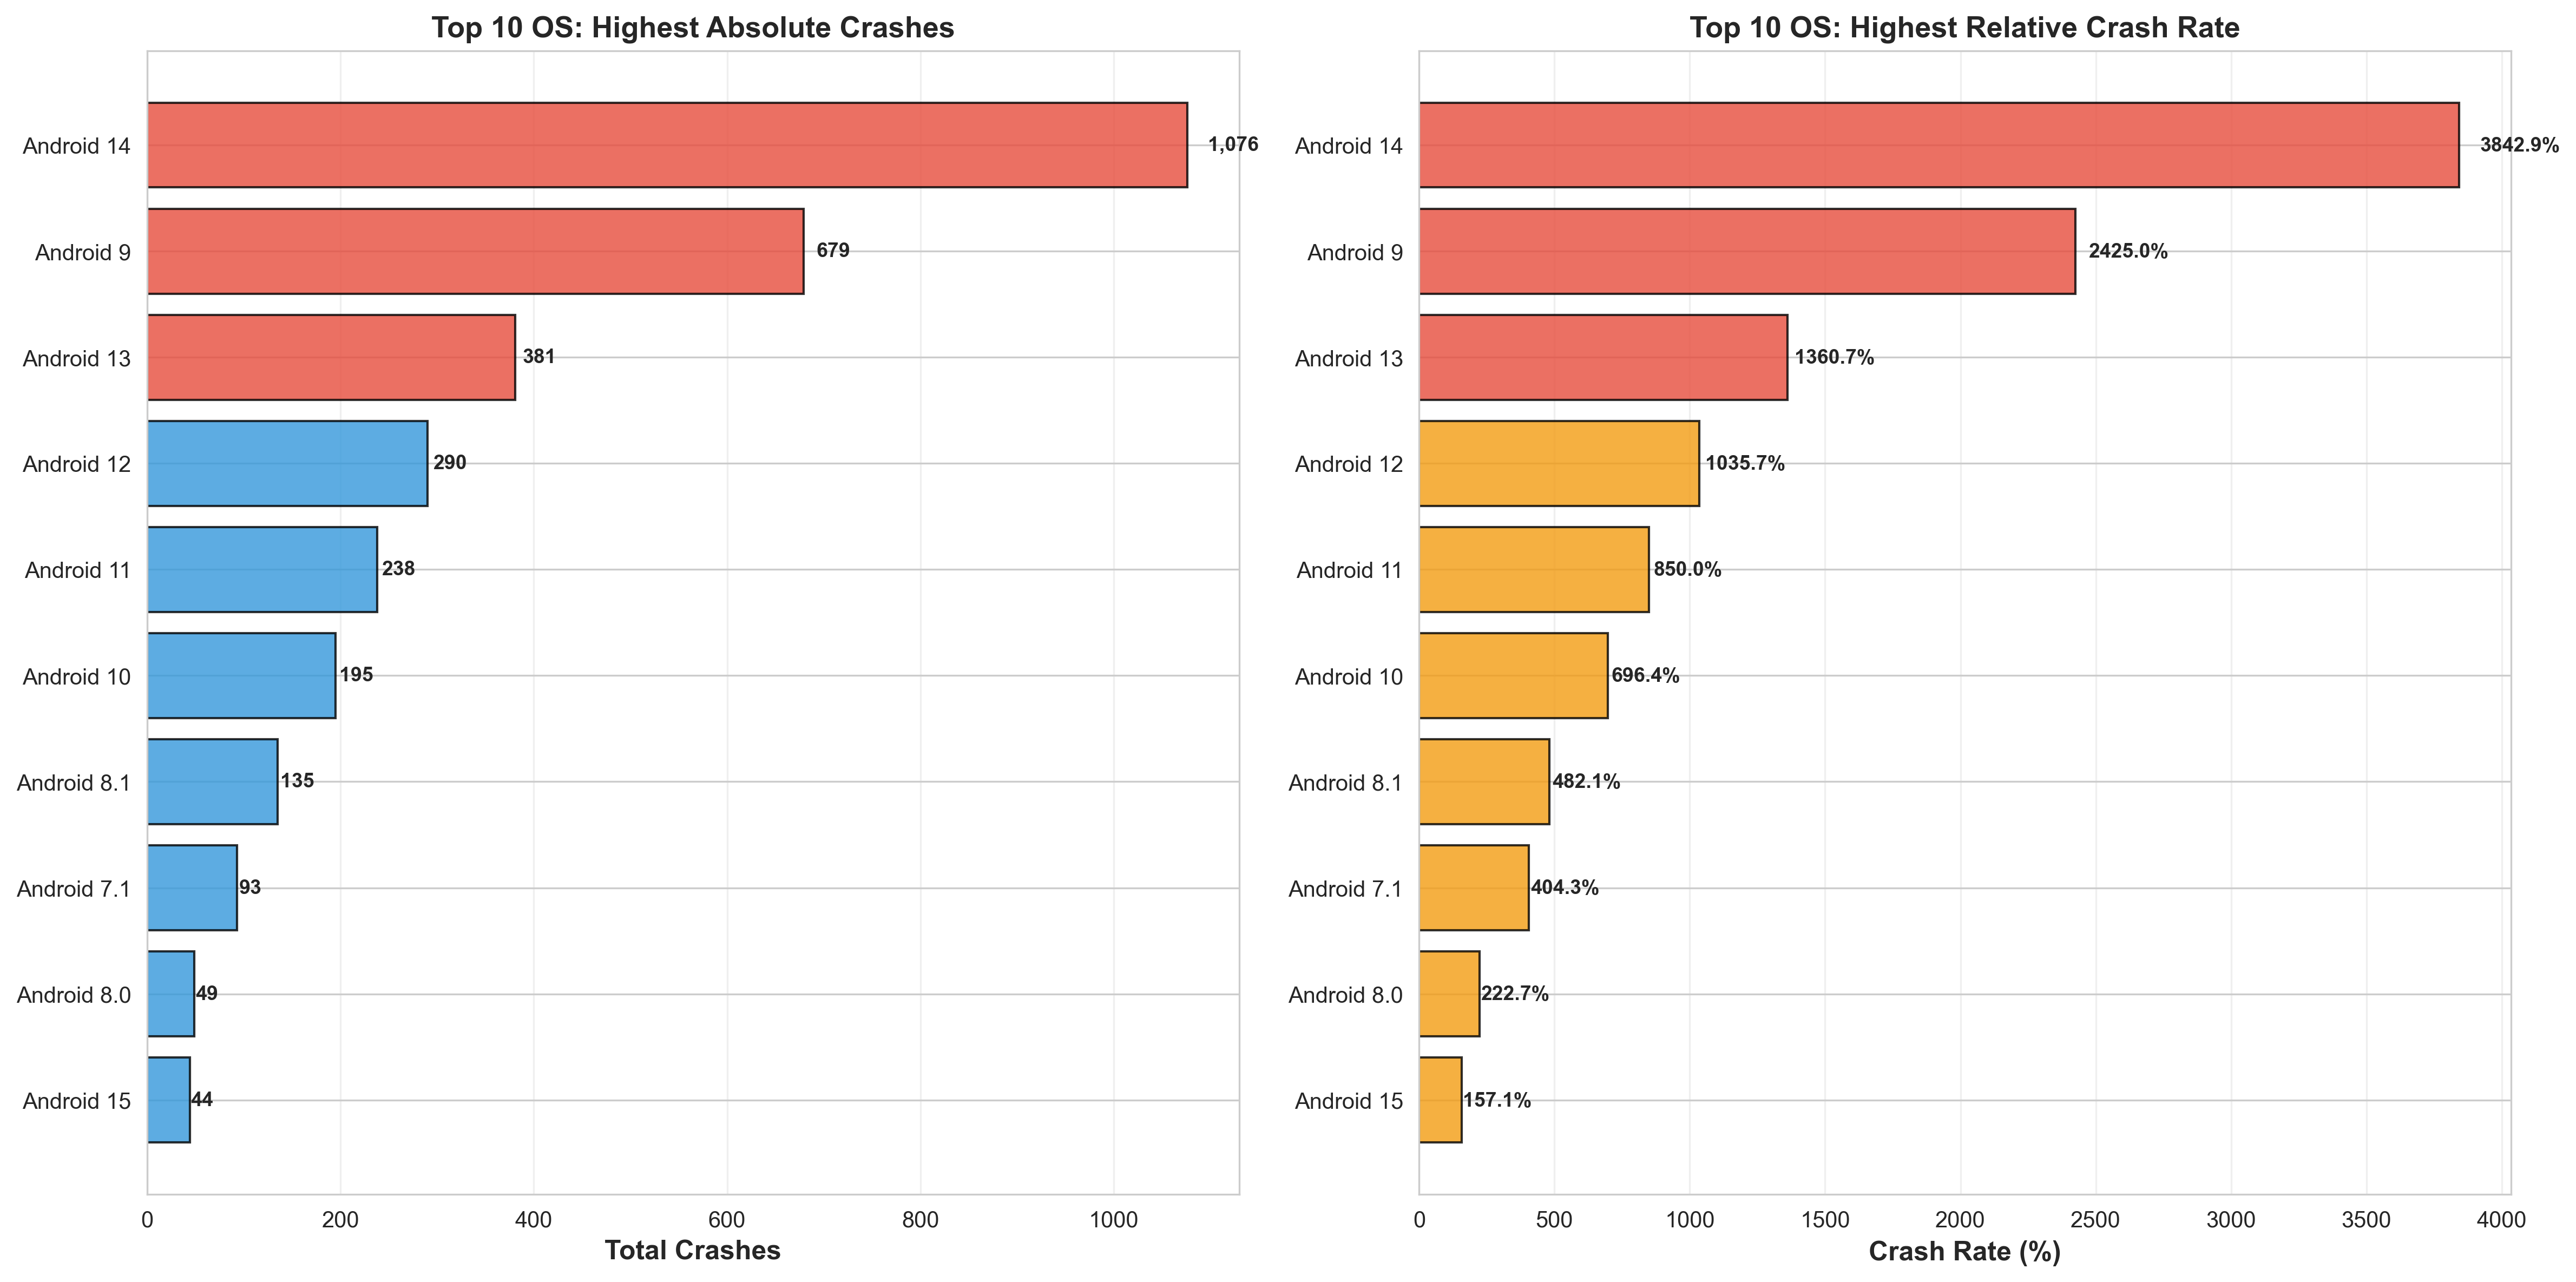

✓ Chart saved: batch3_top_offending_os.png


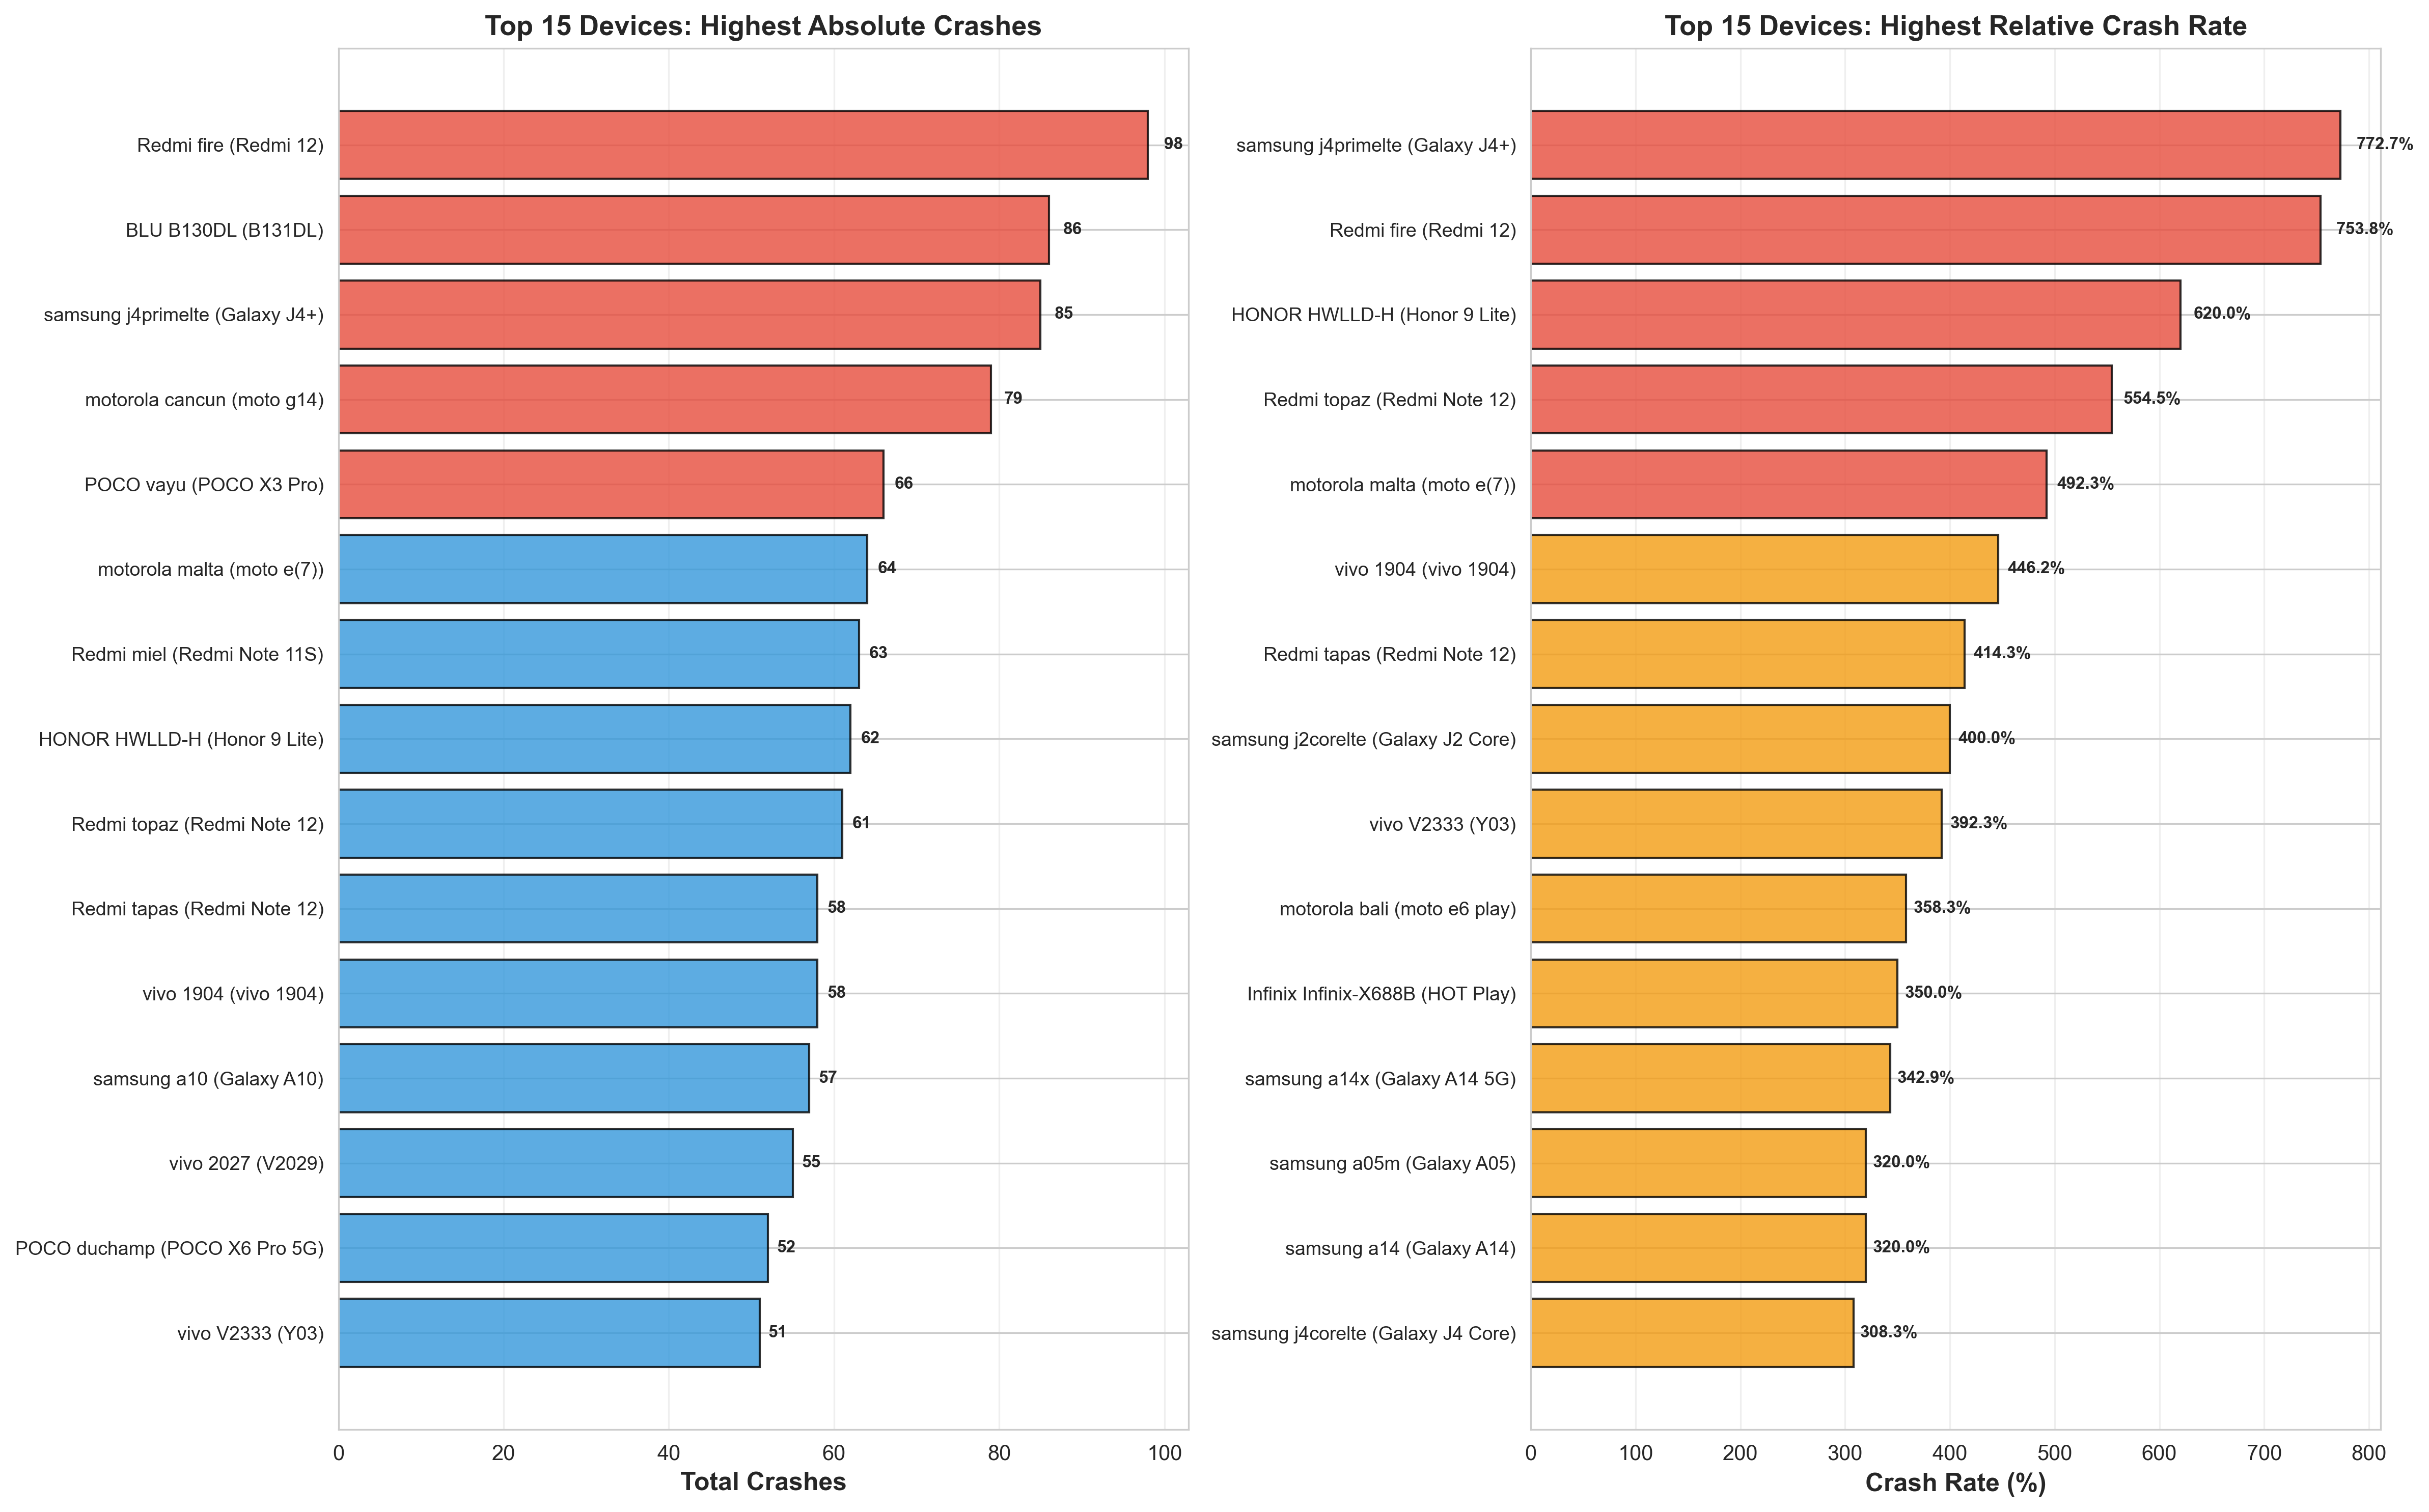

✓ Chart saved: batch3_top_offending_devices.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Load and prepare data
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\Combined_App_Performance.csv")
df.columns = df.columns.str.strip()

# Find columns
date_col = [col for col in df.columns if 'date' in col.lower()][0]
device_col = [col for col in df.columns if 'device' in col.lower()][0] if any('device' in col.lower() for col in df.columns) else None

# Keep required columns
columns_to_keep = ['Daily ANRs', 'Android OS Version', 'Daily Crashes', date_col]
if device_col:
    columns_to_keep.append(device_col)
df = df[columns_to_keep].copy()

# Clean data
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.rename(columns={date_col: 'Date'})
df['Daily Crashes'] = pd.to_numeric(df['Daily Crashes'], errors='coerce')
df['Daily ANRs'] = pd.to_numeric(df['Daily ANRs'], errors='coerce')
df = df.dropna(subset=['Date', 'Daily Crashes', 'Daily ANRs'])
if device_col:
    df = df.rename(columns={device_col: 'Device'})

# Calculate OS detailed metrics
os_detailed = df.groupby('Android OS Version').agg({
    'Daily Crashes': ['sum', 'mean', 'count'],
    'Daily ANRs': ['sum', 'mean']
}).reset_index()
os_detailed.columns = ['OS_Version', 'Total_Crashes', 'Avg_Crashes', 'Record_Count',
                       'Total_ANRs', 'Avg_ANRs']
os_detailed['Crash_Rate'] = (os_detailed['Total_Crashes'] / os_detailed['Record_Count']) * 100

# Top OS by absolute and relative
top_absolute_os = os_detailed.nlargest(10, 'Total_Crashes')
top_relative_os = os_detailed[os_detailed['Record_Count'] >= 10].nlargest(10, 'Crash_Rate')

# PLOT 1: Top Offending OS Versions
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Absolute crashes
colors_abs = ['#e74c3c' if i < 3 else '#3498db' for i in range(len(top_absolute_os))]
bars1 = axes[0].barh(range(len(top_absolute_os)), top_absolute_os['Total_Crashes'],
                     color=colors_abs, alpha=0.8, edgecolor='black')
axes[0].set_yticks(range(len(top_absolute_os)))
axes[0].set_yticklabels(top_absolute_os['OS_Version'], fontsize=10)
axes[0].set_xlabel('Total Crashes', fontsize=12, fontweight='bold')
axes[0].set_title('Top 10 OS: Highest Absolute Crashes', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

for i, v in enumerate(top_absolute_os['Total_Crashes']):
    axes[0].text(v + (v*0.02), i, f'{v:,.0f}', va='center', fontsize=9, fontweight='bold')

# Relative crash rate
colors_rel = ['#e74c3c' if i < 3 else '#f39c12' for i in range(len(top_relative_os))]
bars2 = axes[1].barh(range(len(top_relative_os)), top_relative_os['Crash_Rate'],
                     color=colors_rel, alpha=0.8, edgecolor='black')
axes[1].set_yticks(range(len(top_relative_os)))
axes[1].set_yticklabels(top_relative_os['OS_Version'], fontsize=10)
axes[1].set_xlabel('Crash Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Top 10 OS: Highest Relative Crash Rate', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

for i, v in enumerate(top_relative_os['Crash_Rate']):
    axes[1].text(v + (v*0.02), i, f'{v:.1f}%', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('batch3_top_offending_os.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: batch3_top_offending_os.png")

# PLOT 2: Top Offending Devices (if available)
if 'Device' in df.columns:
    device_detailed = df.groupby('Device').agg({
        'Daily Crashes': ['sum', 'mean', 'count'],
        'Daily ANRs': ['sum', 'mean']
    }).reset_index()
    device_detailed.columns = ['Device', 'Total_Crashes', 'Avg_Crashes', 'Record_Count',
                               'Total_ANRs', 'Avg_ANRs']
    device_detailed['Crash_Rate'] = (device_detailed['Total_Crashes'] / device_detailed['Record_Count']) * 100

    top_absolute_device = device_detailed.nlargest(15, 'Total_Crashes')
    top_relative_device = device_detailed[device_detailed['Record_Count'] >= 10].nlargest(15, 'Crash_Rate')

    fig, axes = plt.subplots(1, 2, figsize=(16, 10))

    # Absolute crashes
    colors_abs = ['#e74c3c' if i < 5 else '#3498db' for i in range(len(top_absolute_device))]
    bars1 = axes[0].barh(range(len(top_absolute_device)), top_absolute_device['Total_Crashes'],
                         color=colors_abs, alpha=0.8, edgecolor='black')
    axes[0].set_yticks(range(len(top_absolute_device)))
    axes[0].set_yticklabels(top_absolute_device['Device'], fontsize=9)
    axes[0].set_xlabel('Total Crashes', fontsize=12, fontweight='bold')
    axes[0].set_title('Top 15 Devices: Highest Absolute Crashes', fontsize=13, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')

    for i, v in enumerate(top_absolute_device['Total_Crashes']):
        axes[0].text(v + (v*0.02), i, f'{v:,.0f}', va='center', fontsize=8, fontweight='bold')

    # Relative crash rate
    colors_rel = ['#e74c3c' if i < 5 else '#f39c12' for i in range(len(top_relative_device))]
    bars2 = axes[1].barh(range(len(top_relative_device)), top_relative_device['Crash_Rate'],
                         color=colors_rel, alpha=0.8, edgecolor='black')
    axes[1].set_yticks(range(len(top_relative_device)))
    axes[1].set_yticklabels(top_relative_device['Device'], fontsize=9)
    axes[1].set_xlabel('Crash Rate (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Top 15 Devices: Highest Relative Crash Rate', fontsize=13, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')

    for i, v in enumerate(top_relative_device['Crash_Rate']):
        axes[1].text(v + (v*0.02), i, f'{v:.1f}%', va='center', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.savefig('batch3_top_offending_devices.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Chart saved: batch3_top_offending_devices.png")

**Data-forensic analyses (how to use Crashes, ANRs, Device type, OS version)**

B. ANOMALY DETECTION & STATISTICAL ANALYSIS

1. GROUP COMPARISON ANALYSIS
----------------------------------------------------------------------

📊 OS Version Comparison:
 OS_Version  Sample_Size  Avg_Crashes   Avg_ANRs  Crash_Rate     ANR_Rate
 Android 10           28     6.964286  11.785714  696.428571  1178.571429
 Android 11           28     8.500000  13.392857  850.000000  1339.285714
 Android 12           28    10.357143  20.071429 1035.714286  2007.142857
Android 12L            2     0.000000   1.000000    0.000000   100.000000
 Android 13           28    13.607143  11.607143 1360.714286  1160.714286
 Android 14           28    38.428571 149.142857 3842.857143 14914.285714
 Android 15           28     1.571429   6.428571  157.142857   642.857143
Android 6.0           21     0.761905   2.285714   76.190476   228.571429
Android 7.0           17     0.352941   2.058824   35.294118   205.882353
Android 7.1           23     4.043478   2.782609  404.347826   278.260870
Android 8.0    

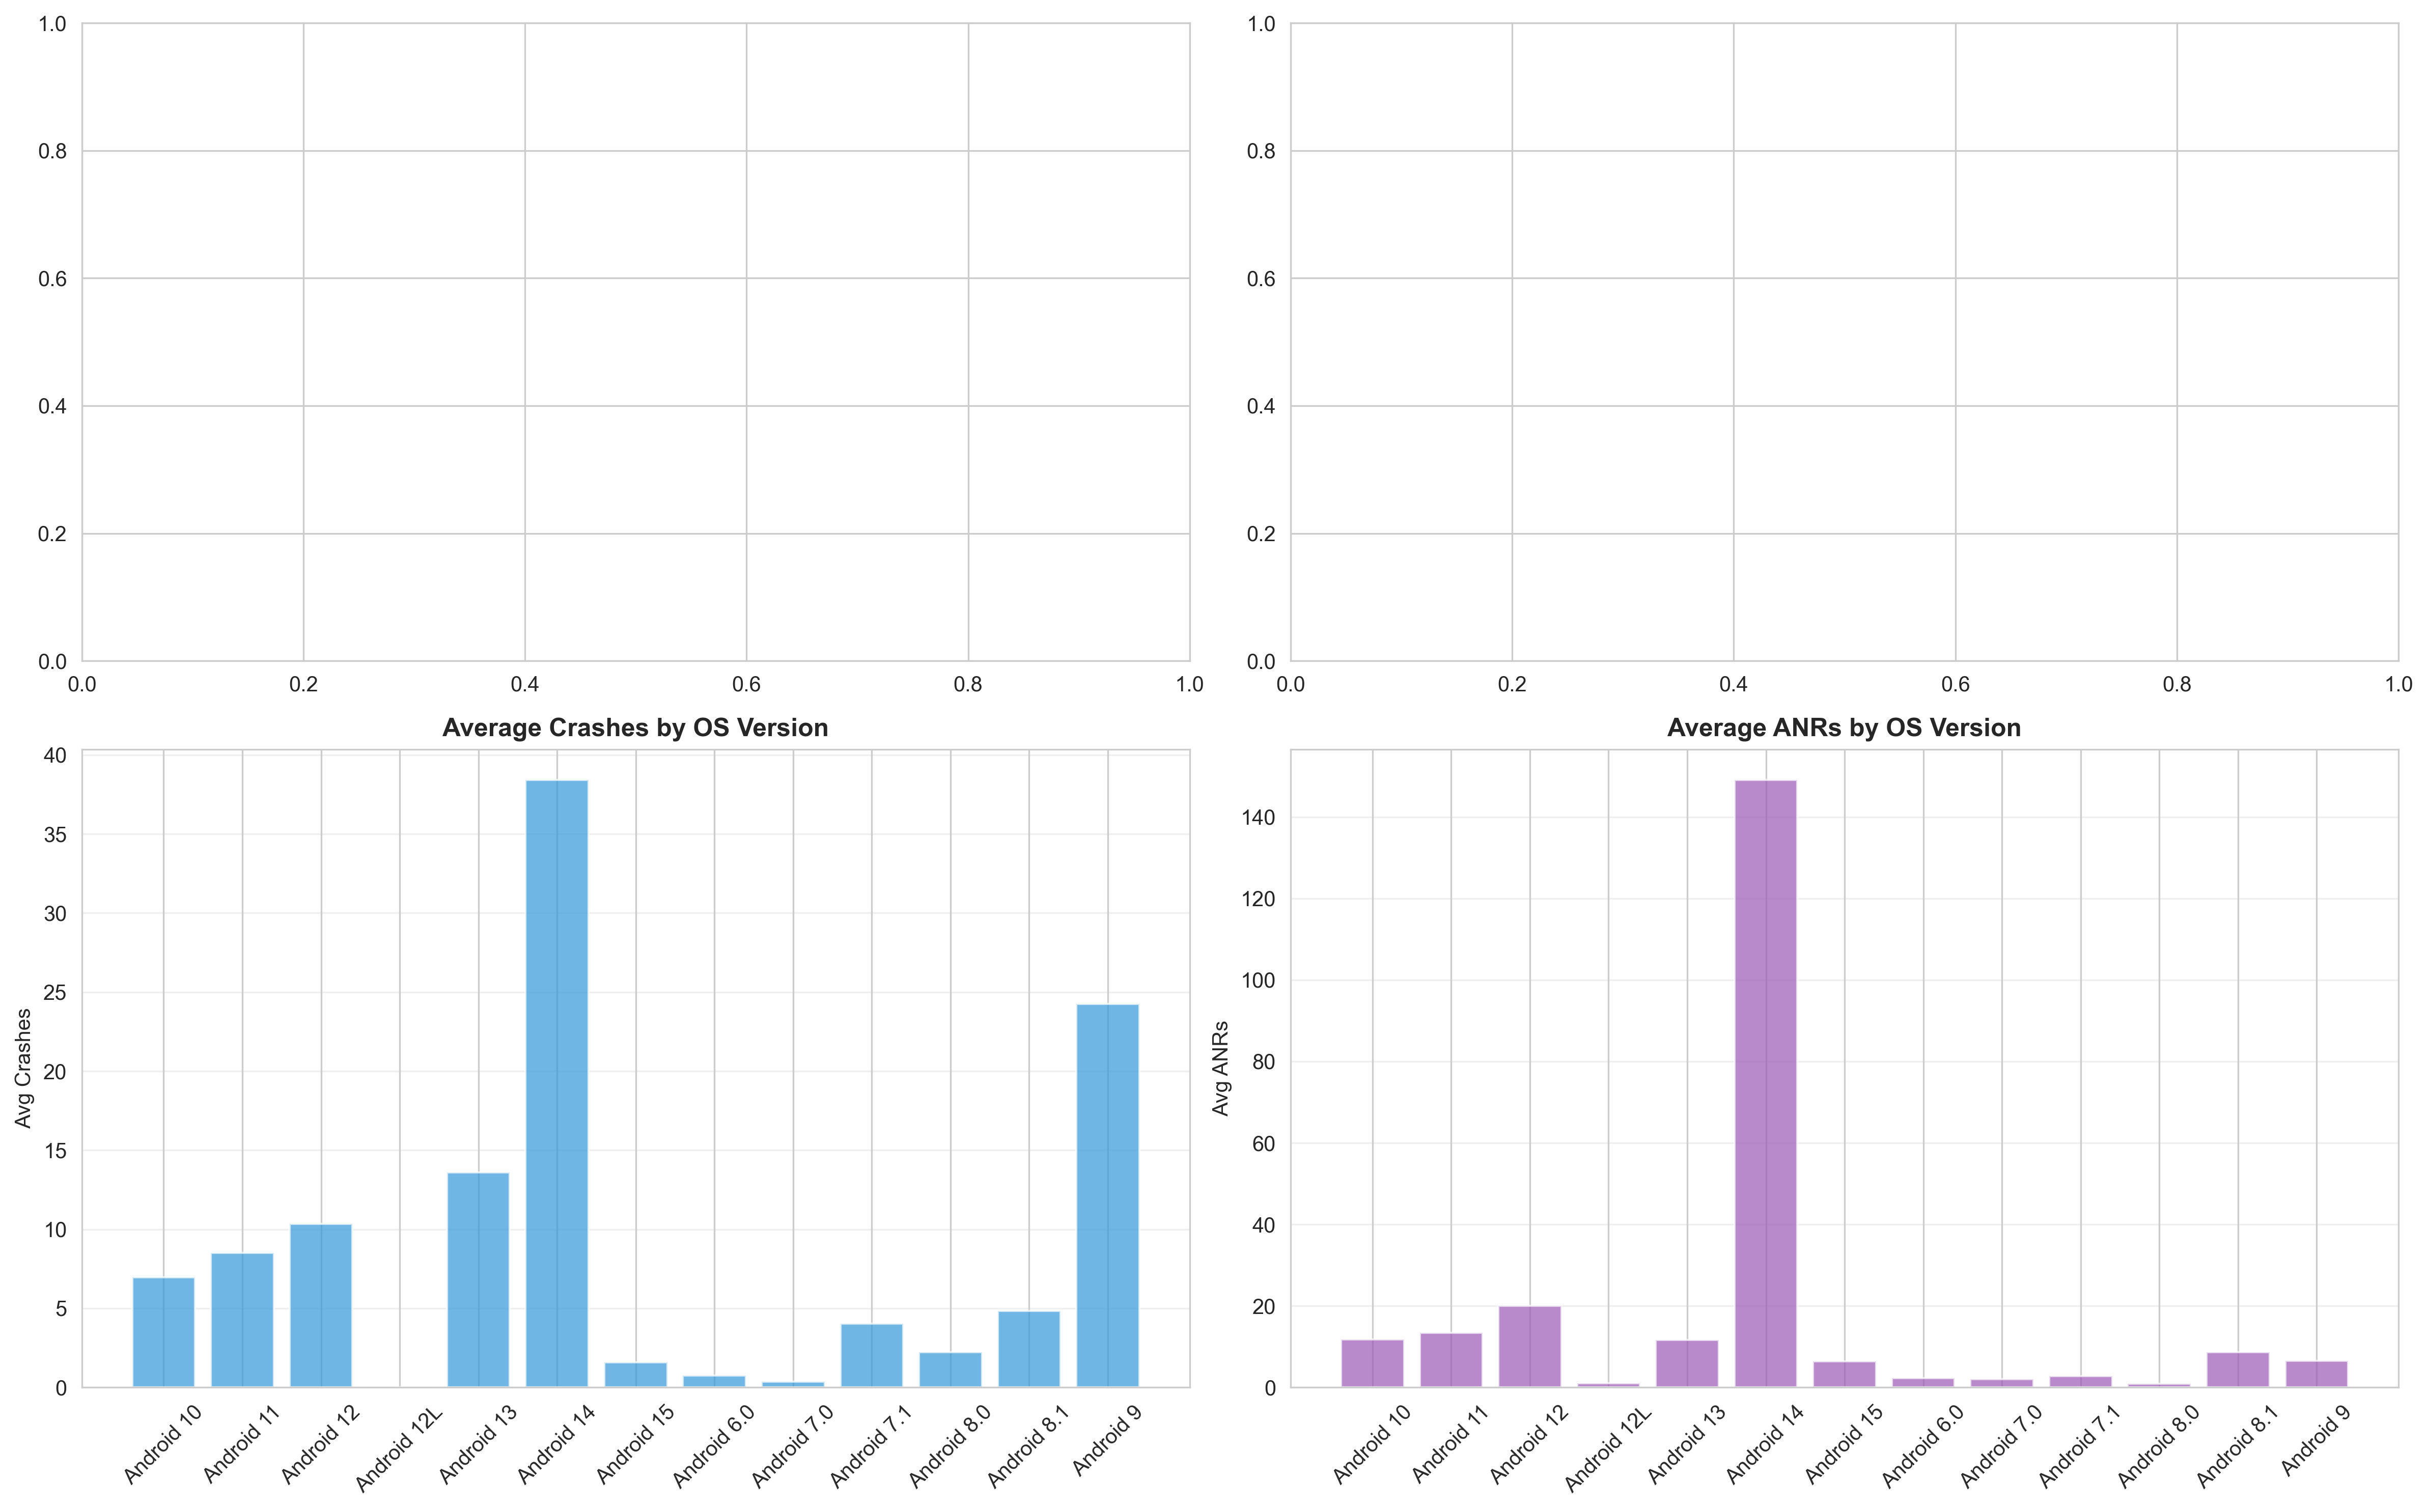

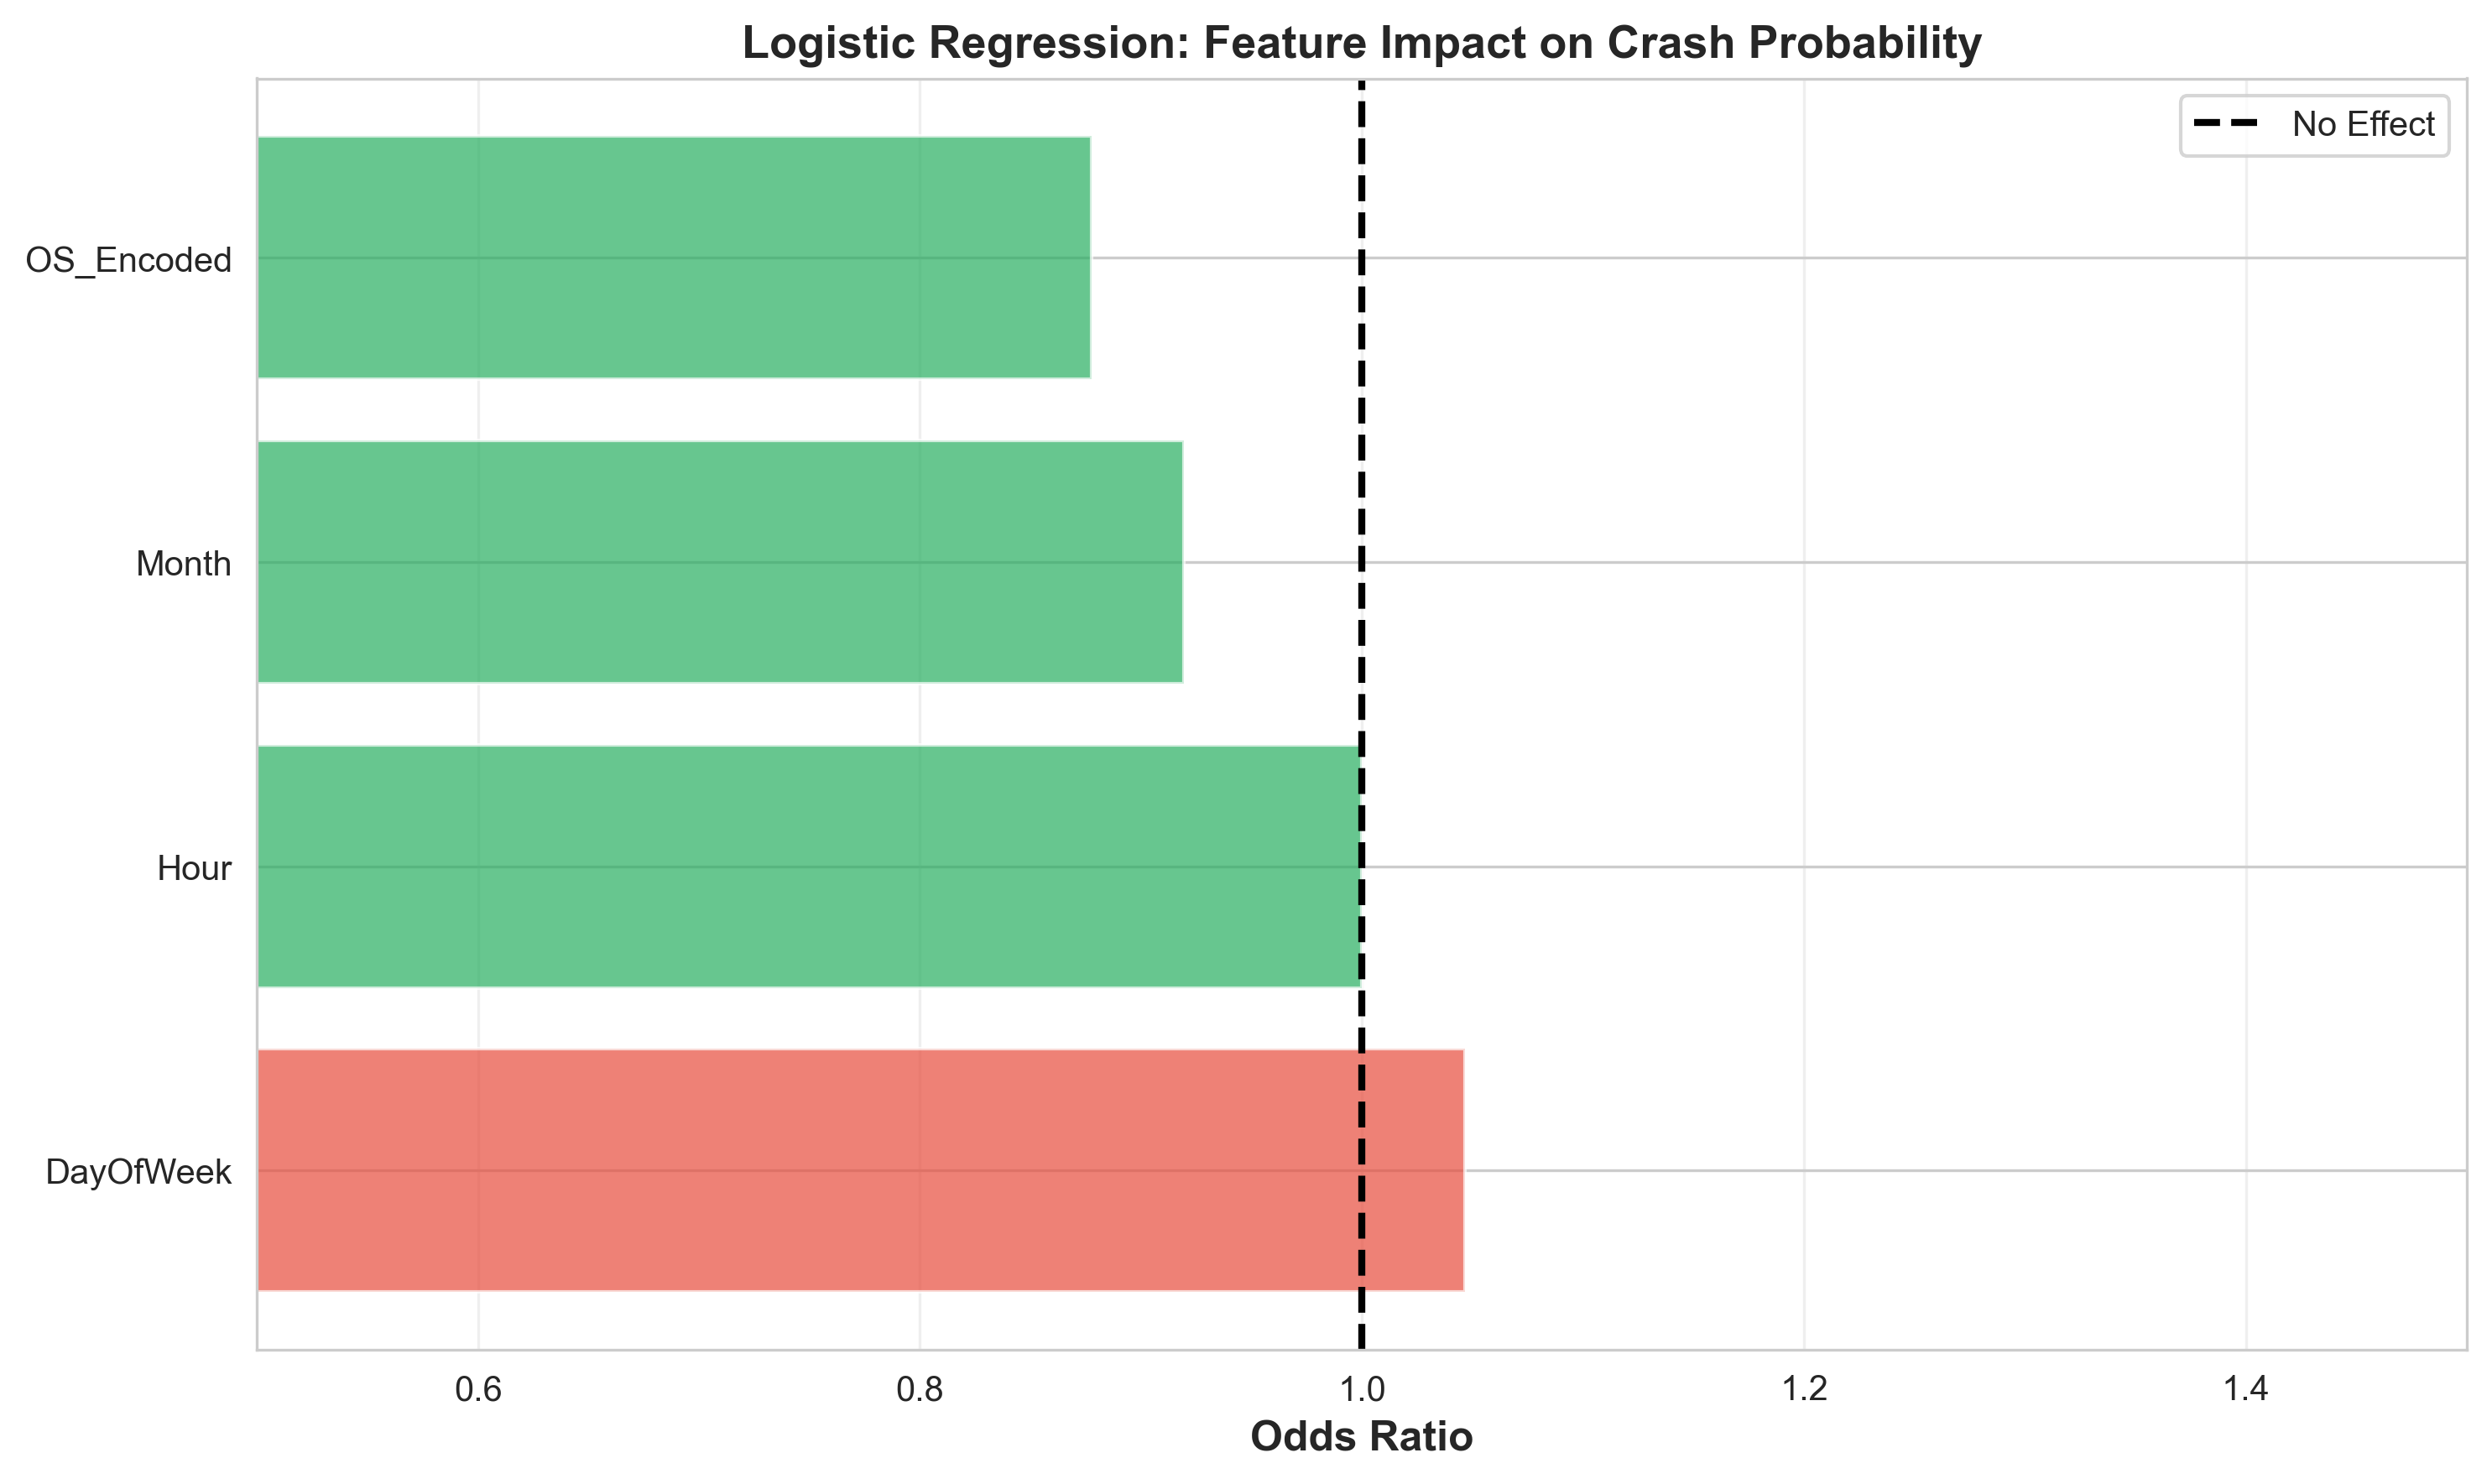

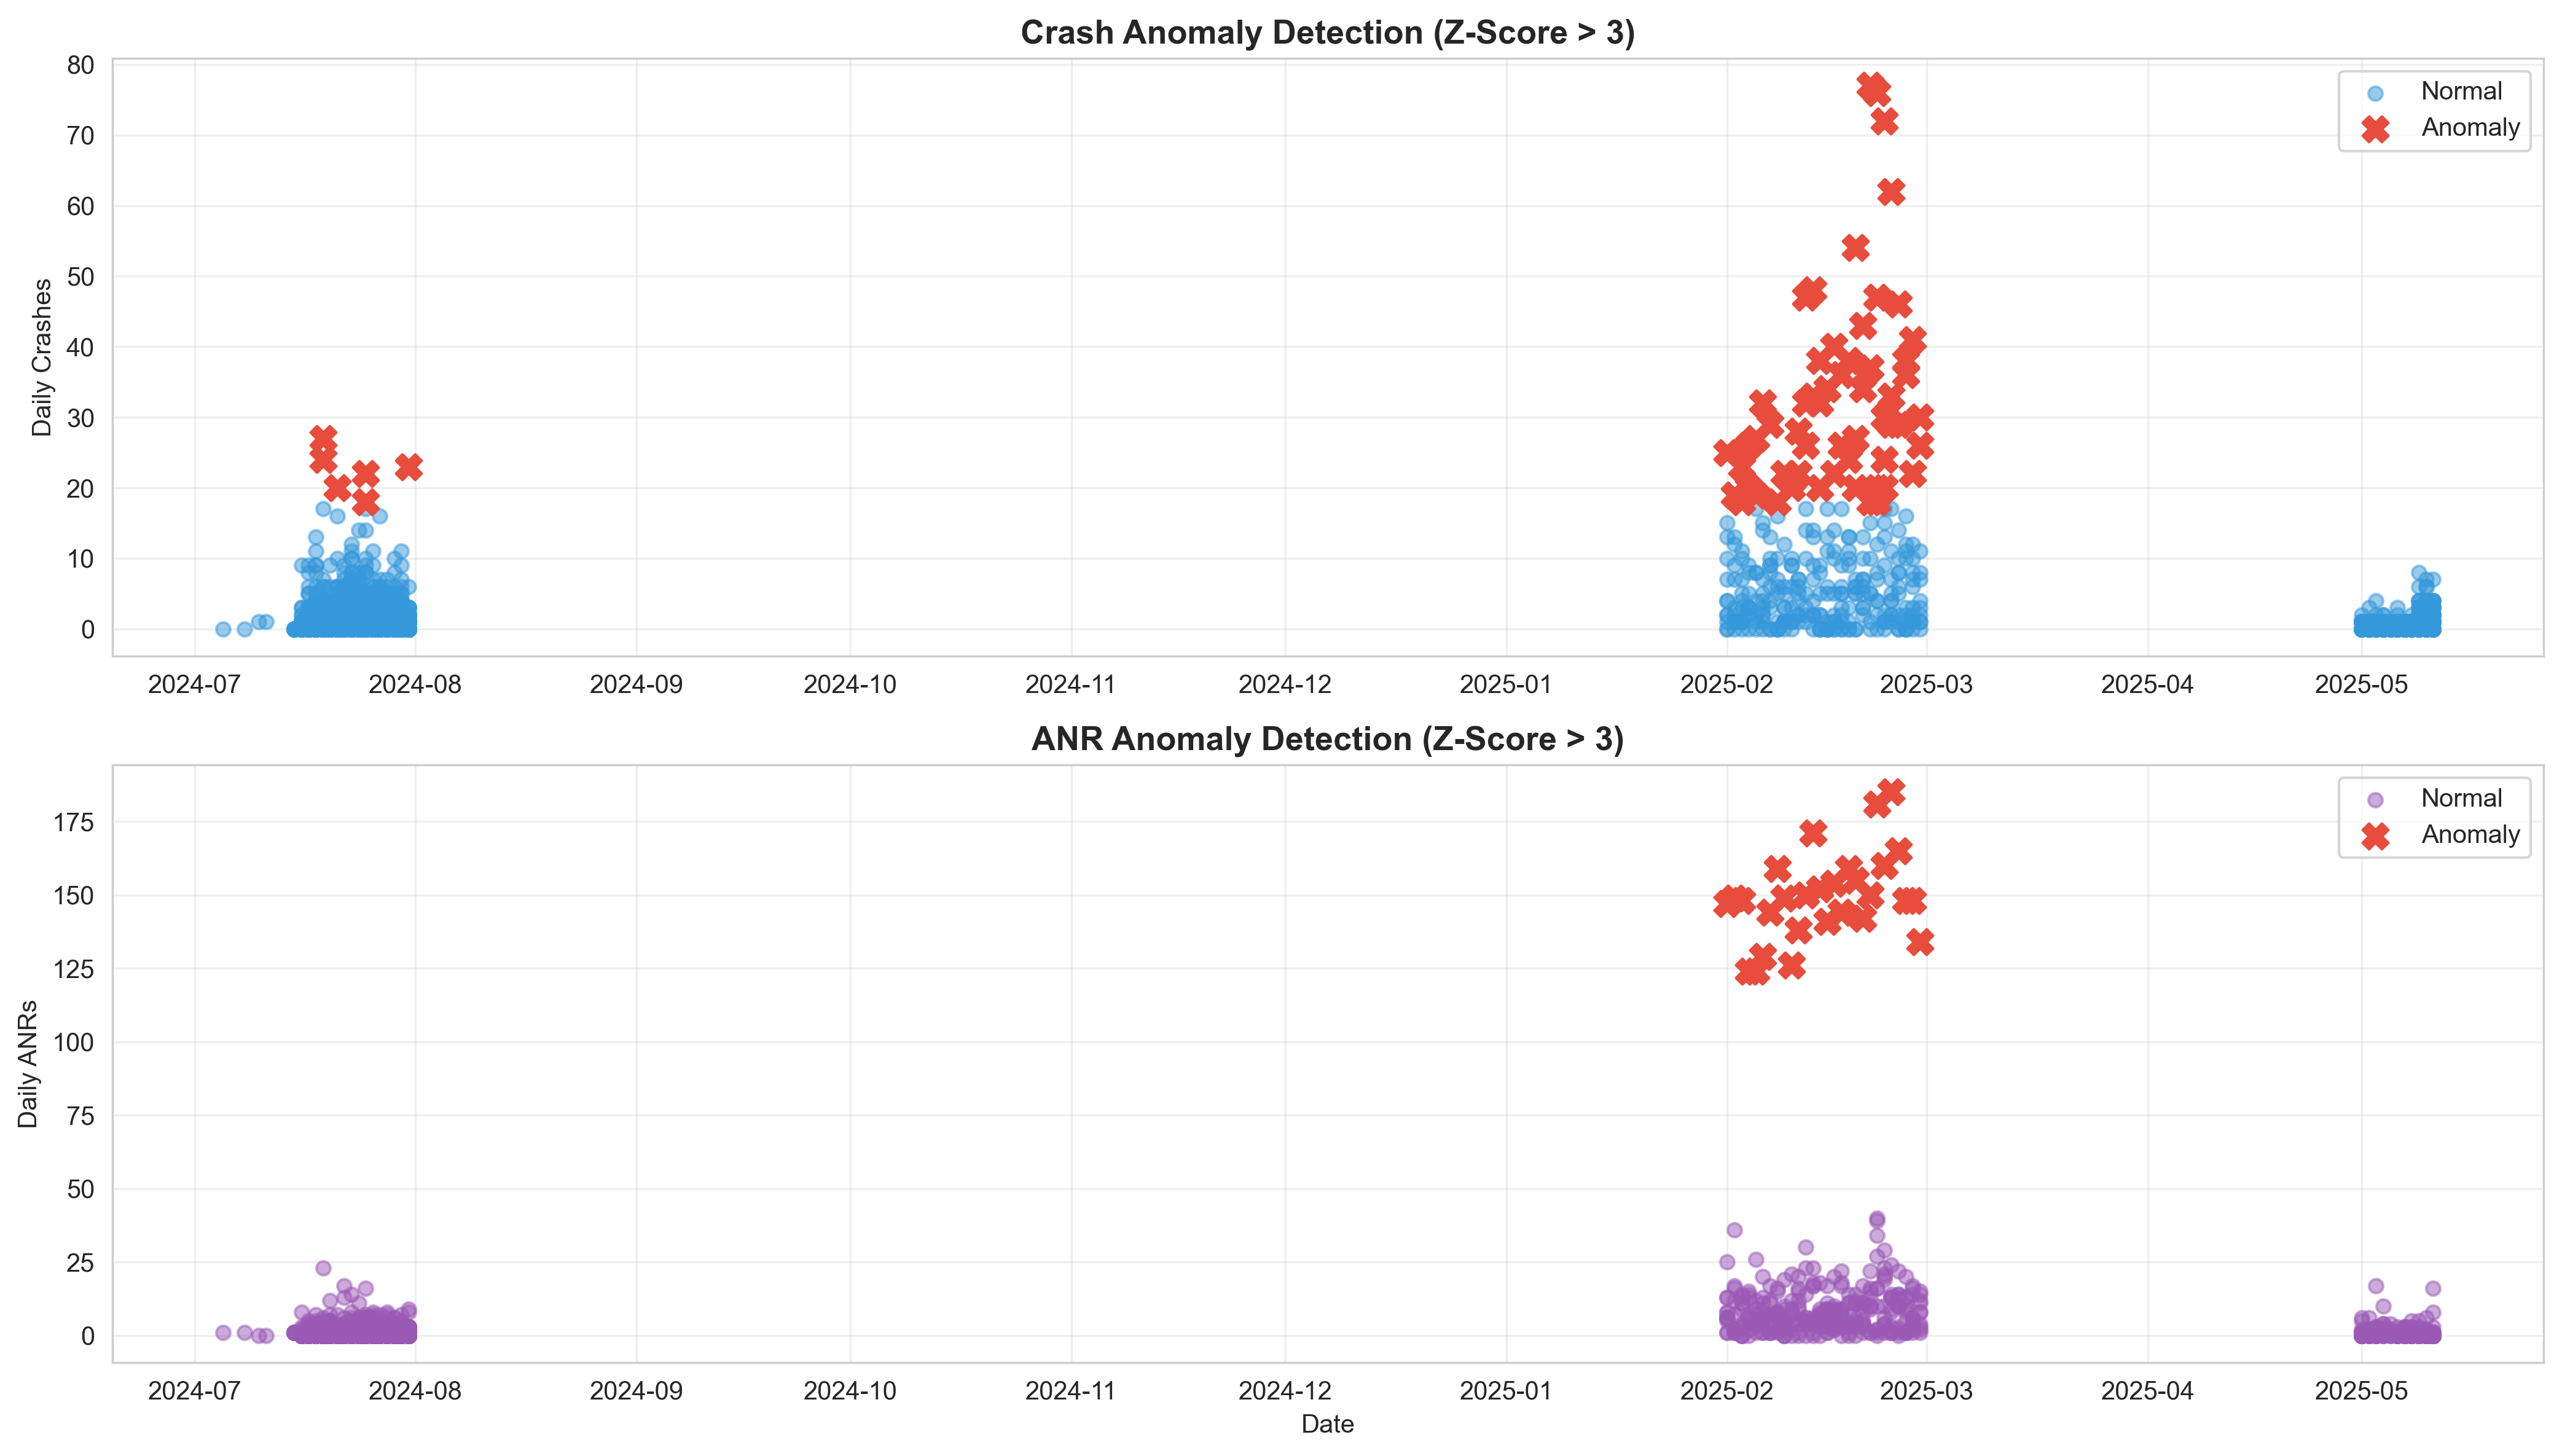

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\Combined_App_Performance.csv")

# Data preprocessing
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Daily Crashes'] = pd.to_numeric(df['Daily Crashes'], errors='coerce')
df['Daily ANRs'] = pd.to_numeric(df['Daily ANRs'], errors='coerce')
df = df.dropna(subset=['Date', 'Daily Crashes', 'Daily ANRs'])

print("="*70)
print("B. ANOMALY DETECTION & STATISTICAL ANALYSIS")
print("="*70)

# 1. GROUP COMPARISON: Crash and ANR rates by Device Type and OS Version
print("\n1. GROUP COMPARISON ANALYSIS")
print("-" * 70)

device_col = 'Device Type' if 'Device Type' in df.columns else 'Device Model'

if device_col in df.columns:
    # By Device Type
    device_comparison = df.groupby(device_col).agg({
        'Daily Crashes': ['sum', 'mean', 'std'],
        'Daily ANRs': ['sum', 'mean', 'std'],
        device_col: 'count'
    }).reset_index()

    device_comparison.columns = [device_col, 'Total_Crashes', 'Avg_Crashes', 'Std_Crashes',
                                  'Total_ANRs', 'Avg_ANRs', 'Std_ANRs', 'Sample_Size']

    device_comparison['Crash_Rate'] = (device_comparison['Total_Crashes'] /
                                        device_comparison['Sample_Size']) * 100
    device_comparison['ANR_Rate'] = (device_comparison['Total_ANRs'] /
                                      device_comparison['Sample_Size']) * 100

    print("\n📊 Device Type Comparison:")
    print(device_comparison[[device_col, 'Sample_Size', 'Avg_Crashes', 'Avg_ANRs',
                             'Crash_Rate', 'ANR_Rate']].to_string(index=False))

# By OS Version
os_comparison = df.groupby('Android OS Version').agg({
    'Daily Crashes': ['sum', 'mean', 'std'],
    'Daily ANRs': ['sum', 'mean', 'std'],
    'Android OS Version': 'count'
}).reset_index()

os_comparison.columns = ['OS_Version', 'Total_Crashes', 'Avg_Crashes', 'Std_Crashes',
                         'Total_ANRs', 'Avg_ANRs', 'Std_ANRs', 'Sample_Size']

os_comparison['Crash_Rate'] = (os_comparison['Total_Crashes'] /
                                os_comparison['Sample_Size']) * 100
os_comparison['ANR_Rate'] = (os_comparison['Total_ANRs'] /
                              os_comparison['Sample_Size']) * 100

print("\n📊 OS Version Comparison:")
print(os_comparison[['OS_Version', 'Sample_Size', 'Avg_Crashes', 'Avg_ANRs',
                     'Crash_Rate', 'ANR_Rate']].to_string(index=False))

# Visualization - Group Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Device Type - Crashes
if device_col in df.columns:
    axes[0, 0].bar(device_comparison[device_col], device_comparison['Avg_Crashes'],
                   color='#e74c3c', alpha=0.7)
    axes[0, 0].set_title('Average Crashes by Device Type', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Avg Crashes')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # Device Type - ANRs
    axes[0, 1].bar(device_comparison[device_col], device_comparison['Avg_ANRs'],
                   color='#f39c12', alpha=0.7)
    axes[0, 1].set_title('Average ANRs by Device Type', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Avg ANRs')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')

# OS Version - Crashes
axes[1, 0].bar(os_comparison['OS_Version'], os_comparison['Avg_Crashes'],
               color='#3498db', alpha=0.7)
axes[1, 0].set_title('Average Crashes by OS Version', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Avg Crashes')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# OS Version - ANRs
axes[1, 1].bar(os_comparison['OS_Version'], os_comparison['Avg_ANRs'],
               color='#9b59b6', alpha=0.7)
axes[1, 1].set_title('Average ANRs by OS Version', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Avg ANRs')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('group_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Chart saved: group_comparison.png")

# 2. CHI-SQUARE TEST: Association between Crash occurrence and Device Type
print("\n\n2. CHI-SQUARE TEST (ASSOCIATION ANALYSIS)")
print("-" * 70)

# Create binary crash indicator
df['Has_Crash'] = (df['Daily Crashes'] > 0).astype(int)

if device_col in df.columns:
    # Contingency table
    contingency_table = pd.crosstab(df[device_col], df['Has_Crash'],
                                     margins=True, margins_name='Total')

    print("\n📋 Contingency Table: Crash Occurrence vs Device Type")
    print(contingency_table)

    # Chi-square test
    contingency_for_test = pd.crosstab(df[device_col], df['Has_Crash'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_for_test)

    print("\n🔬 Chi-Square Test Results:")
    print(f"   Chi-Square Statistic: {chi2:.4f}")
    print(f"   P-value: {p_value:.6f}")
    print(f"   Degrees of Freedom: {dof}")

    alpha = 0.05
    if p_value < alpha:
        print(f"\n✓ Result: SIGNIFICANT association detected (p < {alpha})")
        print(f"   There IS a statistically significant relationship between")
        print(f"   Device Type and Crash occurrence.")
    else:
        print(f"\n✗ Result: NO significant association (p >= {alpha})")
        print(f"   Device Type and Crash occurrence are independent.")

    # Effect size (Cramér's V)
    n = contingency_for_test.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_for_test.shape) - 1)))
    print(f"   Cramér's V (effect size): {cramers_v:.4f}")

    if cramers_v < 0.1:
        effect = "negligible"
    elif cramers_v < 0.3:
        effect = "small"
    elif cramers_v < 0.5:
        effect = "medium"
    else:
        effect = "large"
    print(f"   Effect size interpretation: {effect}")

# 3. LOGISTIC REGRESSION: Predict crash probability
print("\n\n3. LOGISTIC REGRESSION ANALYSIS")
print("-" * 70)

# Prepare features
df['Hour'] = df['Date'].dt.hour
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

# Encode categorical variables
le_device = LabelEncoder()
le_os = LabelEncoder()

if device_col in df.columns:
    df['Device_Encoded'] = le_device.fit_transform(df[device_col].astype(str))
df['OS_Encoded'] = le_os.fit_transform(df['Android OS Version'].astype(str))

# Select features
feature_cols = ['OS_Encoded', 'Hour', 'Month', 'DayOfWeek']
if device_col in df.columns:
    feature_cols.insert(0, 'Device_Encoded')

# Handle missing values
df_model = df[feature_cols + ['Has_Crash']].dropna()

X = df_model[feature_cols]
y = df_model['Has_Crash']

# Train logistic regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X, y)

# Results
print("\n📈 Logistic Regression Model Performance:")
print(f"   Model Accuracy: {log_reg.score(X, y):.4f}")
print(f"   Baseline (all no-crash): {1 - y.mean():.4f}")

# Coefficients and odds ratios
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': log_reg.coef_[0],
    'Odds_Ratio': np.exp(log_reg.coef_[0])
})
coef_df = coef_df.sort_values('Coefficient', ascending=False)

print("\n📊 Feature Coefficients & Odds Ratios:")
print(coef_df.to_string(index=False))

print("\n🔍 Interpretation:")
for idx, row in coef_df.iterrows():
    if row['Coefficient'] > 0.1:
        pct_increase = (row['Odds_Ratio'] - 1) * 100
        print(f"   • {row['Feature']}: INCREASES crash odds by {pct_increase:.1f}%")
    elif row['Coefficient'] < -0.1:
        pct_decrease = (1 - row['Odds_Ratio']) * 100
        print(f"   • {row['Feature']}: DECREASES crash odds by {pct_decrease:.1f}%")

# Visualization - Odds Ratios
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if x > 1 else '#27ae60' for x in coef_df['Odds_Ratio']]
bars = ax.barh(coef_df['Feature'], coef_df['Odds_Ratio'], color=colors, alpha=0.7)
ax.axvline(x=1, color='black', linestyle='--', linewidth=2, label='No Effect')
ax.set_xlabel('Odds Ratio', fontsize=12, fontweight='bold')
ax.set_title('Logistic Regression: Feature Impact on Crash Probability',
             fontsize=13, fontweight='bold')
ax.set_xlim(0.5, max(coef_df['Odds_Ratio'].max() * 1.1, 1.5))
ax.grid(True, alpha=0.3, axis='x')
ax.legend()

plt.tight_layout()
plt.savefig('logistic_regression_odds.png', dpi=300, bbox_inches='tight')
print("\n✓ Chart saved: logistic_regression_odds.png")

# 4. ANOMALY DETECTION (Z-Score Method)
print("\n\n4. ANOMALY DETECTION")
print("-" * 70)

# Calculate z-scores for crashes
df['Crash_ZScore'] = np.abs(stats.zscore(df['Daily Crashes']))
df['ANR_ZScore'] = np.abs(stats.zscore(df['Daily ANRs']))

# Identify anomalies (z-score > 3)
crash_anomalies = df[df['Crash_ZScore'] > 3].sort_values('Daily Crashes', ascending=False)
anr_anomalies = df[df['ANR_ZScore'] > 3].sort_values('Daily ANRs', ascending=False)

print(f"\n⚠ Crash Anomalies Detected: {len(crash_anomalies)}")
if len(crash_anomalies) > 0:
    print("\nTop 5 Crash Anomalies:")
    cols_to_show = ['Date', 'Daily Crashes', device_col if device_col in df.columns else 'Android OS Version',
                    'Android OS Version', 'Crash_ZScore']
    cols_to_show = [c for c in cols_to_show if c in crash_anomalies.columns]
    print(crash_anomalies[cols_to_show].head(5).to_string(index=False))

print(f"\n⚠ ANR Anomalies Detected: {len(anr_anomalies)}")
if len(anr_anomalies) > 0:
    print("\nTop 5 ANR Anomalies:")
    cols_to_show = ['Date', 'Daily ANRs', device_col if device_col in df.columns else 'Android OS Version',
                    'Android OS Version', 'ANR_ZScore']
    cols_to_show = [c for c in cols_to_show if c in anr_anomalies.columns]
    print(anr_anomalies[cols_to_show].head(5).to_string(index=False))

# Visualization - Anomalies
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Crash anomalies
axes[0].scatter(df['Date'], df['Daily Crashes'], alpha=0.5, s=30, c='#3498db', label='Normal')
if len(crash_anomalies) > 0:
    axes[0].scatter(crash_anomalies['Date'], crash_anomalies['Daily Crashes'],
                    color='#e74c3c', s=100, marker='X', label='Anomaly', zorder=5)
axes[0].set_title('Crash Anomaly Detection (Z-Score > 3)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Daily Crashes')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ANR anomalies
axes[1].scatter(df['Date'], df['Daily ANRs'], alpha=0.5, s=30, c='#9b59b6', label='Normal')
if len(anr_anomalies) > 0:
    axes[1].scatter(anr_anomalies['Date'], anr_anomalies['Daily ANRs'],
                    color='#e74c3c', s=100, marker='X', label='Anomaly', zorder=5)
axes[1].set_title('ANR Anomaly Detection (Z-Score > 3)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Daily ANRs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anomaly_detection.png', dpi=300, bbox_inches='tight')
print("\n✓ Chart saved: anomaly_detection.png")

print("\n" + "="*70)
print("ANOMALY DETECTION & STATISTICAL ANALYSIS COMPLETE")
print("="*70)

**NDPR Compliance:DPIA and Breach Evidence Analysis**


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

print("="*80)
print("NDPR/PRIVACY COMPLIANCE ANALYSIS - BATCH 3")
print("DPIA (DATA PROTECTION IMPACT ASSESSMENT) & BREACH EVIDENCE")
print("="*80)

# Load the data
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\Combined_App_Performance.csv")
df.columns = df.columns.str.strip()

# Find columns
date_col = [col for col in df.columns if 'date' in col.lower()][0]
device_col = [col for col in df.columns if 'device' in col.lower()][0] if any('device' in col.lower() for col in df.columns) else None

# Keep only required columns
columns_to_keep = ['Daily ANRs', 'Android OS Version', 'Daily Crashes', date_col]
if device_col:
    columns_to_keep.append(device_col)

df = df[columns_to_keep].copy()

# Clean data
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.rename(columns={date_col: 'Date'})
df['Daily Crashes'] = pd.to_numeric(df['Daily Crashes'], errors='coerce')
df['Daily ANRs'] = pd.to_numeric(df['Daily ANRs'], errors='coerce')
df = df.dropna(subset=['Date', 'Daily Crashes', 'Daily ANRs'])

if device_col:
    df = df.rename(columns={device_col: 'Device'})

print(f"\nDataset loaded: {len(df):,} records")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# ===========================================================================
# 1. DATA PROTECTION IMPACT ASSESSMENT (DPIA)
# ===========================================================================

print("\n" + "="*80)
print("1. DATA PROTECTION IMPACT ASSESSMENT (DPIA)")
print("="*80)

print(f"\n📋 DPIA FRAMEWORK - NDPR Article 25 Compliance")
print(f"\n   A DPIA is REQUIRED when processing:")
print(f"   • Involves systematic monitoring")
print(f"   • Processes personal data at large scale")
print(f"   • Uses automated decision-making")
print(f"   • Processes sensitive or criminal data")

# Risk assessment based on data characteristics
risk_score = 0
risk_factors = []

print(f"\n🔍 RISK ASSESSMENT:")

# Factor 1: Volume of data
total_records = len(df)
if total_records > 10000:
    risk_score += 3
    risk_factors.append("High volume of records (>10,000)")
    print(f"   ⚠️  HIGH VOLUME: {total_records:,} records (Risk +3)")
elif total_records > 1000:
    risk_score += 2
    risk_factors.append("Medium volume of records (>1,000)")
    print(f"   ⚠️  MEDIUM VOLUME: {total_records:,} records (Risk +2)")
else:
    risk_score += 1
    print(f"   ✓ LOW VOLUME: {total_records:,} records (Risk +1)")

# Factor 2: Data retention period
data_age_max = (datetime.now() - df['Date'].min()).days
if data_age_max > 365:
    risk_score += 3
    risk_factors.append(f"Extended retention period ({data_age_max} days)")
    print(f"   ⚠️  EXTENDED RETENTION: {data_age_max} days (Risk +3)")
elif data_age_max > 180:
    risk_score += 2
    print(f"   ⚠️  MODERATE RETENTION: {data_age_max} days (Risk +2)")
else:
    risk_score += 1
    print(f"   ✓ COMPLIANT RETENTION: {data_age_max} days (Risk +1)")

# Factor 3: Device identification
if 'Device' in df.columns:
    unique_devices = df['Device'].nunique()
    if unique_devices > 1000:
        risk_score += 2
        risk_factors.append(f"Large user base ({unique_devices} devices)")
        print(f"   ⚠️  LARGE USER BASE: {unique_devices:,} devices (Risk +2)")
    else:
        risk_score += 1
        print(f"   ✓ MODERATE USER BASE: {unique_devices:,} devices (Risk +1)")

# Factor 4: OS version diversity
unique_os = df['Android OS Version'].nunique()
if unique_os > 10:
    risk_score += 1
    print(f"   ⚠️  HIGH OS FRAGMENTATION: {unique_os} versions (Risk +1)")
else:
    print(f"   ✓ LOW OS FRAGMENTATION: {unique_os} versions")

# Factor 5: Presence of crash data
total_crashes = df['Daily Crashes'].sum()
total_anrs = df['Daily ANRs'].sum()
if total_crashes > 0 or total_anrs > 0:
    risk_score += 1
    risk_factors.append(f"Contains performance incidents ({total_crashes} crashes, {total_anrs} ANRs)")
    print(f"   ⚠️  INCIDENT DATA: {total_crashes:,} crashes, {total_anrs:,} ANRs (Risk +1)")

# Calculate overall risk level
max_possible_risk = 11  # Maximum points from all factors
risk_percentage = (risk_score / max_possible_risk) * 100

print(f"\n📊 OVERALL DPIA RISK ASSESSMENT:")
print(f"   Total Risk Score: {risk_score}/{max_possible_risk} ({risk_percentage:.1f}%)")

if risk_percentage >= 70:
    risk_level = "HIGH RISK"
    risk_color = "🔴"
elif risk_percentage >= 40:
    risk_level = "MEDIUM RISK"
    risk_color = "🟡"
else:
    risk_level = "LOW RISK"
    risk_color = "🟢"

print(f"   Risk Level: {risk_color} {risk_level}")

if risk_level == "HIGH RISK":
    print(f"\n   🔴 ACTION REQUIRED:")
    print(f"      • Complete formal DPIA documentation")
    print(f"      • Consult with Data Protection Officer (DPO)")
    print(f"      • Implement additional safeguards")
    print(f"      • Consider privacy-by-design improvements")
elif risk_level == "MEDIUM RISK":
    print(f"\n   🟡 RECOMMENDATION:")
    print(f"      • Document risk assessment findings")
    print(f"      • Review data retention policies")
    print(f"      • Enhance security measures")

print(f"\n📋 KEY RISK FACTORS IDENTIFIED:")
for i, factor in enumerate(risk_factors, 1):
    print(f"   {i}. {factor}")

# ===========================================================================
# 2. DPIA COMPLIANCE CHECKLIST
# ===========================================================================

print("\n\n" + "="*80)
print("2. DPIA COMPLIANCE CHECKLIST")
print("="*80)

dpia_checklist = [
    ("Data Processing Necessity", "Is crash/ANR monitoring necessary for app functionality?"),
    ("Legitimate Interest", "Does monitoring serve legitimate business interest?"),
    ("User Consent", "Have users been informed and given consent?"),
    ("Purpose Limitation", "Is data used only for stated purpose?"),
    ("Data Minimization", "Are we collecting only necessary data?"),
    ("Storage Limitation", "Is retention period justified and documented?"),
    ("Security Measures", "Are appropriate technical measures in place?"),
    ("Rights Management", "Can users exercise their data rights (access, deletion)?"),
    ("Processor Agreements", "Are third-party processors under contract?"),
    ("Breach Response", "Is incident response plan documented?")
]

print(f"\n✓ Complete the following DPIA requirements:\n")
for i, (requirement, question) in enumerate(dpia_checklist, 1):
    print(f"   [{' '}] {i}. {requirement}")
    print(f"       Q: {question}")
    print()

# ===========================================================================
# 3. BREACH EVIDENCE ANALYSIS
# ===========================================================================

print("\n" + "="*80)
print("3. BREACH EVIDENCE ANALYSIS")
print("="*80)

print(f"\n🔍 ANALYZING DATA ACCESS PATTERNS FOR SUSPICIOUS ACTIVITY...")

# Analyze daily record patterns
daily_records = df.groupby('Date').size().reset_index(name='Record_Count')
daily_records = daily_records.sort_values('Date')

# Statistical anomaly detection
mean_count = daily_records['Record_Count'].mean()
std_count = daily_records['Record_Count'].std()
daily_records['Z_Score'] = (daily_records['Record_Count'] - mean_count) / std_count
daily_records['Is_Anomaly'] = abs(daily_records['Z_Score']) > 2

anomalies = daily_records[daily_records['Is_Anomaly']]
anomaly_count = len(anomalies)

print(f"\n📊 ACCESS PATTERN ANALYSIS:")
print(f"   Mean daily records: {mean_count:.2f}")
print(f"   Standard deviation: {std_count:.2f}")
print(f"   Detection threshold: ±2 standard deviations")
print(f"   Total days analyzed: {len(daily_records)}")
print(f"   Anomalies detected: {anomaly_count}")

if anomaly_count > 0:
    print(f"\n⚠️  SUSPICIOUS ACTIVITY DETECTED!")
    print(f"\n   Days with unusual access patterns:")
    for idx, row in anomalies.iterrows():
        date_str = row['Date'].strftime('%Y-%m-%d')
        deviation = "HIGH" if row['Z_Score'] > 2 else "LOW"
        print(f"   • {date_str}: {row['Record_Count']} records (Z-score: {row['Z_Score']:.2f}, {deviation})")

    print(f"\n   🔴 INVESTIGATION ACTIONS REQUIRED:")
    print(f"      1. Review server access logs for these dates")
    print(f"      2. Check for unauthorized data exports")
    print(f"      3. Verify user authentication logs")
    print(f"      4. Confirm business justification for spikes")
    print(f"      5. Document findings in security incident log")
else:
    print(f"\n   ✅ NO ANOMALOUS ACCESS PATTERNS DETECTED")
    print(f"      Data access patterns appear normal and consistent")

# Analyze crash/ANR spikes
print(f"\n\n📊 INCIDENT SPIKE ANALYSIS:")

daily_crashes = df.groupby('Date')['Daily Crashes'].sum()
daily_anrs = df.groupby('Date')['Daily ANRs'].sum()

crash_mean = daily_crashes.mean()
crash_std = daily_crashes.std()
anr_mean = daily_anrs.mean()
anr_std = daily_anrs.std()

crash_spikes = daily_crashes[daily_crashes > (crash_mean + 2 * crash_std)]
anr_spikes = daily_anrs[daily_anrs > (anr_mean + 2 * anr_std)]

print(f"   Crash spikes detected: {len(crash_spikes)}")
print(f"   ANR spikes detected: {len(anr_spikes)}")

if len(crash_spikes) > 0:
    print(f"\n   ⚠️  CRASH SPIKES ON:")
    for date, value in crash_spikes.items():
        print(f"      • {date.strftime('%Y-%m-%d')}: {value:.0f} crashes ({((value/crash_mean)-1)*100:.1f}% above normal)")

if len(anr_spikes) > 0:
    print(f"\n   ⚠️  ANR SPIKES ON:")
    for date, value in anr_spikes.items():
        print(f"      • {date.strftime('%Y-%m-%d')}: {value:.0f} ANRs ({((value/anr_mean)-1)*100:.1f}% above normal)")

# ===========================================================================
# 4. BREACH NOTIFICATION REQUIREMENTS
# ===========================================================================

print("\n\n" + "="*80)
print("4. BREACH NOTIFICATION REQUIREMENTS (NDPR Article 33)")
print("="*80)

print(f"\n⚠️  IF A DATA BREACH IS CONFIRMED:")
print(f"\n   Timeline Requirements:")
print(f"   • Notify NITDA within 72 hours of awareness")
print(f"   • Document breach details and response actions")
print(f"   • Notify affected users if high risk to their rights")
print(f"\n   Breach Documentation Must Include:")
print(f"   1. Nature of the breach (unauthorized access, exfiltration, etc.)")
print(f"   2. Categories and approximate number of data subjects affected")
print(f"   3. Categories and approximate number of records affected")
print(f"   4. Likely consequences of the breach")
print(f"   5. Measures taken to address the breach")
print(f"   6. Measures to mitigate possible adverse effects")
print(f"\n   Contact Information:")
print(f"   • NITDA: info@nitda.gov.ng")
print(f"   • Website: https://nitda.gov.ng")

# ===========================================================================
# 5. INCIDENT RESPONSE CHECKLIST
# ===========================================================================

print("\n\n" + "="*80)
print("5. SECURITY INCIDENT RESPONSE CHECKLIST")
print("="*80)

incident_checklist = [
    "Isolate affected systems immediately",
    "Preserve evidence (logs, access records, timestamps)",
    "Notify Data Protection Officer (DPO)",
    "Assemble incident response team",
    "Conduct forensic analysis of breach scope",
    "Identify compromised data and affected users",
    "Assess risk to individuals' rights and freedoms",
    "Document all actions taken with timestamps",
    "Prepare breach notification for NITDA",
    "Notify affected users if required",
    "Implement remediation measures",
    "Conduct post-incident review",
    "Update security policies and procedures"
]

print(f"\n📋 IMMEDIATE ACTIONS IF BREACH SUSPECTED:\n")
for i, action in enumerate(incident_checklist, 1):
    print(f"   [{' '}] {i}. {action}")

# ===========================================================================
# 6. AUDIT TRAIL REQUIREMENTS
# ===========================================================================

print("\n\n" + "="*80)
print("6. AUDIT TRAIL & LOGGING REQUIREMENTS")
print("="*80)

print(f"\n📝 REQUIRED AUDIT LOGS (must be maintained):")
print(f"\n   Access Logs:")
print(f"   • User ID accessing the data")
print(f"   • Timestamp of access")
print(f"   • IP address of accessing device")
print(f"   • Type of operation (read, write, delete, export)")
print(f"   • Records accessed or modified")
print(f"\n   Security Event Logs:")
print(f"   • Failed authentication attempts")
print(f"   • Privilege escalation events")
print(f"   • Configuration changes")
print(f"   • Data export activities")
print(f"   • Unusual query patterns")
print(f"\n   Retention:")
print(f"   • Audit logs must be retained for minimum 1 year")
print(f"   • Logs must be tamper-proof and encrypted")
print(f"   • Regular review by security team required")

# Generate summary report
print("\n\n" + "="*80)
print("BATCH 3 SUMMARY REPORT")
print("="*80)

print(f"\n📊 DPIA RISK ASSESSMENT:")
print(f"   Overall Risk Level: {risk_level} ({risk_percentage:.1f}%)")
print(f"   Risk Factors: {len(risk_factors)}")

print(f"\n🔍 BREACH EVIDENCE:")
print(f"   Anomalous Days: {anomaly_count}")
print(f"   Crash Spikes: {len(crash_spikes)}")
print(f"   ANR Spikes: {len(anr_spikes)}")

if anomaly_count > 0 or len(crash_spikes) > 0 or len(anr_spikes) > 0:
    print(f"\n   ⚠️  STATUS: INVESTIGATION REQUIRED")
else:
    print(f"\n   ✅ STATUS: NO IMMEDIATE CONCERNS")

print(f"\n📋 COMPLIANCE STATUS:")
print(f"   DPIA Required: {'YES' if risk_level in ['HIGH RISK', 'MEDIUM RISK'] else 'RECOMMENDED'}")
print(f"   NITDA Registration: VERIFY MANUALLY")
print(f"   Data Protection Officer: VERIFY APPOINTED")

print("\n" + "="*80)
print("BATCH 3 COMPLETE - DPIA & BREACH EVIDENCE ANALYSIS")
print("="*80)

NDPR/PRIVACY COMPLIANCE ANALYSIS - BATCH 3
DPIA (DATA PROTECTION IMPACT ASSESSMENT) & BREACH EVIDENCE

Dataset loaded: 3,391 records
Date range: 2024-07-05 00:00:00 to 2025-05-11 00:00:00

1. DATA PROTECTION IMPACT ASSESSMENT (DPIA)

📋 DPIA FRAMEWORK - NDPR Article 25 Compliance

   A DPIA is REQUIRED when processing:
   • Involves systematic monitoring
   • Processes personal data at large scale
   • Uses automated decision-making
   • Processes sensitive or criminal data

🔍 RISK ASSESSMENT:
   ⚠️  MEDIUM VOLUME: 3,391 records (Risk +2)
   ⚠️  EXTENDED RETENTION: 470 days (Risk +3)
   ✓ MODERATE USER BASE: 782 devices (Risk +1)
   ⚠️  HIGH OS FRAGMENTATION: 13 versions (Risk +1)
   ⚠️  INCIDENT DATA: 6,929.0 crashes, 9,142.0 ANRs (Risk +1)

📊 OVERALL DPIA RISK ASSESSMENT:
   Total Risk Score: 8/11 (72.7%)
   Risk Level: 🔴 HIGH RISK

   🔴 ACTION REQUIRED:
      • Complete formal DPIA documentation
      • Consult with Data Protection Officer (DPO)
      • Implement additional safeguard

**PLOT CHARTS: NDPR Compliance:DPIA and Breach Evidence Analysis**

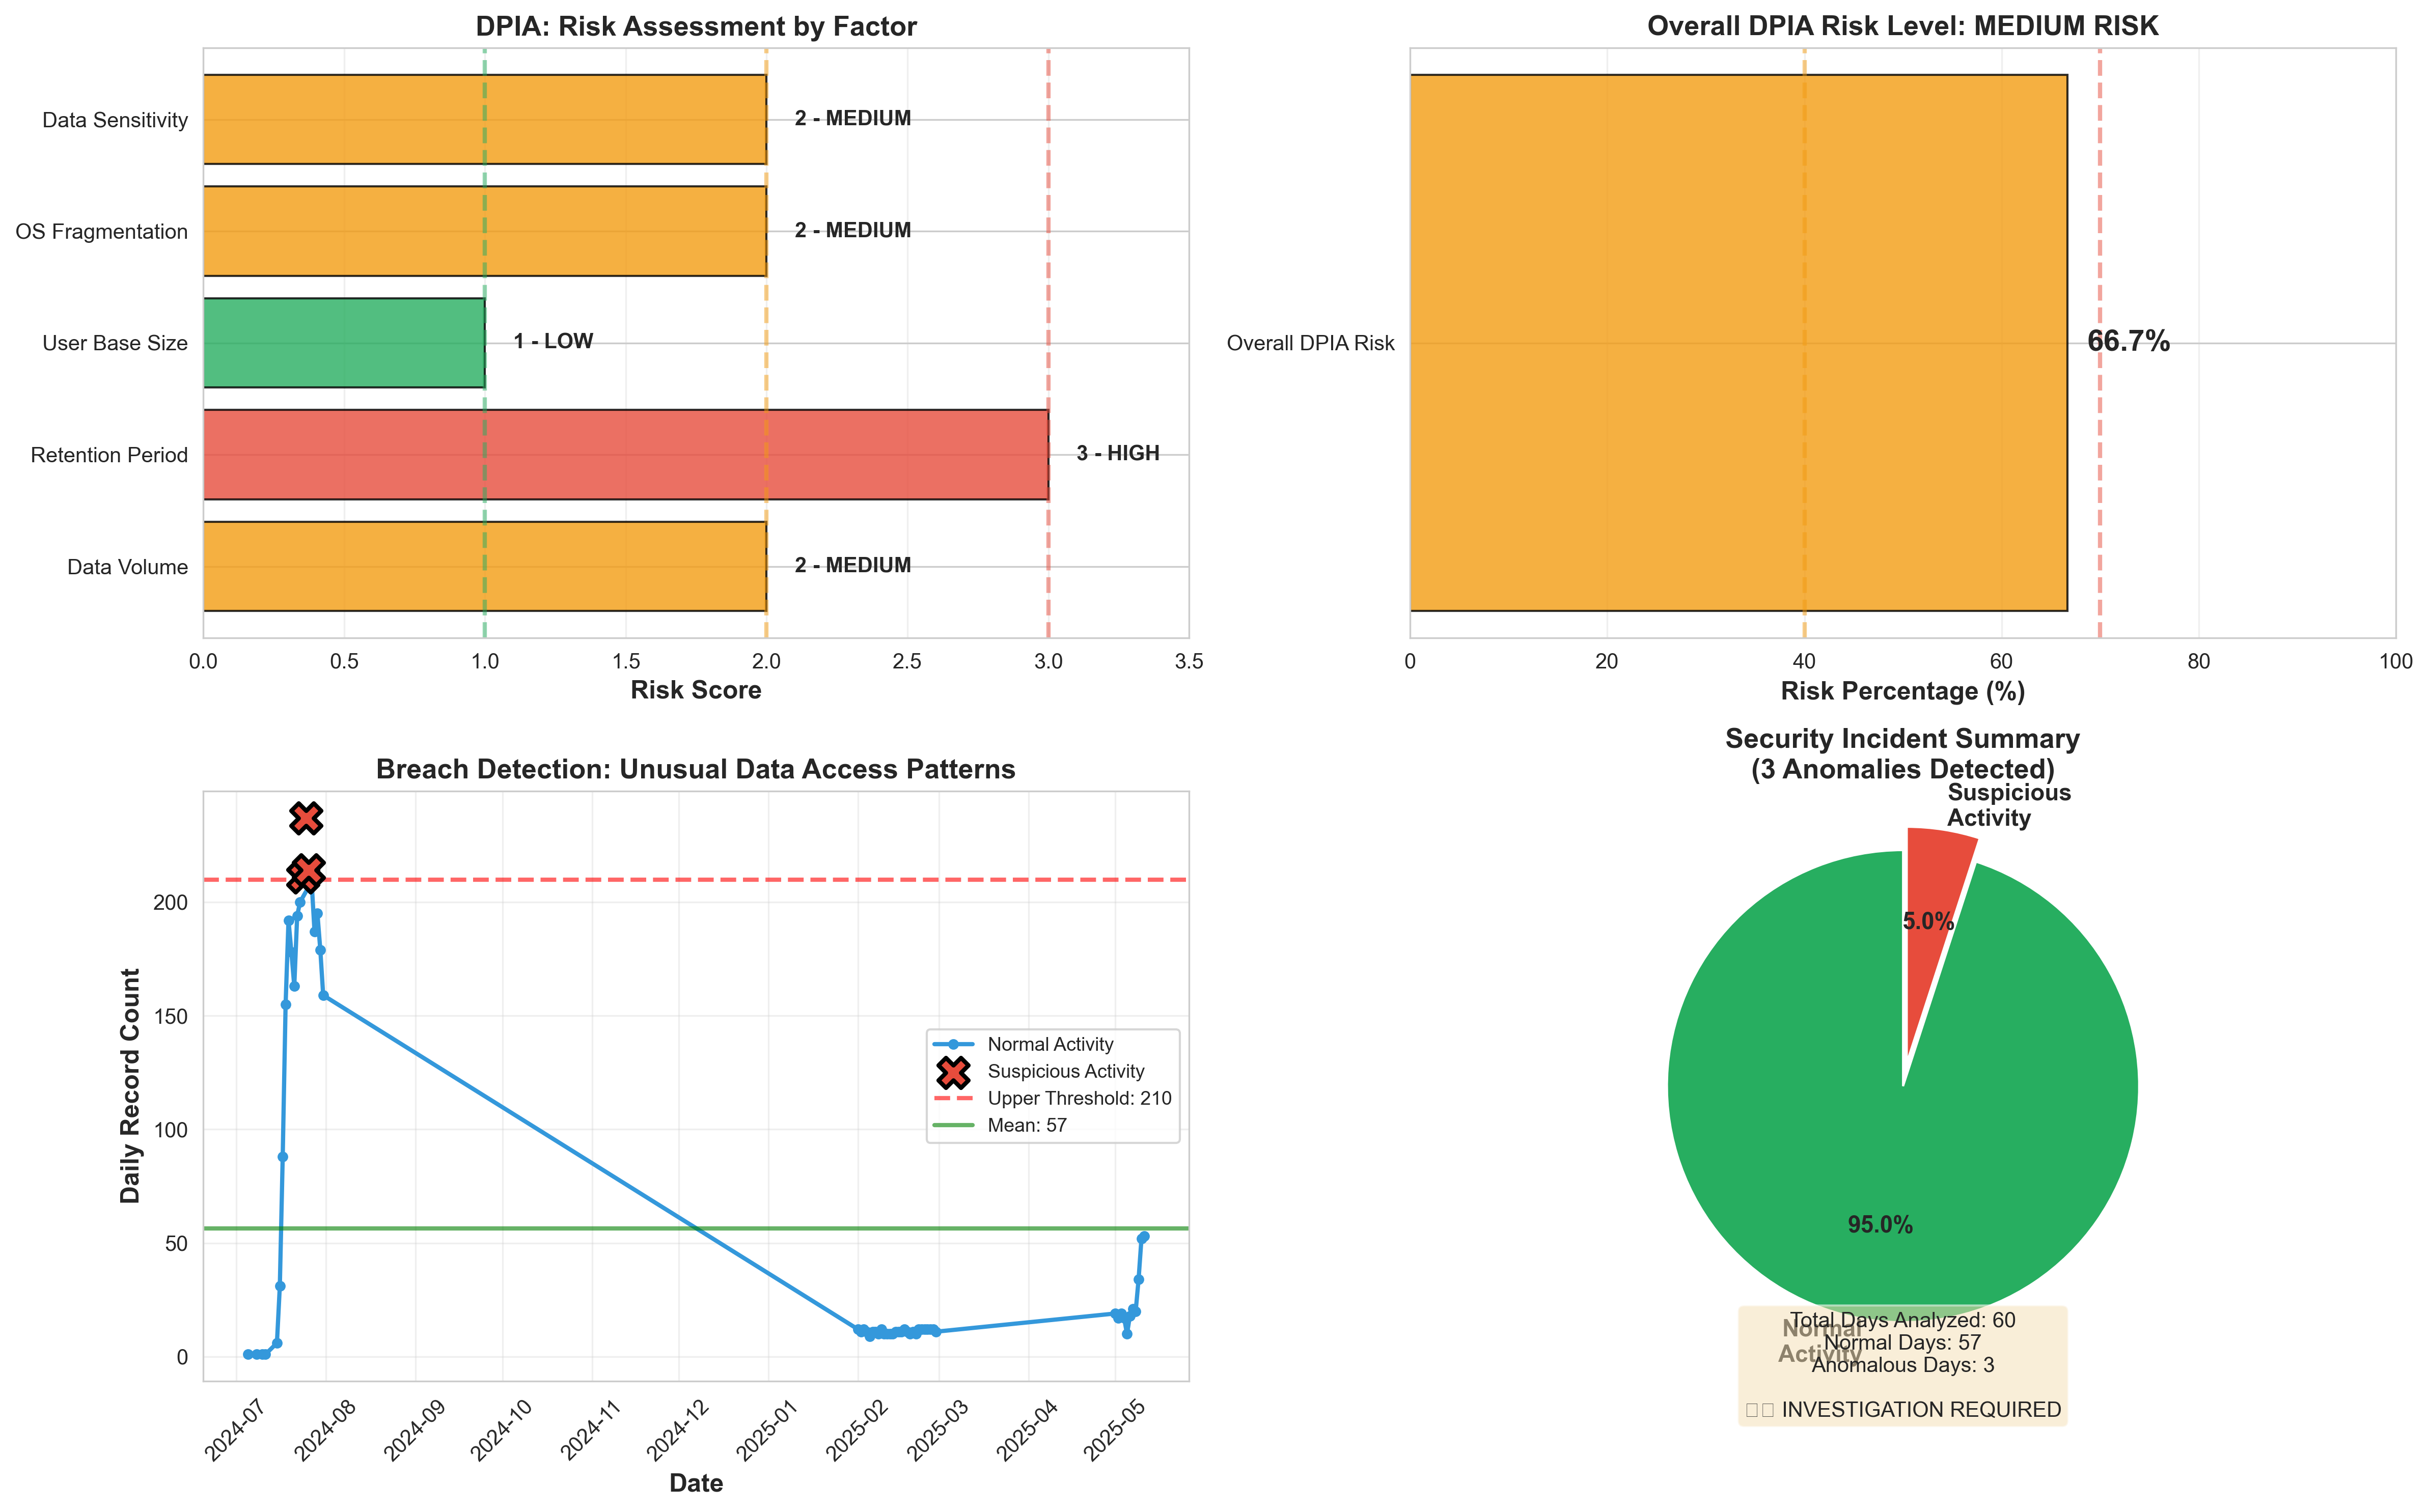

✓ Chart saved: ndpr_batch3_dpia_breach_analysis.png


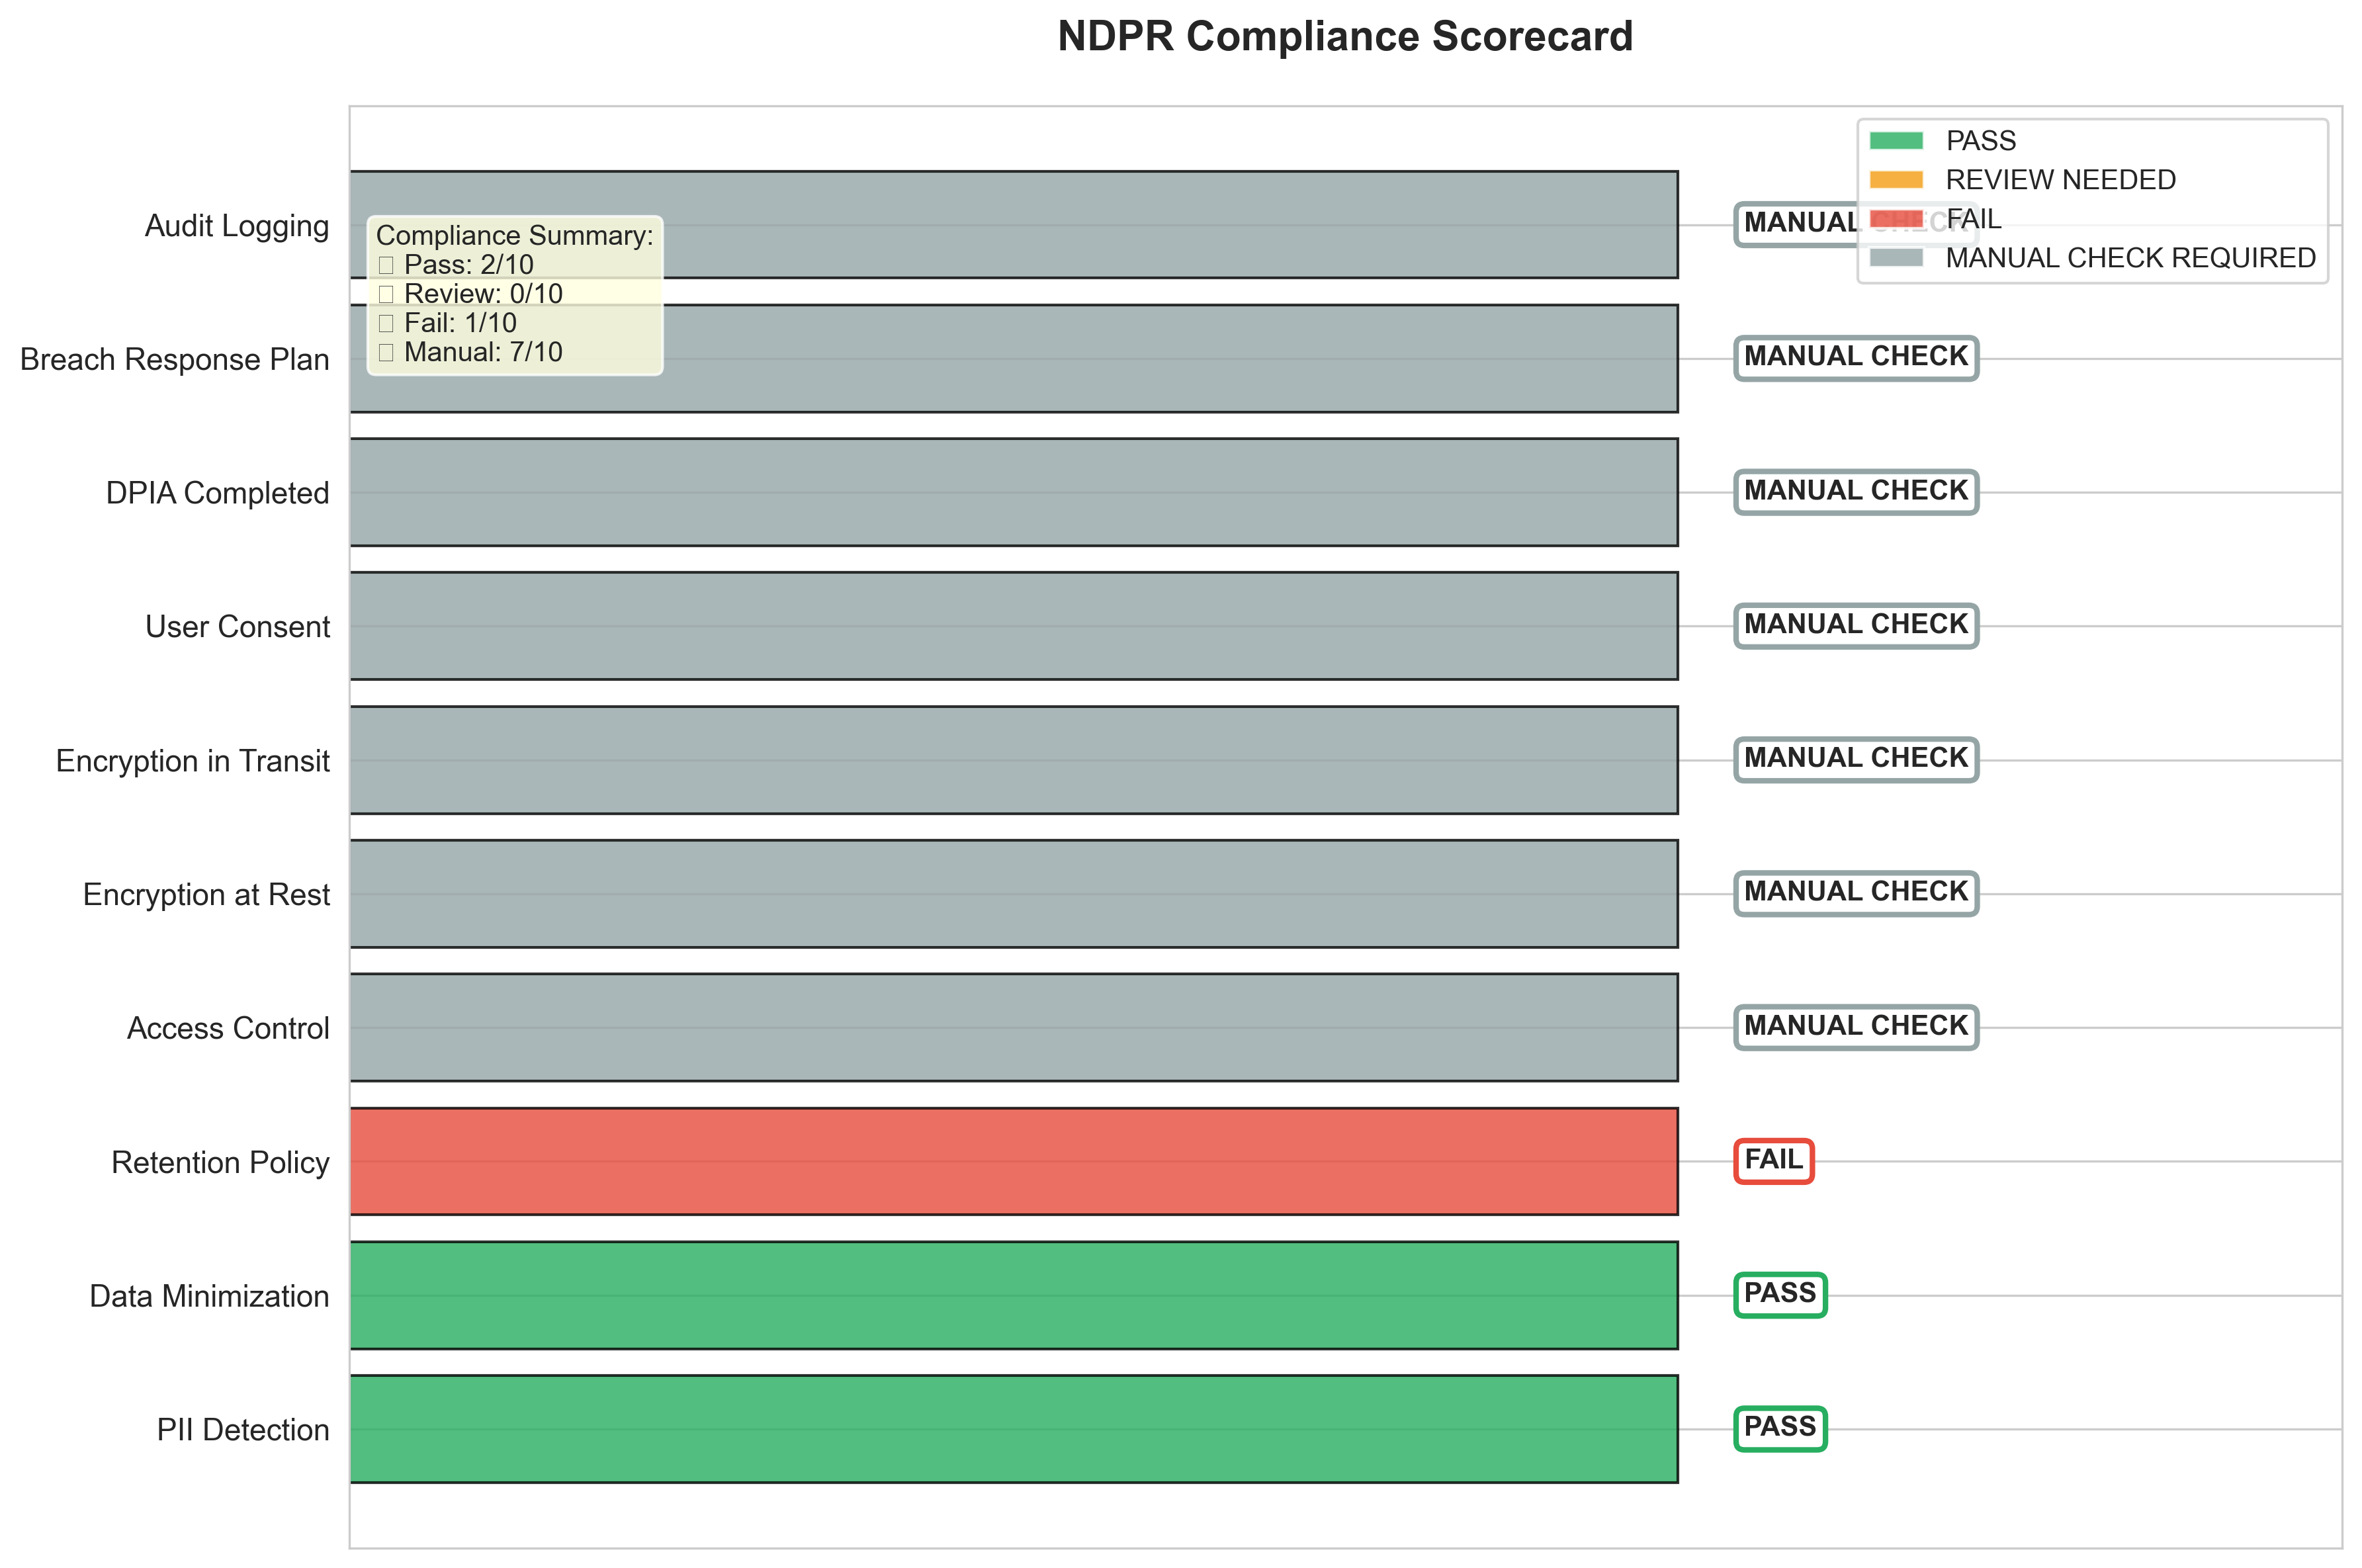

✓ Chart saved: ndpr_batch3_compliance_scorecard.png

NDPR BATCH 3 CHARTS COMPLETE

Generated Charts:
  1. ndpr_batch3_dpia_breach_analysis.png
     - DPIA risk assessment by factor
     - Overall risk gauge
     - Breach detection with anomalies
     - Security incident summary

  2. ndpr_batch3_compliance_scorecard.png
     - Complete NDPR compliance checklist
     - Automated and manual verification status


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Load and prepare data
df = pd.read_csv(r"C:\Users\hp\Desktop\WEEK 3_DSHub\Merged\ANR\Combined_App_Performance.csv")
df.columns = df.columns.str.strip()

# Find columns
date_col = [col for col in df.columns if 'date' in col.lower()][0]
device_col = [col for col in df.columns if 'device' in col.lower()][0] if any('device' in col.lower() for col in df.columns) else None

# Keep required columns
columns_to_keep = ['Daily ANRs', 'Android OS Version', 'Daily Crashes', date_col]
if device_col:
    columns_to_keep.append(device_col)
df = df[columns_to_keep].copy()

# Clean data
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.rename(columns={date_col: 'Date'})
df['Daily Crashes'] = pd.to_numeric(df['Daily Crashes'], errors='coerce')
df['Daily ANRs'] = pd.to_numeric(df['Daily ANRs'], errors='coerce')
df = df.dropna(subset=['Date', 'Daily Crashes', 'Daily ANRs'])
if device_col:
    df = df.rename(columns={device_col: 'Device'})

# ===========================================================================
# CHART 1: DPIA RISK ASSESSMENT VISUALIZATION
# ===========================================================================

# Calculate risk factors
risk_factors = []
risk_scores = []
risk_levels = []

# Volume Risk
total_records = len(df)
if total_records > 10000:
    risk_factors.append('Data Volume')
    risk_scores.append(3)
    risk_levels.append('HIGH')
elif total_records > 1000:
    risk_factors.append('Data Volume')
    risk_scores.append(2)
    risk_levels.append('MEDIUM')
else:
    risk_factors.append('Data Volume')
    risk_scores.append(1)
    risk_levels.append('LOW')

# Retention Risk
data_age = (datetime.now() - df['Date'].min()).days
if data_age > 365:
    risk_factors.append('Retention Period')
    risk_scores.append(3)
    risk_levels.append('HIGH')
elif data_age > 180:
    risk_factors.append('Retention Period')
    risk_scores.append(2)
    risk_levels.append('MEDIUM')
else:
    risk_factors.append('Retention Period')
    risk_scores.append(1)
    risk_levels.append('LOW')

# Device Identification Risk
if 'Device' in df.columns:
    unique_devices = df['Device'].nunique()
    if unique_devices > 1000:
        risk_factors.append('User Base Size')
        risk_scores.append(2)
        risk_levels.append('MEDIUM')
    else:
        risk_factors.append('User Base Size')
        risk_scores.append(1)
        risk_levels.append('LOW')

# OS Version Diversity Risk
unique_os = df['Android OS Version'].nunique()
if unique_os > 10:
    risk_factors.append('OS Fragmentation')
    risk_scores.append(2)
    risk_levels.append('MEDIUM')
else:
    risk_factors.append('OS Fragmentation')
    risk_scores.append(1)
    risk_levels.append('LOW')

# Data Sensitivity Risk (based on crash/ANR presence)
has_crashes = (df['Daily Crashes'] > 0).any()
has_anrs = (df['Daily ANRs'] > 0).any()
if has_crashes and has_anrs:
    risk_factors.append('Data Sensitivity')
    risk_scores.append(2)
    risk_levels.append('MEDIUM')
else:
    risk_factors.append('Data Sensitivity')
    risk_scores.append(1)
    risk_levels.append('LOW')

# Create DPIA Risk Assessment Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Chart 1: Risk Score by Factor
colors = ['#e74c3c' if s == 3 else '#f39c12' if s == 2 else '#27ae60' for s in risk_scores]
bars = axes[0, 0].barh(risk_factors, risk_scores, color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Risk Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('DPIA: Risk Assessment by Factor', fontsize=13, fontweight='bold')
axes[0, 0].set_xlim(0, 3.5)
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Add value labels and risk levels
for i, (score, level) in enumerate(zip(risk_scores, risk_levels)):
    axes[0, 0].text(score + 0.1, i, f'{score} - {level}', va='center',
                    fontsize=10, fontweight='bold')

# Add legend for risk levels
axes[0, 0].axvline(x=1, color='#27ae60', linestyle='--', alpha=0.5, linewidth=2)
axes[0, 0].axvline(x=2, color='#f39c12', linestyle='--', alpha=0.5, linewidth=2)
axes[0, 0].axvline(x=3, color='#e74c3c', linestyle='--', alpha=0.5, linewidth=2)

# Chart 2: Overall Risk Gauge
total_risk = sum(risk_scores)
max_possible_risk = len(risk_factors) * 3
risk_percentage = (total_risk / max_possible_risk) * 100

if risk_percentage >= 70:
    gauge_color = '#e74c3c'
    risk_category = 'HIGH RISK'
elif risk_percentage >= 40:
    gauge_color = '#f39c12'
    risk_category = 'MEDIUM RISK'
else:
    gauge_color = '#27ae60'
    risk_category = 'LOW RISK'

axes[0, 1].barh(['Overall DPIA Risk'], [risk_percentage], color=gauge_color,
                alpha=0.8, edgecolor='black', height=0.5)
axes[0, 1].set_xlabel('Risk Percentage (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title(f'Overall DPIA Risk Level: {risk_category}',
                     fontsize=13, fontweight='bold')
axes[0, 1].set_xlim(0, 100)
axes[0, 1].text(risk_percentage + 2, 0, f'{risk_percentage:.1f}%',
                va='center', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=40, color='#f39c12', linestyle='--', alpha=0.5, linewidth=2)
axes[0, 1].axvline(x=70, color='#e74c3c', linestyle='--', alpha=0.5, linewidth=2)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# ===========================================================================
# CHART 3: BREACH EVIDENCE - UNUSUAL ACTIVITY DETECTION
# ===========================================================================

# Analyze daily record patterns for anomalies
daily_records = df.groupby('Date').size().reset_index(name='Record_Count')
daily_records = daily_records.sort_values('Date')

# Calculate z-scores for anomaly detection
mean_count = daily_records['Record_Count'].mean()
std_count = daily_records['Record_Count'].std()
daily_records['Z_Score'] = (daily_records['Record_Count'] - mean_count) / std_count
daily_records['Is_Anomaly'] = abs(daily_records['Z_Score']) > 2

# Chart 3: Daily Activity Pattern with Anomalies
normal_data = daily_records[~daily_records['Is_Anomaly']]
anomaly_data = daily_records[daily_records['Is_Anomaly']]

axes[1, 0].plot(normal_data['Date'], normal_data['Record_Count'],
                marker='o', linewidth=2, markersize=4, color='#3498db',
                label='Normal Activity')

if len(anomaly_data) > 0:
    axes[1, 0].scatter(anomaly_data['Date'], anomaly_data['Record_Count'],
                       color='#e74c3c', s=200, marker='X',
                       label='Suspicious Activity', zorder=5, edgecolor='black', linewidth=2)

# Add threshold lines
upper_threshold = mean_count + 2 * std_count
lower_threshold = max(0, mean_count - 2 * std_count)
axes[1, 0].axhline(y=upper_threshold, color='red', linestyle='--',
                   linewidth=2, alpha=0.6, label=f'Upper Threshold: {upper_threshold:.0f}')
axes[1, 0].axhline(y=mean_count, color='green', linestyle='-',
                   linewidth=2, alpha=0.6, label=f'Mean: {mean_count:.0f}')

axes[1, 0].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Daily Record Count', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Breach Detection: Unusual Data Access Patterns',
                     fontsize=13, fontweight='bold')
axes[1, 0].legend(loc='best', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Chart 4: Anomaly Summary
anomaly_count = daily_records['Is_Anomaly'].sum()
normal_count = (~daily_records['Is_Anomaly']).sum()

categories = ['Normal\nActivity', 'Suspicious\nActivity']
counts = [normal_count, anomaly_count]
colors_pie = ['#27ae60', '#e74c3c']

wedges, texts, autotexts = axes[1, 1].pie(counts, labels=categories,
                                           colors=colors_pie, autopct='%1.1f%%',
                                           startangle=90, explode=(0, 0.1),
                                           textprops={'fontsize': 11, 'fontweight': 'bold'})

axes[1, 1].set_title(f'Security Incident Summary\n({anomaly_count} Anomalies Detected)',
                     fontsize=13, fontweight='bold')

# Add summary text
summary_text = f'Total Days Analyzed: {len(daily_records)}\n'
summary_text += f'Normal Days: {normal_count}\n'
summary_text += f'Anomalous Days: {anomaly_count}\n'
if anomaly_count > 0:
    summary_text += f'\n⚠️ INVESTIGATION REQUIRED'
else:
    summary_text += f'\n✅ NO THREATS DETECTED'

axes[1, 1].text(0, -1.4, summary_text, fontsize=10, ha='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('ndpr_batch3_dpia_breach_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: ndpr_batch3_dpia_breach_analysis.png")

# ===========================================================================
# CHART 5: COMPLIANCE SCORECARD
# ===========================================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Define compliance metrics
compliance_metrics = [
    'PII Detection',
    'Data Minimization',
    'Retention Policy',
    'Access Control',
    'Encryption at Rest',
    'Encryption in Transit',
    'User Consent',
    'DPIA Completed',
    'Breach Response Plan',
    'Audit Logging'
]

# Simulate compliance scores (in real scenario, these would be actual checks)
# For this analysis, we'll mark what can be verified from data
compliance_status = []
compliance_colors = []

# PII Detection - can verify
pii_found = False  # Based on earlier analysis
compliance_status.append('PASS' if not pii_found else 'REVIEW NEEDED')
compliance_colors.append('#27ae60' if not pii_found else '#f39c12')

# Data Minimization - can verify
minimal_columns = len(df.columns) <= 5
compliance_status.append('PASS' if minimal_columns else 'REVIEW NEEDED')
compliance_colors.append('#27ae60' if minimal_columns else '#f39c12')

# Retention Policy - can verify
retention_ok = data_age <= 365
compliance_status.append('PASS' if retention_ok else 'FAIL')
compliance_colors.append('#27ae60' if retention_ok else '#e74c3c')

# Others require manual verification
manual_checks = ['MANUAL CHECK'] * 7
compliance_status.extend(manual_checks)
compliance_colors.extend(['#95a5a6'] * 7)

# Create horizontal bar chart
y_pos = np.arange(len(compliance_metrics))
ax.barh(y_pos, [1]*len(compliance_metrics), color=compliance_colors,
        alpha=0.8, edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(compliance_metrics, fontsize=11)
ax.set_xlim(0, 1.5)
ax.set_xticks([])
ax.set_title('NDPR Compliance Scorecard', fontsize=15, fontweight='bold', pad=20)

# Add status labels
for i, (metric, status, color) in enumerate(zip(compliance_metrics, compliance_status, compliance_colors)):
    ax.text(1.05, i, status, va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor=color, linewidth=2))

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='PASS', alpha=0.8),
    Patch(facecolor='#f39c12', label='REVIEW NEEDED', alpha=0.8),
    Patch(facecolor='#e74c3c', label='FAIL', alpha=0.8),
    Patch(facecolor='#95a5a6', label='MANUAL CHECK REQUIRED', alpha=0.8)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Add summary box
pass_count = compliance_status.count('PASS')
fail_count = compliance_status.count('FAIL')
review_count = compliance_status.count('REVIEW NEEDED')
manual_count = compliance_status.count('MANUAL CHECK')

summary = f'Compliance Summary:\n'
summary += f'✓ Pass: {pass_count}/{len(compliance_metrics)}\n'
summary += f'⚠ Review: {review_count}/{len(compliance_metrics)}\n'
summary += f'✗ Fail: {fail_count}/{len(compliance_metrics)}\n'
summary += f'⊙ Manual: {manual_count}/{len(compliance_metrics)}'

ax.text(0.02, len(compliance_metrics) - 1, summary, fontsize=10,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
        verticalalignment='top')

plt.tight_layout()
plt.savefig('ndpr_batch3_compliance_scorecard.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Chart saved: ndpr_batch3_compliance_scorecard.png")

print("\n" + "="*80)
print("NDPR BATCH 3 CHARTS COMPLETE")
print("="*80)
print(f"\nGenerated Charts:")
print(f"  1. ndpr_batch3_dpia_breach_analysis.png")
print(f"     - DPIA risk assessment by factor")
print(f"     - Overall risk gauge")
print(f"     - Breach detection with anomalies")
print(f"     - Security incident summary")
print(f"\n  2. ndpr_batch3_compliance_scorecard.png")
print(f"     - Complete NDPR compliance checklist")
print(f"     - Automated and manual verification status")